# <img style="float: center;" src='https://github.com/STScI-MIRI/MRS-ExampleNB/raw/main/assets/banner1.png' alt="stsci_logo" width="900px"/> 

<a id="title_ID"></a>
# MIRI MRS Data Reduction Notebook #

**Description**: This notebook is originally based on David Law Flight's notebook + 2 Patrick Kavanagh's notebooks (to take into account residual fringe correction), from which we added complementary steps, external to the official `jwst` pipeline, developed by members of the MINDS collaboration.
<br>
**MINDS Authors**: **Valentin Christiaens** (background subtraction, bad pixel correction, automatic source centroid identification, spectrum extraction, spike filtering), **Matthias Samland** (background subraction, multiprocessing, bad pixel correction fixes and improvements, restructure), **Danny Gasman** (aperture corrections, point source specific corrections (psff) + spectral leak correction), **Milou Temmink** (continuum subtraction), and **Giulia Perotti** (base version - merged David Law and Patrick Kavanagh's notebooks).
<br>
**Attribution**: This notebook is the result of significant efforts from MINDS authors, if it is useful to your research proper attribution is kindly appreciated. Please also cite the following references, when relevant:<br>
- [Gomez Gonzalez et al. (2017)](https://ui.adsabs.harvard.edu/abs/2017AJ....154....7G/abstract) and [Christiaens et al. (2023)](https://ui.adsabs.harvard.edu/abs/2023JOSS....8.4774C/abstract) for the VIP package, which is used to complement `jwst` pipeline steps for bad pixel correction, background subtraction and centroid finding;
- [Gasman et al. (2023)](https://ui.adsabs.harvard.edu/abs/2023A%26A...673A.102G/abstract) for point-source specific calibrations (if you use the notebook with `psff=True`);
- [Temmink et al. (2024)](https://ui.adsabs.harvard.edu/abs/2024arXiv240313591T/abstract) for continuum subtraction methods (if you use the notebook with `contsub=True`).

**Contact**: valentin.christiaens@uliege.be or samland@mpia.de
<br>
**Last Update**: 18 March 2024
<br>
**Compatible JWST Pipeline Versions**: >= 1.13.0 (tested by Valentin up to v1.14.0)

The purpose of this notebook is to provide a framework for batch processing of MIRI MRS data acquired as part of the MINDS project through all three pipeline stages. Input data for this notebook can be obtained by downloading the 'uncal' files from MAST and placing them in directories defined below. Data are assumed to be located in one or two observation folders (science, and background if available) according to paths set up below. 

<font color='white'>-</font> **General comments on the notebook:** <a class="anchor" id="det1"></a>                                       <div class="alert alert-block alert-warning"> To not clutter the notebook with additional custom-made/wrapper routines for bad pixel correction, background subtraction, multiprocessing or spectrum extraction, these are collated in **5** separate files:  **utils_bpc.py**, **utils_cs.py**, **utils_bkg.py**, **utils_mp.py** and **utils_phot.py**, respectively. The routines either depend on the [VIP](https://vip.readthedocs.io/) package, or inspired of routines therein.
Note that these accompanying modules are expected to be in the same folder as this notebook.
    
Final flux errors in output x1d files include **Poisson noise** (propagated from the official pipeline), and in the case ``bkg_method`` is set to 'sdither', also includes **background noise** (through estimated background maps propagated to stage 3), combined in quadrature. These should still be considered as lower limits on the final uncertainties (which should consider other sources of uncertainty not yet propagated by the jwst pipeline). Background noise is estimated as the standard deviation of measured photometry in apertures of the same size as used for source spectrum extraction, but on the stage 3 spectral cubes corresponding to propagated background maps.
    
</div>

<font color='white'>-</font> **Disclaimer on PSFF reduction (added by Danny):** <a class="anchor" id="det1"></a>                                       <div class="alert alert-block alert-warning"> Set *psff=True* when you wish to run the data reduction specifically for point sources, if *target acquisition* was on at the beginning of the observation. Using this option includes a dedicated fringe flat, which does not require the additional residual fringe correction (which might otherwise alter molecular features), and a clean spectrophotometric calibration. Scaling of individual spectra should not be required to get a continuous result. It will remove the spectral leak at 12.2 micron. **The accompanying reference files should be present in the same location as the notebook, in the folder "psff_ref".** <br>
A few caveats regarding the current version:
* It is specifically for point sources in the point source-specific dither patterns (positive or negative), and will not perform well for more extended targets or a different dither pattern.
* It relies on the pointing being repeatable, something which we have already seen to not be the case in channel 1. It may be that you will still have residual fringes in this part of the spectrum, though this will be different per target.
* Since the current version of the fringe flat is directly taken from a reference star (an A star), and I have not yet cleaned it up, there may be some features that are introduced because of this (e.g. H lines). These will likely be spikes, and very clearly not real. You can safely blank these out of your spectrum.

To assess the reliability of given spectral features, **it is highly recommended to also run the notebook with  *psff=False***, and compare the resulting spectra.
    
When using this version of the data reduction in your paper (`psff=True`), **please cite [Gasman et al. (2023)](https://ui.adsabs.harvard.edu/abs/2023A%26A...673A.102G/abstract)**
</div>

<font color='white'>-</font> **Comments about v8 (added by Valentin):** <a class="anchor" id="det1"></a>                                       <div class="alert alert-block alert-warning">
    <b>What has changed compared to v007b?</b>
    <br>- The `pixel_replace` step of the `jwst` pipeline is now systematically included as it leads to cleaner extracted spectra. The default behaviour is to use the 'mingrad' method, but this can be changed through the `pixel_replace_algo` parameter (which can also take 'fit_profile'). By default, VIP-based bad pixel identification/correction after stage 2 is still on, and `outlier_detection` step at stage 3 still turned off, based on tests for the extraction of the spectrum of PDS 70. Some clumps of bad pixels leading to spikes in a few channels of the final spectra are indeed not yet captured with neither `pixel_replace` nor `outlier_detection` - but well captured and corrected by the VIP-based algorithm. For a faster reduction, the VIP-based correction can however be turned off by setting `do_bpc2=False`.
    <br>- In terms of discarded spectral channels, the default behaviour now is to keep the red end of each band, and remove the overlapping channels from the blue end of each subsequent band (i.e. starting from the second band). The option of setting manually the number of channels to be removed at the blue or red end of each band is still available.
    <br>- Possibility to provide additional optional parameters to the extract1D function used to extract the spectrum at MINDS-notebook inferred centroid location, such as the aperture size (`apsize`, i.e. not limited to psff case anymore), 
    <br>- The spectral leak fix is now turned on by default, even when psff=False. It can be skipped by setting `do_leak_correction=False`.
    <br>- The determination of the centroid position for faint sources (in a weighted band-average frame) is now more robust towards NaN values or negative background values. By default, centroid is not based on the pipeline `autocen` feature, but the latter option can be useed by setting `autocen=True`.
    <br>- Inclusion of Milou's continuum subtraction code. By default, a continuum-subtracted version of the extracted spectrum is also saved (set by `contsub=True`).
    <br>- Optional dependency to `ray` added, for better multiprocessing if the package is installed.
</div>

<font color='white'>-</font> **Comments about v8b (added by Valentin):** <a class="anchor" id="det1"></a>                                       <div class="alert alert-block alert-warning">
    <b>What has changed compared to v008?</b>
    <br>- The residual fringe correction done at the spectrum level is now only based on the jwst pipeline implementation, and is part of the extract1D step (i.e. it may change and be futher improved over time), while until v8 the correction was based on a separate module provided by P. Kavanagh before its inclusion in the jwst pipeline.
    <br>- All dependencies are collected within a single requirements.txt file, including version constraints, which makes their installation more convenient.
</div>

<font color='white'>-</font> **Comments about v8c (added by Valentin):** <a class="anchor" id="det1"></a>                                       <div class="alert alert-block alert-warning">
    <b>What has changed compared to v008b?</b>
    <br>- An option can be set to select whether 1d residual fringe correction should be done before or after spectral leak correction. By default, it is done before, as in the official pipeline. In some cases (e.g. PDS 70), it can better remove the spurious bump of the spectral leak if the leak correction is done before rfc1d.
    <br>- Bug correction: the stitched 1d residual fringe correction spectrum was not properly saved in the csv file (wrong variable was being saved).
    <br>- Minor bug corrections and additional option propagated in the continuum subtraction utility: (i) more robust identification of spikes in Baseline() function; (ii) option for baseline estimation with smaller spacing in CH4 now properly implemented; (iii) new option to interpolate the estimated baseline between CH3 and CH4 when a different baseline spacing is used for CH4. 
</div>

<font color='white'>-</font> **Comments on fringing:** <a class="anchor" id="det1"></a>                                       <div class="alert alert-block alert-warning"> As is common in IR detectors, effects in the MIRI MRS detectors results in the input signal being modulated as a function of wavelength, so-called 'fringing'. Two fringe components have been identified in MRS data, the primary fringe originating in the detector substrate (see Argyriou et. al, 2020 A&A, 641, 150) and a second high frequency, low amplitude fringe in channels 3 and 4, thought to originate in the MRS dichroics. 

The JWST calibration pipeline contains two steps to remove fringes from MRS data. These are the *fringe* step in Spec2Pipeline and the *residual_fringe* step which should be run before cube building at the level 3 stage. The *fringe* step divides the detector level data by a static fringe flat derived from an extended source for the primary fringe component only. However, this can leave residuals for either spatially unresolved sources or a source with spatial structure. These residuals are corrected for by the *residual_fringe* step on detector level data, which also attemps to correct for the dichroic fringe in channels 3 and 4.
</div>

<hr style="border:1px solid gray"> </hr>

**Table of contents**

* [0. Installation of dependencies](#0.-Installation-of-dependencies) 
* [1. Configuration of reduction parameters](#1.-Configuration-of-reduction-parameters)
* [2. Imports and setup](#2.-Imports-and-setup)    
* [3. Stage 1 processing](#3.-Stage-1-processing)
    - [3.1. Det1 Pipeline](#3.1.-Det1-Pipeline)
    - [3.2. Straylight correction](#3.2.-Straylight-correction)
    - [3.3. Background subtraction](#3.3.-Background-subtraction)
    - [3.4. Optional bad pixel identification](#3.4.-Bad-pixel-identification)
* [4. Stage 2](#4.-Stage-2)
    - [4.1. **Spec2 Pipeline**](#4.1.-Spec2-Pipeline)
    - [4.2. Bad pixel correction](#4.2.-Bad-pixel-correction)
* [5. Stage 3](#5.-Stage-3)
    - [5.1. **Spec3 Pipeline**](#5.1.-Spec3-Pipeline)
    - [5.2. Optional bad pixel correction](#5.2.-Optional-bad-pixel-correction)
    - [5.3. Spectrum extraction](#5.3.-Spectrum-extraction)
        - [5.3.1 Centering](#5.3.1.-Centering)
        - [5.3.2 **Residual background subtraction**](#5.3.2.-Residual-background-subtraction)
        - [5.3.3 Aperture photometry + spike filtering + aperture correction](#5.3.3.-Aperture-photometry-+-spike-filtering)
        - [5.3.4 **Spectral leak fix in band 3A**](#5.3.4.-Spectral-leak-fix-in-band-3A)
    - [5.4. Stitch and write results in final directory](#5.4.-Stitch-and-write-results-in-final-directory)
    - [5.5. **Continuum subtraction**](#5.5.-Continuum-subtraction) 
* [6. Plots](#6.-Plots)
    - [6.1. Plots with DataFrames](#6.1.-Plots-with-DataFrames)
    - [6.2. Comparison plots](#6.2.-Comparison-plots) 
    - [6.3. **Final plot**](#6.3.-Final-plot)
    - [6.4. Aperture image](#6.4.-Aperture-image)

*Note: Bold face corresponds to changes or new additions compared to notebook v007b.* 

<hr style="border:1px solid gray"> </hr>

# 0. Installation of dependencies
------------------

Since this new pipeline makes use of custom-made tools besides the jwst pipeline, a couple of additional dependencies should be installed.
Running the following commands in your terminal *should* get you all set up:


<font color='white'>-</font> **Disclaimer (added by Valentin):** <a class="anchor" id="det1"></a>                                       <div class="alert alert-block alert-warning"> For safety, it is recommended to make a new conda environment for the MINDS pipeline, to not mess up an environment in which your jwst pipeline works flawlessly. The series of commands below in the provided order works on my machine, and *should* hopefully work on yours. 
</div>

`conda create -n minds_env python=3.11 ipython jupyter` (replace ``minds_env`` with the name you want for your conda environment)

`pip install git+https://github.com/VChristiaens/MINDS.git`

`pip install -U "ray[default]"`  (optional, better multiprocessing)

# 1. Configuration of reduction parameters
------------------

<div class="alert alert-block alert-danger"> 
    <b>Important: </b>
<a class="anchor" id="note1"></a>                                       
If you want to run this notebook in <b>multiprocessing</b>, it is recommended to run the following 3 lines in your terminal <b>before</b> launching this jupyter notebook from the same terminal:

`export MKL_NUM_THREADS=1`

`export NUMEXPR_NUM_THREADS=1`

`export OMP_NUM_THREADS=1`
</div>

In [1]:
import os

os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"


In [2]:
import os
import shutil

# UNCOMMENT 4 lines below ONLY IF you encounter a CRDS_PATH related bug (which can happen the first time you run this notebook)
import pathlib
ROOT_DIR = pathlib.Path('~/')
os.environ["CRDS_PATH"] = "Users/sand-jrd/crds_cache/"
os.environ["CRDS_SERVER_URL"] = "https://jwst-crds.stsci.edu"

# set the jwst pipeline crds context (leave blank to use latest)
os.environ["CRDS_CONTEXT"] = "jwst_1235.pmap" # either leave blank or refer to a pmap file version >= 1094 (e.g. os.environ["CRDS_CONTEXT"] = "jwst_1235.pmap")
# note from Yannis: if the above does not work, try uncommenting the line below:
%env CRDS_CONTEXT jwst_1235.pmap
%env CRDS_PATH ../../crds_cache/
%env CRDS_SERVER_URL https://jwst-crds.stsci.edu

# set environmental variable to prevent numpy from using multiprocessing outside of the intended parallelization.
# EDIT: unclear whether it works from within the notebook.
# os.environ["MKL_NUM_THREADS"] = "1"
# os.environ["NUMEXPR_NUM_THREADS"] = "1"
# os.environ["NUMEXPR_MAX_THREADS"] = "8"
# os.environ["OMP_NUM_THREADS"] = "1"

# Do not touch
import multiprocessing
import numpy as np
import sys, pdb
from os.path import join

env: CRDS_CONTEXT=jwst_1235.pmap
env: CRDS_PATH=../../crds_cache/
env: CRDS_SERVER_URL=https://jwst-crds.stsci.edu


Set dataset-dependent parameters in the next box. It *should* not be necessary to edit cells beyond this one in general.

In [ ]:
# directories
# Sources reduced with v1.0.2: 2MASS-J0438, 2MASS-J1605, AA_Tau, DM_Tau, PDS70, SY_Cha
work_dir = '../DATA/twhya/'#../DATA/hr5467/'#'../../../MINDS_OUTPUTS/HD167060/' #HD37962 Top level directory in which different subfolders containing intermediate products will be automatically created during reduction, corresponding to the different stages of the reduction.
input_dir = "../DATA/twhya/uncal/"#'../DATA/UCOL/'+"sci_1ref/"#'../DATA/GQLup/sci_noPSF' # Where you placed the downloaded uncalibrated FITS files (for the science observation). Important: only science fits files should be placed in that folder (i.e. no background nor other observations)! Note: you can run the pipeline starting from rate files, by placing them in a directory defined with 'det1_dir_ori' 3 cells below - in which case the definition of input_dir is not used.
output_dir = work_dir       # Where subdirectories corresponding to other processing stages will be created.
input_bgdir = None#"../DATA/10Lac/10Lac_bkg/"#"../../../GQLup/UCOL/ucol_bkg/"#'../../../Desktop/leuven/hd167060_bkg/'#'../DATA/BKG/'               # Where the uncalibrated FITS files (for the background observation) are located.  If no background observation, leave this blank. 
output_bgdir = None#"../DATA/10Lac/10Lac_bkg/"#"../../../MINDS_OUTPUTS/UCOL/ucol_bkg/"#'../../../Desktop/leuven/hd167060_bkg/'#'../DATA/GQLup/sci_noPSF'              # Where the output background observations should go.                              If no background observation, leave this blank
source = 'twhya'         # source name, only used in final output file names.
final_outdir = join(output_dir, 'final_outputs/') # Where final outputs will be located (cubes & spectra)
ver = ''  # suffix you'd like to add to output directories to better identify your reductions
det1_dir_ori = None #../DATA/UCOL/'#'../../../Desktop/leuven/ucol_uncal/' #'../DATA/GQLup/sci_noPSF' #join(output_dir, 'stage1{}/'.format('_008_2024-02-08')) #Location of rate file inputs (if they already exist from a previous version)

douncal = True
dobkg = False


# Whether or not to run a given pipseline stage, and overwrite its products?
do_sec3 = True # Det1 Pipeline Stage & associated steps
overwrite_31=True # Overwrite output of section 3.1? False will skip section 3.1 if outputs already exist, otherwise will run it - as long as do_sec3 is True
overwrite_32=False # Overwrite output of section 3.1? False will skip section 3.2 if outputs already exist, otherwise will run it - as long as do_sec3 is True
overwrite_33=False # Overwrite output of section 3.1? False will skip section 3.3 if outputs already exist, otherwise will run it - as long as do_sec3 is Truenoddin
overwrite_34=False # Overwrite output of section 3.1? False will skip section 3.4 if outputs already exist, otherwise will run it - as long as do_sec3 is True
do_sec4 = False # Spec2 Pipeline Stage & associated steps
overwrite_41=False # Overwrite output of section 4.1? False will skip section 4.1 if outputs already exist, otherwise will run it - as long as do_sec4 is True
overwrite_42=False # Overwrite output of section 4.2? False will skip section 4.2 if outputs already exist, otherwise will run it - as long as do_sec4 is True
do_sec5 = False # Spec3 Pipeline Stage & associated steps
overwrite_51=False # Overwrite output of section 5.1? False will skip section 5.1 if outputs already exist, otherwise will run it - as long as do_sec5 is True
overwrite_52=False # Overwrite output of section 5.2? False will skip section 5.2 if outputs already exist, otherwise will run it - as long as do_sec5 is True
overwrite_53=False # Overwrite output of section 5.3? False will skip section 5.3 if outputs already exist, otherwise will run it - as long as do_sec5 is True
# note: there is no overwrite_54, as Sec. 5.4 on corresponds to the last part of the notebook with low amount of data processing involved, it is thus always True by default.

# Multiprocessing: 
usage = None    # {None, 'quarter', 'half', 'all'}. Takes precedence over maxp.
if usage is None:
    maxp = 1      # [if 'usage' is None] Set the maximum number of CPUs to use.

# Background subtraction - params below are first used in Sec 3.3
bkg_method = 'ddither'  # {'sdither', 'ddither', 'annulus'} Method used for background subtraction. 'sdither' (median-filtered smoothed background of minimum of 4 dithers; default), 'ddither' (direct corresponding dither subtraction; needs a change of default apsize value from default), or 'annulus' (annular subtraction during aperture photometry)
subtract_residual_bkg = False  # whether to subtract residual background level estimated in an annulus before extracting the final spectra and writing the final s3d cubes (can make a difference for long wavelengths)
bg_observation = False #whether dedicated background observations or other reference observations are available to estimate the BKG. If True, these should be provided through the 'input_bgdir' parameter. If False, the pipeline will assume a dithering strategy was followed and will estimate the BKG from the dithered images themselves.
dedicated_bg = False    # [only relevant if bg_observation = True & bkg_method='ddither'] If provided, does the background proxy correspond to a dedicated (empty field) background [True], or to another reference (faint star) observation [False]?
rm_persist = False # [if bkg_method = 'sdither'] Whether to correct for detector persistence effects during background subtraction. Note: this is a very simplistic approach, but can help reduce the effect of persistence if looking for extended signals - as there is currently no method in the official pipeline to deal with it (as of 1.11)

if bkg_method != 'annulus':
    ver += '_{}'.format(bkg_method)

# Point source optimized reference files - param below are first used in Sec 4.1
psff = False    # [KEEP AS FALSE - NOT USABLE FOR NOW as appropriate time correction of photometry is missing] Run point source optimized reduction using Danny's reference files?  # Only applicable for point sources and observations where target acquisition was ON. (Needs re-running the notebooks at least from Sec. 4.1 to test it) 

# Spectrum extraction + spike filtering - params below are first used in Sec 5.3
do_leak_correction = False # whether to correct, regardless of psff=True.
apsize = 1             # Float setting the size of the aperture in FWHM. [if psff=False] Can take any value. [If psff=True] Can only take value in {1.5, 2.0, 2.5, 3.0, 3.5} (recommended: 2.0). 
if bkg_method == 'ddither' and not (bg_observation and dedicated_bg):
    apsize = 1.5          # force aperture to be smaller in case of direct-dither subtraction (to minimize self-subtraction)
## Extract1d parameters
autocen = False           # [only used if psff=False]: whether [True] to use the 'autocen' feature of the pipeline, or [False] the centroid inferred in a weighted average frame for each band, where weights are proportional to the integrated flux (i.e., robust to faint sources)
overwrite_target_classification = True  # [only used if psff=False] Whether to overwrite target classification in header. This will influence the behaviour of default extract1d routine (which is activated if psff=False) at the moment of extracting the spectrum: for an extended source, all spaxels are integrated, while for a point source, only spaxels in a small aperture are used.
new_sourcetype = 'POINT'  # {'POINT','EXTENDED'} [if psff=False & overwrite_target_classification=True] The new source type, if target classification is requested to change.
## spike filtering parameters [only if psff = True]
spike_filtering = False   # Whether to correct for residual spikes after stage 3, when extracting spectrum. Can be a single boolean or a list of 12 booleans (1 for each band). The spectrum of spaxels included in the aperture photometry are checked successively and outliers occurring on single spaxels are corrected. This spike filtering can help reduce spikes, but beware that "spike-like" real spectral features may be erroneously identified as outliers.
sp_sig = 5                # [if spike_filtering = True] Sigma used to identify spikes by sigma filtering of individual spaxel spectra in the aperture photometry aperture. Can be a single float/int or a list of 12 floats/ints.
max_nspax = 2             # [if spike_filtering = True] Max. number of spaxels identified as spectral outliers (with sp_sig criterion) for a given spaxel at a given wavelength to be considered a spike. The idea is that spikes should occur locally, and not on several spaxels - in the latter case it is more likely an authentic spectral feature. 
neg_only = True           # [if spike_filtering = True] Whether to correct only negative spikes with the spike filtering algorithm.

# Operations on spectra - params below are first used in Sec 5.4
do_rfc1d = True         # whether to consider residual fringe correction at the spectrum level. RFC is NOT recommeded if psff is True, as it shouldn't be necessary and may suppress molecular features. BUT in some cases (e.g. at least for PDS 70) this is useful to remove residual fringe effects.
do_rfc1d_bef_leak = True# [do_leak_correction=True & do_rfc1d=True] If both leak correction and do_rfc1d are requested, whether to do_rfc1d first (as in the official pipeline), or the opposite (False). In some cases, the opposite order can lead to a lower residual bump.
nch_cut_per_band = None # {None, "no overlap - cut blue ends", "no overlap - cut red ends", int, list of int, or list of tuples of int}. Determine how to cut the channels at the edge of each band.
    # None or 0 -> no removal of spectral channels at the blue and red ends of each band.
    # "no overlap - cut blue ends": Removes exact number of spectral channels at the blue end of each band (starting with the 2nd one) to avoid any overlap with the red end of the previous band
    # "no overlap - cut red ends": Removes exact number of spectral channels at the red end of each band (except the last one) to avoid any overlap with the blue end of the subsequent band
    # int: same number of channels to be removed at both the blue and red ends of all bands.
    # list of 12 int: Respective number of channels to remove at both the blue and red ends of each band 
    # list of 12 tuples of 2 int: Number of channels to remove at the blue and red end (tuples), respectively, of each band (list).
correct_jumps = None # Whether and how to correct for jumps between bands.
# if the above is not satisfactory, set: do_rfc1d = True and correct_jumps = 'occam' (or 'scale_only')
#correct_jumps arguments: {'scale_only', 'occam', None}
    # 'scale_only': allows scaling of bands such that their shortward section have a similar level as the overlapping longward section of previous band above;
    # 'occam': either (i) 'scale_only' above, or (ii) correct for slope of the band to match neighbouring band levels. Default behaviour is (i) EXCEPT if this leads to all subsequent bands to require a similar scaling (e.g. third band requires 1.10 factor to match second band, BUT all subsequent bands also require ~1.10 factor => Occam Razor: it's more likely that the slope of third band is wrong, while all subsequent bands could be well calibrated).
    # None: no correction for jumps
    
# Continuum subtraction - params below are first used in Sec 5.5
contsub = True              # Whether to also save a continuum-subtracted version of the spectrum.
mask_12mu_feature = True    # Whether to mask a feature between 12.118µm and 12.132µm when estimating the continuum. If True, this region of the spectrum is interpolated for continuum estimation.
## Dictionary of parameters used in the Baseline function used to estimate the continuum:
bl_params = {'WL' : 100, # window length
             'NKf' : 75, # frequency of knots for all bands but Ch.4, such that input number of knots: NK = len(band)/NKf
             'NKf_ch4' : 25, # frequency of knots for Ch.4, such that input number of knots: NK = len(band)/NKf
             'Quant' : 0.05, # quantile used to estimate where the continuum is located
             'Quant_ch4' : 0.1, # quantile used to estimate where the continuum is located, in Ch. 4
             'IP_ch4' : False, # if NKf_ch4 != NKf: whether to smooth the estimated continuum between CH3 and CH4. If False can lead to a jump, but if True can lead to poorer continuum estimate near the transition between CH3 and CH4.
             'SD' : 3, # spline_degree
             'DO' : 3, # diff_order
             'MI' : 9999, # max iter
             'Lam' : 1e2, # lam
             'Tol' : 1e-9, # tolerance
             'sigma_clip' : (3,4), # upper and lower sigma clip thresholds. By default, outliers are clipped at +2sigma and -3sigma. 
             'W_max_out' : 27.8}  # max wavelength beyond which the spectrum is discarded for the calculation of STD enabling the identification of outliers.
# PLOTS - params below are always used (i.e. used in Sec. 6 which is always run)
show_plots = True # whether to show all plots
interactive_plots = True # whether to make the plots interactive
wl_min=4.5        # min wavelength for plots (sec 6.2. and later)
wl_max=27.       # max wavelength for plots (sec 6.2. and later)
DN_count_file = None # If provided, will update the file including a row for the DN counts of the reduced target
spitzer_file = None  # join(work_dir,"PDS_70_-IRS_combined_spectrum_v2.tbl") # Path+filename of Spitzer spectrum. Assumes it is parsable by pandas.read_csv, and contains columns labelled "lambda" and "Flux"
photom_file = None   # join(work_dir,"photom_pds70.txt")  # Path+filename of additional photometry points for comparison. Default: should be parsable with pandas.read_csv, with 4 columns (wavelength, flux (Jy), flux error, instrument name)
compare_spec = True          # whether to also plot other spectra obtained with different reduction parameters (i.e. present in the same output folder).
make_aperture_image = True  # whether to create a figure showing the aperture size with respect to a spectral image at a given wavelength.

In [4]:
#=======================================================================================
# Import packages for multiprocessing.  These won't be used on the online demo, but can be
# very useful for local data processing unless/until they get integrated natively into
# the cube building code.
    
num_cores = multiprocessing.cpu_count()
print('number of cores', num_cores)
if usage == 'quarter':
    maxp = num_cores // 4 or 1
elif usage == 'half':
    maxp = num_cores // 2 or 1
elif usage == 'all':
    maxp = num_cores
    
print('We will use '+str(maxp)+' CPUs in this run')

number of cores 12
We will use 1 CPUs in this run


TLDR recommended settings:

    - Dedicated background observation available?
        => set: input_bgdir, output_bgdir, bg_observation=True, dedicated_bg=True, the rest as default.
    
    - No dedicated background observation BUT observation of a faint object to be used as background proxy?
        => set: input_bgdir, output_bgdir, bg_observation=True, dedicated_bg=False, the rest as default.
        
    - Dither-based background estimation and subtraction?
        => set: bg_observation=False, the rest as default.

Additional parameters that can be adapted - although tests so far suggest it is unlikely you'll need to change their value: 

In [5]:
# Det1Pipeline parameters to exclude more frames in the beginning, which may lead to less striping, but depends on number of groups available.
mask_ramps = False # whether to mask some ramps
N_first = 3 # [if mask_ramps=True] This controls if you want to exclude more than the first frame from the ramp fit.
N_last = 8  # [if mask_ramps=True]   This controls if you want to exclude more than the last frame from the ramp fit.
use_agg_det1_params = False # Whether to use more aggressive Det1 parameters to flag cosmic rays - as suggested during data reduction meeting of 27/10/2022. Disclaimer: not well tested. Note: all else equal, does not lead to significant differences in final spectra of PDS 70. So left as False (i.e. default).

# Bad pixel correction/flagging
do_bpc1 = False           # Whether to also flag bad pixels between stages 1 and 2. If False, only performed after stage 2. Note: it is easier to capture more bad pixels before stage 2, but some warm pixels may be corrected after flat division during stage 2.
do_bpc2 = True            # Whether to identify and correct bad pixels using pixel_replace step during stage 2.
do_bpc3 = False           # Whether to identify and correct bad pixels after stage 3.
sig_bpc = 5               # Sigma considered for clipping and correcting bad pixels.
nit_bp = 3                # Number of bad pixel identification iterations.
flag_only_bef3 = False    # Whether to flag only (modifying DQ map) additional bad pixels identified before stage 3
sig_star_res_in_bkg = 3.  # [only if bkg_method = 'sdither']: number of standard deviations away from the median to identify residual star signals in proxy BKG map - these residual star signals are then interpolated with a Gaussian kernel. Safer to consider a low threshold to avoid any residual star signals in BKG map proxy.
pixel_replace_algo = 'mingrad' # {'fit_profile', 'mingrad'} Algorithm used in PipelineStep pixel_replace. 

# background subtraction
persist_frac = 1./100       # [only if bkg_method = 'sdither' and rm_persist = True]: Residual persistence factor used for correction.
nit_bg = 3                  # Maximum number of iterations for PSF and BKG estimations during clean background subtraction step.
r_min_res_bg_sub = 4        # [only if subtract_residual_bkg=True] Radius in FWHM beyond which the residual background level is estimated
bkg_hpf_kersz = (5, 41)     # Size of moving nan-median filter window to filter background estimate. ~41 pixels is roughly the horizontal period of vertical slices. small vertical extent to reproduce effects of residual dark current 
perc_bkg_level = 50         # percentile used in each (moving) cell of filter to identify background level in first BKG estimate image. 50 for median of good pixels (i.e. outliers such as residual PSF intensities are flagged as NaN)

# Spec3 options (params below first used in Sec 5.1)
skip_outlier_det_s3 = True  # Whether to skip outlier detection step in stage 3
dith_combi_method = 'drizzle'   # {'drizzle', 'emsm', 'msm'}. Method to combine different dithers in cube building.

# Centering
cen_method=None         # {None, 'cc', 'gauss'} Method for alignment of spectral frames before aperture photometry. None for no realignment (just takes median position), 'cc' for cross-correlation based realignement, 'gauss' for 2D Gaussian fit.
discard_band_cen=None   # List of bands to be discarded for centering (i.e. the ones where the object is too faint to be seen in the mean spectral frame). E.g. ['2A','3B','4C']. None does not discard any.
imlib='ndimage-interp'  # Image library for sub-px shift operations. 'opencv' to use a Lanczos4 interpolation kernel (fastest), 'ndimage-interp' for a biquintic interpolation kernel (trade-off speed vs accuracy), 'vip-fft' to use a FT-based method (best preservation of flux but prone to Gibbs artefacts due to poor spatial sampling).
crop_sz = 7             # Sub-image crop size used i) to look for a local maximum at the center of weighted mean band image, ii) then to fit a 2D Gaussian model to find the star centroid in a sub-frame centered on the local maximum. In other words, the crop_sz should be set to at least double the expected difference between star center and actual image center, but would benefit from being as small as possible (to avoid high noise level at frame edges) ##crop_szs = [13,11,11,9] # Sub-image crop sizes (one per band) used when fitting a 2D Gaussian model to find the star centroid.

# Spectrum extraction + spike filtering
if psff:
    apcorr = 'FWHM'     # Aperture correction mode. 'FWHM': Aperture correction associated to apertures proportional to FWHM (default: 2.5FWHM).
else:
    apcorr = 'ex1d'     # Aperture correction mode. 'ex1d': using extract1d + default aperture corrections, respectively.
sp_corr_win = 15        # Odd intoeger corresponding to spectral window used to identify spikes. E.g. 5 means it will look at the flux in the 2 channels on each side of each channel to identify outliers.
spec_mode = 'per_band'  # {'per_band', 'per_channel'} whether to consider step 3 spectrum to be extracted per band or per channel [per band is better for final spectrum-level residual fringe correction]
thr_occam = 0.05        # estimated relative uncertainty on the overall photometric calibration of each band - this information is used to judge whether flux rescaling or slope correction is better to correct for a potential jump between consecutive bands (e.g. if set to 0.05, rescaling factors between 0.95 and 1.05 can be expected, and won't trigger a slope correction)

Output subdirectories to keep science data products organized:

In [6]:
det1_dir = join(output_dir, 'stage1{}/'.format(ver))   # Detector1 pipeline outputs will go here
spec2_dir = join(output_dir, 'stage2{}/'.format(ver))  # Spec2 pipeline outputs will go here
spec3_dir = join(output_dir, 'stage3{}/'.format(ver))  # Spec3 pipeline outputs will go here
fin3_dir = join(final_outdir, 'stage3{}/'.format(ver)) # Final Spec3 pipeline outputs will go here (final cubes and spectra)
figs_dir = join(final_outdir, 'figures/') # whether the figures will be save

**Do not touch anything below in this notebook - except if you know what you're doing**

In [7]:
import minds

# We need to check that the desired output directories exist, and if not create them
if not os.path.exists(spec2_dir):
    os.makedirs(spec2_dir)
if not os.path.exists(det1_dir):
    # destination = shutil.copytree(det1_dir_ori, det1_dir)  
    os.makedirs(det1_dir)
    # det1_dir_ori = det1_dir
if det1_dir_ori is None:
    det1_dir_ori = det1_dir
if not os.path.exists(spec3_dir):
    os.makedirs(spec3_dir)
if not os.path.exists(fin3_dir):
    os.makedirs(fin3_dir)
if not os.path.exists(figs_dir):
    os.makedirs(figs_dir)


# Don't change these
firstframe_skip = False
lastframe_skip = False
rscd_skip = False
    
# psff-related files
psff_dir='./psff_ref/'
phot_ver='9B.04.19'
fringe_ver='2'

# format nch_bad_per_band
if nch_cut_per_band is None:
    nch_bad_per_band = [(0,0)]*12
elif type(nch_cut_per_band) == str:
    nch_bad_per_band = None
elif np.isscalar(nch_cut_per_band):
    nch_bad_per_band = [(nch_cut_per_band,nch_cut_per_band)]*12
elif len(nch_cut_per_band) != 12:
    raise ValueError("nch_cut_per_band should have length 12 if not scalar")
else:
    nch_bad_per_band = nch_cut_per_band
    for i in range(12):
        if np.isscalar(nch_cut_per_band[i]):
            nch_bad_per_band[i] = (nch_bad_per_band[i], nch_bad_per_band[i])
#distortion_dir='./distortion_solution/'
# 

# Format of aperture correction factor files, and allowed aperture list
apcorr_fn = os.path.join(minds.__path__[0], "apcorr_factors_ap1.5-3.5FWHM{}_smooth.fits")  # filename for aperture correction factors
list_aps = [1.5, 2.0, 2.5, 3.0, 3.5]  # list of authorized aperture sizes (in FWHM)

In [8]:
nch_cut_per_band

TO DO for next version:
- Update time-correction for photometric calibration

<hr style="border:1px solid gray"> </hr>

# 2. Imports and setup
------------------

In [9]:
# Now let's use the entire available screen width for the notebook
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [10]:
from os.path import isdir, isfile, splitext, basename, split, dirname

In [11]:
# Basic system utilities for interacting with files
import glob
import time

# Astropy utilities for opening FITS and ASCII files
from astropy.io import fits
# Astropy utilities for making plots
from astropy.visualization import (LinearStretch, LogStretch, ImageNormalize, ZScaleInterval)
from matplotlib.colors import LogNorm

# Matplotlib for making plots
import matplotlib.pyplot as plt
if show_plots:
    if interactive_plots:
        %matplotlib widget
    else:
        %matplotlib inline

# Photutils for aperture photometry
import pickle

from scipy.interpolate import interp1d as I1D

In [12]:
# Import the base JWST package
import jwst
from packaging import version
vjwst = jwst.__version__
print("JWST pipeline version: ", vjwst)

if version.parse(vjwst) < version.parse("1.13.0"):
    raise ValueError("Please update JWST package to a version larger or equal than 1.13.0")

JWST pipeline version:  1.16.0


In [13]:
# check the pmap version is > 1094, when not default
if os.environ["CRDS_CONTEXT"]:
    if int(os.environ["CRDS_CONTEXT"][-9:-5])<1095:
        raise ValueError("Please use a pmap version larger or equal than 1095")

In [14]:
# JWST pipelines (encompassing many steps)
from jwst.pipeline import Detector1Pipeline
from jwst.pipeline import Spec2Pipeline
from jwst.pipeline import Spec3Pipeline

# JWST pipeline utilities
from stdatamodels.jwst import datamodels
from stdatamodels.jwst.datamodels import dqflags
from jwst.associations import asn_from_list as afl # Tools for creating association files
from jwst.associations.lib.rules_level3_base import DMS_Level3_Base # Definition of a Lvl3 association file
from jwst.datamodels import ModelContainer
from jwst.residual_fringe import ResidualFringeStep
from jwst.extract_1d import Extract1dStep
from jwst.spectral_leak import SpectralLeakStep, spectral_leak

In [15]:
# Additional utilities besides jwst pipeline
from minds.bkg import read_file_info, detector_background_subtraction, clean_background_subtraction, res_bkg_sub
from minds.bpc import bpix_corr2d, bpix_corr3d, bpc2
if contsub:
    from minds.cs import Baseline, PureBaseline, PlotSpectrum
from minds.mp import runmany, add_dq, rundet1, run_straylight, runspec2
from minds.phot import (recenter_cubes, extract_ap, find_nearest, write_x1d, spike_filter, 
                            calc_scal_fac, identify_scalefac_vs_bending, bend_spectrum)
import vip_hci
from vip_hci.fits import open_fits, write_fits
from vip_hci.preproc import frame_fix_badpix_isolated, frame_crop
from vip_hci.var import frame_center
vvip = vip_hci.__version__
print("VIP version: ", vvip)
if version.parse(vvip) < version.parse("1.4.0"):
    raise ValueError("Please update vip_hci package to a version larger or equal than 1.4.0")

from functools import partial
import pandas as pd
from scipy.interpolate import UnivariateSpline, interp1d

columns = ['FILENAME', 'CHANNEL', 'BAND', 'VISIT', 'EXPCOUNT', 'EXPOSURE', 'PATT_NUM',
           'EFFINTTM', 'EFFEXPTM', 'DATE-BEG', 'DATE-END']

VIP version:  1.6.1


In [16]:
# Output subdirectories to keep background data products organized
if bg_observation:
    det1_bgdir = join(output_bgdir, 'stage1{}/'.format(ver)) # Detector1 pipeline outputs will go here
    spec2_bgdir = join(output_bgdir, 'stage2{}/'.format(ver)) # Detector1 pipeline outputs will go here
    # We need to check that the desired output directories exist, and if not create them
    if not os.path.exists(det1_bgdir):
        os.makedirs(det1_bgdir)
    if not os.path.exists(spec2_bgdir):
        os.makedirs(spec2_bgdir)
else:
    dodet1bg = False
    det1_bgdir = None
    spec2_bgdir = None

In [17]:
# Start a timer to keep track of runtime
time0 = time.perf_counter()

### 2.1. Define notebook-wise utility functions

In [18]:
# Define a function to check existing outputs (useful for overwrite parameter)
def check_output_exist(input_paths, output_dir, input_ending='uncal.fits', output_ending='rate.fits'):
    exists = []
    output_paths = [os.path.join(output_dir, os.path.basename(x).replace(input_ending, output_ending)) for x in input_paths]
    for out_path in output_paths:
        exists.append(isfile(out_path))
    exists = np.array(exists)
    return exists, output_paths

In [19]:
def convert_band_to_idx(band):
    # note the index order is alphabetical, to match the order of calfiles list (i.e. not in increasing wavelength order of the bands)
    idx = int((int(band[0])-1)*3)
    if band[1] == 'B':
        idx += 1
    elif band[1] == 'C':
        idx += 2
    return idx

In [20]:
def sort_files_wl(files):
    """Utility to sort files by wavelength (i.e. not alphabetically for bands spectra)"""
    files.sort()
    sorted_files = []
    for ff, fi in enumerate(files):
        if ff%3 == 1 or ff%3 == 2:
            sorted_files.insert(len(sorted_files)-ff%3, fi)
        else:
            sorted_files.append(fi)
    return sorted_files    

<hr style="border:1px solid gray"> </hr>

# 3. Stage 1 processing
------------------

## 3.1. Det1 Pipeline
------------------


<div class="alert alert-block alert-warning">
In this section we process our simulated data through the Detector1 pipeline to create Lvl2a data products (i.e., uncalibrated slope images).
See https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_detector1.html
</div>

In [21]:
def mask_ramp(fnames, N_first=1, N_last=1):
    for fname in fnames:
        with datamodels.open(fname) as input_model:
            sci_ngroups = input_model.data.shape[1]
            print(input_model.data.shape)
            # Create output as a copy of the input science data model
            output = input_model.copy()

            # Update the step status, and if ngroups > 3, set all of the GROUPDQ in
            # the first group to 'DO_NOT_USE'
            if sci_ngroups > (N_first + N_last + 1):
                output.groupdq[:, :N_first, :, :] = \
                    np.bitwise_or(output.groupdq[:, :N_first, :, :], dqflags.group['DO_NOT_USE'])
                output.groupdq[:, (sci_ngroups - N_last):, :, :] = \
                    np.bitwise_or(
                        output.groupdq[:, (sci_ngroups - N_last):, :, :], dqflags.group['DO_NOT_USE'])
            else:   # too few groups
                print("Too few groups to apply correction")
            output.save(fname.replace("dq.fits", "masked.fits"))

In [22]:
input_dir

'../DATA/twhya/uncal/'

In [23]:
# Now let's look for input files of the form *uncal.fits for the science observation
if do_sec3 and mask_ramps and douncal:
    sstring = os.path.join(input_dir, 'jw*mirifu*uncal.fits')
    lvl1b_files = sorted(glob.glob(sstring))
    print('Found ' + str(len(lvl1b_files)) + ' files to process')

    # check existing files
    if not overwrite_31:
        exists, output_paths = check_output_exist(input_paths=lvl1b_files, output_dir=det1_dir_ori, 
                                                  input_ending='uncal.fits', output_ending='dq.fits')
        # limit file list
        lvl1b_files = [lvl1b_files[i] for i in range(len(lvl1b_files)) if not exists[i]]
        
    if len(lvl1b_files)>0:
        if maxp > 1:
            # Run the pipeline on these input files by a simple loop over our pipeline function
#             rundq_partial = partial(add_dq, outdir=det1_dir)
#             runmany(maxp, rundq_partial, lvl1b_files) 
            runmany(maxp, add_dq, lvl1b_files, outdir=det1_dir)
        else:
            for file in lvl1b_files:
                add_dq(file, outdir=det1_dir)
else:
    print('Skipping DQ adding for science observation')

Skipping DQ adding for science observation


In [24]:
# Now let's look for input files of the form *uncal.fits from the background observation
if do_sec3 and bg_observation and mask_ramps and douncal:
    sstring = os.path.join(input_bgdir, 'jw*mirifu*uncal.fits')
    lvl1b_files = sorted(glob.glob(sstring))
    print('Found ' + str(len(lvl1b_files)) + ' files to process')

    if not overwrite_31:
        exists, output_paths = check_output_exist(input_paths=lvl1b_files, output_dir=det1_bgdir, 
                                                  input_ending='uncal.fits', output_ending='dq.fits')
        # limit file list
        lvl1b_files = [lvl1b_files[i] for i in range(len(lvl1b_files)) if not exists[i]]
     
    if len(lvl1b_files)>0:
        if maxp > 1:
            # Run the pipeline on these input files by a simple loop over our pipeline function
#             rundq_partial = partial(add_dq, outdir=det1_bgdir)
#             runmany(maxp, rundq_partial, lvl1b_files)           
            runmany(maxp, add_dq, lvl1b_files, outdir=det1_bgdir)
        else:
            for file in lvl1b_files:
                add_dq(file, outdir=det1_bgdir)
else:
    print('Skipping DQ adding for science observation')

Skipping DQ adding for science observation


In [25]:
if do_sec3 and mask_ramps:
    sstring = os.path.join(det1_dir, 'jw*mirifu*dq.fits')
    files = sorted(glob.glob(sstring))
    mask_ramp(files, N_first=N_first, N_last=N_last)

In [26]:
if do_sec3 and bg_observation and mask_ramps:
    sstring = os.path.join(det1_bgdir, 'jw*mirifu*dq.fits')
    files = sorted(glob.glob(sstring))
    mask_ramp(files, N_first=N_first, N_last=N_last)

In [27]:
# # First we'll define a function that will call the detector1 pipeline with our desired set of parameters
# def rundet1(filename, outdir, use_agg_det1_params=False):
#     print(filename)
    
#     ## skip if file exists and no overwrite is desired:
#     print(join(outdir,basename(splitext(filename)[0][:-5]), 'rate.fits'))
    
#     # This initial setup is just to make sure that we get the latest parameter reference files
#     # pulled in for our files.  This is a temporary workaround to get around an issue with
#     # how this pipeline calling method works.
#     crds_config = Detector1Pipeline.get_config_from_reference(filename)
#     det1 = Detector1Pipeline.from_config_section(crds_config)
#     #det1 = Detector1Pipeline() # Instantiate the pipeline
    
#     det1.output_dir = outdir # Specify where the output should go
    
#     # New set of recommended parameters (cfr. data reduction meeting Oct. 27)
#     if use_agg_det1_params:
#         det1.jump.rejection_threshold = 4
#         det1.jump.expand_large_events = True
#         det1.jump.min_jump_area = 15
#         det1.jump.use_ellipses = True
#         det1.jump.expand_factor = 3
#         det1.jump.after_jump_flag_dn1 = 10
#         det1.jump.after_jump_flag_time1 = 20
#         det1.jump.after_jump_flag_dn2 = 1000
#         det1.jump.after_jump_flag_time2 = 3000
    
#     # Overrides for whether or not certain steps should be skipped
#     #det1.dq_init.skip = False
#     #det1.saturation.skip = False
#     #det1.firstframe.skip = False
#     #det1.lastframe.skip = False
#     #det1.reset.skip = False
#     #det1.linearity.skip = False
#     #det1.rscd.skip = False
#     #det1.dark_current.skip = False
#     #det1.refpix.skip = False
#     #det1.jump.skip = False
#     #det1.ramp_fit.skip = False
#     #det1.gain_scale.skip = False
    
#     # Bad pixel mask overrides
#     #det1.dq_init.override_mask = 'myfile.fits'

#     # Saturation overrides
#     #det1.saturation.override_saturation = 'myfile.fits'
    
#     # Reset overrides
#     #det1.reset.override_reset = 'myfile.fits'
        
#     # Linearity overrides
#     #det1.linearity.override_linearity = 'myfile.fits'

#     # RSCD overrides
#     #det1.rscd.override_rscd = 'myfile.fits'
        
#     # DARK overrides
#     #det1.dark_current.override_dark = 'myfile.fits'
        
#     # GAIN overrides
#     #det1.jump.override_gain = 'myfile.fits'
#     #det1.ramp_fit.override_gain = 'myfile.fits'
                
#     # READNOISE overrides
#     #det1.jump.override_readnoise = 'myfile.fits'
#     #det1.ramp_fit.override_readnoise = 'myfile.fits'
        
#     det1.save_results = True # Save the final resulting _rate.fits files
#     det1(filename) # Run the pipeline on an input list of files

In [28]:
# Let's look for input files of the form *uncal.fits from the science observation
if do_sec3 and douncal:
    if mask_ramps:
        input_ending = 'masked.fits'
        sstring = os.path.join(det1_dir, 'jw*mirifu*'+input_ending)
    else:
        input_ending = 'uncal.fits'
        sstring = os.path.join(input_dir, 'jw*mirifu*uncal.fits')
    lvl1b_files = sorted(glob.glob(sstring))
    print('Found ' + str(len(lvl1b_files)) + ' science input files to process')
    
    if not overwrite_31:
        exists, output_paths = check_output_exist(input_paths=lvl1b_files, output_dir=det1_dir_ori, 
                                                  input_ending=input_ending, output_ending='rate.fits')
        # limit file list
        lvl1b_files = [lvl1b_files[i] for i in range(len(lvl1b_files)) if not exists[i]]
        
    if len(lvl1b_files)>0:
        if maxp>1:
            # Run the pipeline on these input files by a simple loop over our pipeline function
            #rundet1_partial = partial(rundet1, outdir=det1_dir, use_agg_det1_params=use_agg_det1_params)
            #runmany(maxp, rundet1_partial, lvl1b_files)
            runmany(maxp, rundet1, lvl1b_files, outdir=det1_dir, use_agg_det1_params=use_agg_det1_params)
        else:
            for file in lvl1b_files:
                rundet1(file, outdir=det1_dir, use_agg_det1_params=use_agg_det1_params)
else:
    print('Skipping Detector1 processing')

Found 30 science input files to process
../DATA/twhya/uncal/jw01282019001_02101_00001_mirifulong_uncal.fits
../DATA/twhya/stage1_ddither/jw01282019001_02101_00001_mirifulong_/rate.fits


2025-03-27 08:57:19,809 - stpipe - INFO - PARS-EMICORRSTEP parameters found: ../../crds_cache/references/jwst/miri/jwst_miri_pars-emicorrstep_0002.asdf
2025-03-27 08:57:19,820 - stpipe - INFO - PARS-JUMPSTEP parameters found: ../../crds_cache/references/jwst/miri/jwst_miri_pars-jumpstep_0003.asdf
2025-03-27 08:57:19,828 - CRDS - ERROR -  Error determining best reference for 'pars-cleanflickernoisestep'  =   Unknown reference type 'pars-cleanflickernoisestep'
2025-03-27 08:57:19,830 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: ../../crds_cache/references/jwst/miri/jwst_miri_pars-detector1pipeline_0005.asdf
2025-03-27 08:57:19,843 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2025-03-27 08:57:19,844 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2025-03-27 08:57:19,844 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2025-03-27 08:57:19,845 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorr

../DATA/twhya/uncal/jw01282019001_02101_00001_mirifushort_uncal.fits
../DATA/twhya/stage1_ddither/jw01282019001_02101_00001_mirifushort_/rate.fits


2025-03-27 08:58:06,154 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ../DATA/twhya/stage1_ddither/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
 

../DATA/twhya/uncal/jw01282019001_02102_00001_mirifulong_uncal.fits
../DATA/twhya/stage1_ddither/jw01282019001_02102_00001_mirifulong_/rate.fits


2025-03-27 08:58:55,553 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ../DATA/twhya/stage1_ddither/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
 

../DATA/twhya/uncal/jw01282019001_02102_00001_mirifushort_uncal.fits
../DATA/twhya/stage1_ddither/jw01282019001_02102_00001_mirifushort_/rate.fits


2025-03-27 08:59:42,324 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ../DATA/twhya/stage1_ddither/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
 

../DATA/twhya/uncal/jw01282019001_02103_00001_mirifulong_uncal.fits
../DATA/twhya/stage1_ddither/jw01282019001_02103_00001_mirifulong_/rate.fits


2025-03-27 09:00:30,337 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ../DATA/twhya/stage1_ddither/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
 

../DATA/twhya/uncal/jw01282019001_02103_00001_mirifushort_uncal.fits
../DATA/twhya/stage1_ddither/jw01282019001_02103_00001_mirifushort_/rate.fits


2025-03-27 09:01:14,523 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ../DATA/twhya/stage1_ddither/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
 

../DATA/twhya/uncal/jw01282020001_03102_00001_mirifulong_uncal.fits
../DATA/twhya/stage1_ddither/jw01282020001_03102_00001_mirifulong_/rate.fits


2025-03-27 09:02:01,703 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ../DATA/twhya/stage1_ddither/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
 

../DATA/twhya/uncal/jw01282020001_03102_00001_mirifushort_uncal.fits
../DATA/twhya/stage1_ddither/jw01282020001_03102_00001_mirifushort_/rate.fits


2025-03-27 09:02:47,158 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ../DATA/twhya/stage1_ddither/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
 

../DATA/twhya/uncal/jw01282020001_03102_00002_mirifulong_uncal.fits
../DATA/twhya/stage1_ddither/jw01282020001_03102_00002_mirifulong_/rate.fits


2025-03-27 09:03:34,627 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ../DATA/twhya/stage1_ddither/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
 

../DATA/twhya/uncal/jw01282020001_03102_00002_mirifushort_uncal.fits
../DATA/twhya/stage1_ddither/jw01282020001_03102_00002_mirifushort_/rate.fits


2025-03-27 09:04:20,172 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ../DATA/twhya/stage1_ddither/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
 

../DATA/twhya/uncal/jw01282020001_03102_00003_mirifulong_uncal.fits
../DATA/twhya/stage1_ddither/jw01282020001_03102_00003_mirifulong_/rate.fits


2025-03-27 09:05:07,687 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ../DATA/twhya/stage1_ddither/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
 

../DATA/twhya/uncal/jw01282020001_03102_00003_mirifushort_uncal.fits
../DATA/twhya/stage1_ddither/jw01282020001_03102_00003_mirifushort_/rate.fits


2025-03-27 09:05:53,384 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ../DATA/twhya/stage1_ddither/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
 

../DATA/twhya/uncal/jw01282020001_03102_00004_mirifulong_uncal.fits
../DATA/twhya/stage1_ddither/jw01282020001_03102_00004_mirifulong_/rate.fits


2025-03-27 09:06:43,158 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ../DATA/twhya/stage1_ddither/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
 

../DATA/twhya/uncal/jw01282020001_03102_00004_mirifushort_uncal.fits
../DATA/twhya/stage1_ddither/jw01282020001_03102_00004_mirifushort_/rate.fits


2025-03-27 09:07:30,228 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ../DATA/twhya/stage1_ddither/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
 

../DATA/twhya/uncal/jw01282020001_03104_00001_mirifulong_uncal.fits
../DATA/twhya/stage1_ddither/jw01282020001_03104_00001_mirifulong_/rate.fits


2025-03-27 09:08:19,844 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ../DATA/twhya/stage1_ddither/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
 

../DATA/twhya/uncal/jw01282020001_03104_00001_mirifushort_uncal.fits
../DATA/twhya/stage1_ddither/jw01282020001_03104_00001_mirifushort_/rate.fits


2025-03-27 09:09:07,452 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ../DATA/twhya/stage1_ddither/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
 

../DATA/twhya/uncal/jw01282020001_03104_00002_mirifulong_uncal.fits
../DATA/twhya/stage1_ddither/jw01282020001_03104_00002_mirifulong_/rate.fits


2025-03-27 09:09:58,307 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ../DATA/twhya/stage1_ddither/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
 

../DATA/twhya/uncal/jw01282020001_03104_00002_mirifushort_uncal.fits
../DATA/twhya/stage1_ddither/jw01282020001_03104_00002_mirifushort_/rate.fits


2025-03-27 09:10:45,892 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.
2025-03-27 09:10:45,896 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.
2025-03-27 09:10:45,898 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.
2025-03-27 09:10:45,899 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.
2025-03-27 09:10:45,902 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2025-03-27 09:10:45,905 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.
2025-03-27 09:10:45,907 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.
2025-03-27 09:10:45,911 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.
2025-03-27 09:10:45,914 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.
2025-03-27 09:10:45,916 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationSte

../DATA/twhya/uncal/jw01282020001_03104_00003_mirifulong_uncal.fits
../DATA/twhya/stage1_ddither/jw01282020001_03104_00003_mirifulong_/rate.fits


2025-03-27 09:11:38,081 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ../DATA/twhya/stage1_ddither/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
 

../DATA/twhya/uncal/jw01282020001_03104_00003_mirifushort_uncal.fits
../DATA/twhya/stage1_ddither/jw01282020001_03104_00003_mirifushort_/rate.fits


2025-03-27 09:12:27,056 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ../DATA/twhya/stage1_ddither/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
 

../DATA/twhya/uncal/jw01282020001_03104_00004_mirifulong_uncal.fits
../DATA/twhya/stage1_ddither/jw01282020001_03104_00004_mirifulong_/rate.fits


2025-03-27 09:13:18,799 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ../DATA/twhya/stage1_ddither/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
 

../DATA/twhya/uncal/jw01282020001_03104_00004_mirifushort_uncal.fits
../DATA/twhya/stage1_ddither/jw01282020001_03104_00004_mirifushort_/rate.fits


2025-03-27 09:14:06,562 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ../DATA/twhya/stage1_ddither/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
 

../DATA/twhya/uncal/jw01282020001_03106_00001_mirifulong_uncal.fits
../DATA/twhya/stage1_ddither/jw01282020001_03106_00001_mirifulong_/rate.fits


2025-03-27 09:14:56,136 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ../DATA/twhya/stage1_ddither/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
 

../DATA/twhya/uncal/jw01282020001_03106_00001_mirifushort_uncal.fits
../DATA/twhya/stage1_ddither/jw01282020001_03106_00001_mirifushort_/rate.fits


2025-03-27 09:15:42,010 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ../DATA/twhya/stage1_ddither/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
 

../DATA/twhya/uncal/jw01282020001_03106_00002_mirifulong_uncal.fits
../DATA/twhya/stage1_ddither/jw01282020001_03106_00002_mirifulong_/rate.fits


2025-03-27 09:16:30,446 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ../DATA/twhya/stage1_ddither/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
 

../DATA/twhya/uncal/jw01282020001_03106_00002_mirifushort_uncal.fits
../DATA/twhya/stage1_ddither/jw01282020001_03106_00002_mirifushort_/rate.fits


2025-03-27 09:17:16,113 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ../DATA/twhya/stage1_ddither/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
 

../DATA/twhya/uncal/jw01282020001_03106_00003_mirifulong_uncal.fits
../DATA/twhya/stage1_ddither/jw01282020001_03106_00003_mirifulong_/rate.fits


2025-03-27 09:18:04,570 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ../DATA/twhya/stage1_ddither/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
 

../DATA/twhya/uncal/jw01282020001_03106_00003_mirifushort_uncal.fits
../DATA/twhya/stage1_ddither/jw01282020001_03106_00003_mirifushort_/rate.fits


2025-03-27 09:18:50,500 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ../DATA/twhya/stage1_ddither/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
 

../DATA/twhya/uncal/jw01282020001_03106_00004_mirifulong_uncal.fits
../DATA/twhya/stage1_ddither/jw01282020001_03106_00004_mirifulong_/rate.fits


2025-03-27 09:19:39,378 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ../DATA/twhya/stage1_ddither/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
 

../DATA/twhya/uncal/jw01282020001_03106_00004_mirifushort_uncal.fits
../DATA/twhya/stage1_ddither/jw01282020001_03106_00004_mirifushort_/rate.fits


2025-03-27 09:20:25,305 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ../DATA/twhya/stage1_ddither/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
 

In [29]:
# Now let's look for input files of the form *uncal.fits from the background observation
if do_sec3 and bg_observation and douncal:
    if mask_ramps:
        input_ending = 'masked.fits'
        sstring = os.path.join(det1_bgdir, 'jw*mirifu*'+input_ending)
    else:
        input_ending = 'uncal.fits'
        sstring = os.path.join(input_bgdir, 'jw*mirifu*'+input_ending)
    lvl1b_files = sorted(glob.glob(sstring))
    print('Found ' + str(len(lvl1b_files)) + ' background input files to process')
    
    if not overwrite_31:
        exists, output_paths = check_output_exist(input_paths=lvl1b_files, output_dir=det1_bgdir, 
                                                  input_ending=input_ending, output_ending='rate.fits')
        # limit file list
        lvl1b_files = [lvl1b_files[i] for i in range(len(lvl1b_files)) if not exists[i]]
        
    if len(lvl1b_files)>0:
        if maxp > 1:
            # Run the pipeline on these input files by a simple loop over our pipeline function
            #rundet1_partial = partial(rundet1, outdir=det1_bgdir)
            #runmany(maxp, rundet1_partial, lvl1b_files)
            runmany(maxp, rundet1, lvl1b_files, outdir=det1_bgdir, use_agg_det1_params=use_agg_det1_params)
        else:
            for file in lvl1b_files:
                rundet1(file, outdir=det1_bgdir)
else:
    print('Skipping Detector1 processing for dedicated BKG observation')

Skipping Detector1 processing for dedicated BKG observation


In [30]:
# Print out the time benchmark
time1 = time.perf_counter()
print(f"Runtime so far: {time1 - time0:0.4f} seconds")

Runtime so far: 1435.3261 seconds


Let's estimate the **maximum DN count** in each band, in the rate files - this is to have an idea of the amplitude of the BFE effect.

In [31]:
det1_dir_ori

'../DATA/twhya/stage1_ddither/'

In [32]:
from astropy.table import Table, vstack

sstring = det1_dir_ori + '/*mirifu*_rate.fits'
ratefiles = sorted(glob.glob(sstring))
nfiles = len(ratefiles)
print('Found ' + str(nfiles) + ' input files to process')

DN_data = []
DN_columns = []
if False : 
    for i, rate_file in enumerate(ratefiles):
    
        det_img, head = fits.getdata(rate_file, ext=1, header=True)
        head0 = fits.getheader(rate_file)
        
        int_time = float(head0['EFFINTTM'])
        
        if head0['CHANNEL'] == '34':
            lab_l = 'CH4{} - peak DN'
            lab_r = 'CH3{} - peak DN'
        else:
            lab_l = 'CH1{} - peak DN'
            lab_r = 'CH2{} - peak DN'        

        if 'LONG' in head0['BAND']:
            lab_l = lab_l.format('C')
            lab_r = lab_r.format('C')
        elif 'MEDIUM' in head0['BAND']:
            lab_l = lab_l.format('B')
            lab_r = lab_r.format('B')
        else:
            lab_l = lab_l.format('A')
            lab_r = lab_r.format('A')

        # estimate in each detector half
        half_x = det_img.shape[1]//2
        left_half = det_img[2:-2,:half_x]
        right_half = det_img[2:-2,half_x:]
        # max_left = np.array([np.nanpercentile(left_half, 99.5))])
        # max_right = np.array([float(np.nanpercentile(right_half, 99.5))])
        max_left = float(np.nanpercentile(left_half, 99.99))*int_time     # not nanmax to avoid bad pixels
        max_right = float(np.nanpercentile(right_half, 99.99))*int_time   # not nanmax to avoid bad pixels

        # check WHETHER EXISTS. If so only update if larger!
        if lab_r in DN_columns:
            ind = DN_columns.index(lab_r)
            if max_right > DN_data[ind]:
                DN_data[ind] = round(max_right, 1)
            ind = DN_columns.index(lab_l)
            if max_left > DN_data[ind]:
                DN_data[ind] = round(max_left, 1)
        else:
            # write in the right order
            if head0['CHANNEL'] == '34':
                DN_columns.append(lab_r)
                DN_columns.append(lab_l)
                DN_data.append(round(max_right,1))
                DN_data.append(round(max_left,1))
                # dict_df[lab_r] = max_right
                # dict_df[lab_l] = max_left
            else:
                DN_columns.append(lab_l)
                DN_columns.append(lab_r)
                DN_data.append(round(max_left,1))
                DN_data.append(round(max_right,1))
                # dict_df[lab_l] = max_left        
                # dict_df[lab_r] = max_right

    # SORT
    DN_columns = np.array(DN_columns)
    DN_data = np.array(DN_data)
    band_order = np.argsort(DN_columns)
    DN_data_sort = DN_data[band_order]
    DN_columns_sort = DN_columns[band_order]
    DN_columns = DN_columns_sort.tolist()
    DN_data = DN_data_sort.tolist()

    # prepend integration time
    DN_data = [source, round(int_time,1)]+DN_data
    DN_columns = ['Target', 'Integration time (s)']+DN_columns

    DN_data = [np.array([DN_data[i]]) for i in range(len(DN_data))]

    # add all other keywords even if no value associated with them
    # DN_columns.extend(['Reported extended emission?', 'Persistence?', 'Spectrum quality (/10)', 'Comment'])
    # DN_data.extend([np.ma.masked, np.ma.masked, np.ma.masked, np.ma.masked])
    # dict_df['Reported extended emission?'] = ''
    # dict_df['Persistence?'] = ''
    # dict_df['Spectrum quality (/10)'] = ''
    # dict_df['Comment'] = ''

    Table_counts = Table(DN_data, names=tuple(DN_columns))
    Table_counts.write(join(det1_dir, "DN_peak_count.csv"), format='csv', overwrite=True)  

    # DN_count_df = pd.DataFrame(dict_df, index=1)
    # DN_count_df.to_csv(join(det1_dir, "Peak_DN_count.csv"))

    # also update the file for all targets
    if DN_count_file is not None:
        # DN_count_df_all = pd.read_csv(DN_count_file)
        # DN_count_df_all = pd.concat([DN_count_df_all, DN_count_df], ignore_index=True)
        # DN_count_df.to_csv(DN_count_file, mode='w')
        tab_all = Table.read(DN_count_file)
        tab_all = vstack([tab_all, Table_counts])
        tab_all.write(DN_count_file, overwrite=True)

Found 30 input files to process


## 3.2. Straylight correction
------------------

<div class="alert alert-block alert-warning">
In this section we use the Spec2 pipeline to further calibrate the (bad-pixel corrected) detector rate images.  
See https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_spec2.html
</div>

In [33]:
# Run only straylight step on "rate" files to clean potential cross-artifacts before doing the
# detector based background subtraction and correct for background offsets (pedestals)
# def run_straylight(filename, outdir):
#     crds_config = Spec2Pipeline().get_config_from_reference(filename)
#     spec2 = Spec2Pipeline().from_config_section(crds_config)
# #     spec2 = Spec2Pipeline()
#     spec2.output_dir = outdir

#     # Straylight overrides
#     # spec2.straylight.override_mrsxartcorr = 'myfile.fits'
    
#     # Overrides for whether or not certain steps should be skipped
#     spec2.assign_wcs.skip = False
#     spec2.bkg_subtract.skip = True
#     spec2.flat_field.skip = True
#     spec2.srctype.skip = True
#     spec2.straylight.skip = False
#     spec2.straylight.suffix = "straylight"
#     spec2.straylight.save_results = True
#     spec2.fringe.skip = True
#     spec2.photom.skip = True
#     spec2.cube_build.skip = True
#     spec2.extract_1d.skip = True
    
#     # Do we need to set this false to prevent _cal file to be created?
#     # spec2.save_results = True
#     spec2(filename)

In [34]:
if False:
    sstring = det1_dir_ori + '*mirifu*_rate.fits'
    ratefiles = sorted(glob.glob(sstring))
    ratefiles = np.array(ratefiles)
    print('Found ' + str(len(ratefiles)) + ' input files to process')
        
    if not overwrite_32:
        exists, output_paths = check_output_exist(input_paths=ratefiles, output_dir=det1_dir, 
                                                  input_ending='rate.fits', output_ending='straylight.fits')
        # limit file list
        ratefiles = [ratefiles[i] for i in range(len(ratefiles)) if not exists[i]]
    
    if len(ratefiles)>0:
        if maxp > 1:
            # Do straylight correction first
            #run_straylight_partial = partial(run_straylight, outdir=det1_dir)
            #runmany(maxp, run_straylight_partial, ratefiles)
            runmany(maxp, run_straylight, ratefiles, outdir=det1_dir)
        else:
            for file in ratefiles:
                run_straylight(file, outdir=det1_dir)
    
else:
    print('Skipping Straylight correction')

Skipping Straylight correction


In [35]:
ratefiles

['../DATA/twhya/stage1_ddither/jw01282019001_02101_00001_mirifulong_rate.fits',
 '../DATA/twhya/stage1_ddither/jw01282019001_02101_00001_mirifushort_rate.fits',
 '../DATA/twhya/stage1_ddither/jw01282019001_02102_00001_mirifulong_rate.fits',
 '../DATA/twhya/stage1_ddither/jw01282019001_02102_00001_mirifushort_rate.fits',
 '../DATA/twhya/stage1_ddither/jw01282019001_02103_00001_mirifulong_rate.fits',
 '../DATA/twhya/stage1_ddither/jw01282019001_02103_00001_mirifushort_rate.fits',
 '../DATA/twhya/stage1_ddither/jw01282020001_03102_00001_mirifulong_rate.fits',
 '../DATA/twhya/stage1_ddither/jw01282020001_03102_00001_mirifushort_rate.fits',
 '../DATA/twhya/stage1_ddither/jw01282020001_03102_00002_mirifulong_rate.fits',
 '../DATA/twhya/stage1_ddither/jw01282020001_03102_00002_mirifushort_rate.fits',
 '../DATA/twhya/stage1_ddither/jw01282020001_03102_00003_mirifulong_rate.fits',
 '../DATA/twhya/stage1_ddither/jw01282020001_03102_00003_mirifushort_rate.fits',
 '../DATA/twhya/stage1_ddither/jw0

In [36]:
if False:
    sstring = det1_bgdir + '*mirifu*_rate.fits'
    ratefiles = sorted(glob.glob(sstring))
    ratefiles = np.array(ratefiles)
    print('Found ' + str(len(ratefiles)) + ' input files to process')

    if not overwrite_32:
        exists, output_paths = check_output_exist(input_paths=ratefiles, output_dir=det1_bgdir, 
                                                  input_ending='rate.fits', output_ending='straylight.fits')
        # limit file list
        ratefiles = [ratefiles[i] for i in range(len(ratefiles)) if not exists[i]]
    
    if len(ratefiles)>0:
        if maxp > 1:
#             run_straylight_partial = partial(run_straylight, outdir=det1_bgdir)
#             runmany(maxp, run_straylight_partial, ratefiles)
            runmany(maxp, run_straylight, ratefiles, outdir=det1_bgdir)
        else:
            for file in ratefiles:
                run_straylight(file, outdir=det1_bgdir)
else:
    print('Skipping Straylight correction for background files')

Skipping Straylight correction for background files


## 3.3. Background subtraction
------------------

<div class="alert alert-block alert-warning">
This step performs a clean background subtraction removing the effect of persistence and estimating separate BKG and PSF components directly in the detector images. The latter are estimated iteratively, with the first BKG estimate obtained as the minimum image of the 4 dither images. The subsequent iterations replace vertical line-shaped outliers in the BKG estimate by Gaussian kernel interpolation.
    
</div>

In [37]:
det1_bgdir

In [38]:
if bkg_method == 'sdither':
    suffix = ['_psf', '_bkg']
else:
    suffix = ['_psf']

pattern = '*mirifu*_rate.fits'
calfiles = glob.glob(join(det1_dir, pattern))
calfiles = [calfiles[i] for i in range(len(calfiles)) if '_bpc.' not in calfiles[i]]

print('Found ' + str(len(calfiles)) + ' input files to process')
info_table2 = read_file_info(calfiles, columns)
info_table2 = info_table2.sort_values(by='EXPOSURE')

if dobkg:
    if bkg_method == 'sdither':
        clean_background_subtraction(info_table2, suffix=suffix, sig=sig_star_res_in_bkg, kernel_sz=bkg_hpf_kersz, 
                                     rm_persist=rm_persist, dedicated_bg=bg_observation, verbose=True, 
                                     perc=perc_bkg_level, persist_frac=persist_frac, 
                                     debug=True, overwrite=overwrite_33)
    elif bkg_method == 'ddither':
        # Reference BG
        if bg_observation:
            ref_files = sorted(glob.glob(join(det1_bgdir, pattern)))
            reference_info_table = read_file_info(ref_files, columns)
            reference_info_table = reference_info_table.sort_values(by='EXPOSURE')
            print(reference_info_table['FILE_PATH'])
        else:
            reference_info_table = None
        nodding = not dedicated_bg or not bg_observation
        detector_background_subtraction(info_table2, reference_info_table=reference_info_table, suffix=suffix[0], 
                                        nodding=nodding, overwrite=overwrite_33)
    else:
        n_sci = len(info_table2)
        for i in range(n_sci):
            sci_filename = info_table2['FILE_PATH'].iloc[i]
            dname = dirname(sci_filename)
            fname, ext = splitext(basename(sci_filename))
            outname_psf = join(dname, fname + suffix[0] + ext)
            if not isfile(outname_psf) or overwrite_33:
                os.system("cp {} {}".format(sci_filename, outname_psf))

Found 30 input files to process


## 3.4. Optional bad pixel identification
------------------


<div class="alert alert-block alert-warning">
This step performs bad pixel identification on the detector before stage 2, if requested.
    
</div>

In [39]:
if do_sec3 and do_bpc1:
    # Look for science rate files from the Detector1 pipeline
    sstring = det1_dir + '*mirifu*.fits'
    det1files = sorted(glob.glob(sstring))
    det1files=np.array(det1files)
    print('Found ' + str(len(det1files)) + ' input files to process')

    info_table1 = read_file_info(det1files, columns)
    
    bpix_corr2d(info_table1, sig=sig_bpc, max_nit=2, suffix='_bpc', kernel_sz=3, flag_only=True,
                verbose=True, outpath=det1_dir, debug=False, overwrite=overwrite_34)

In [40]:
if do_sec3 and bg_observation and do_bpc1:
    # Look for background rate files from the Detector1 pipeline
    sstring = det1_bgdir + '*mirifu*_straylight.fits'
    det1files = sorted(glob.glob(sstring))
    det1files=np.array(det1files)
    print('Found ' + str(len(det1files)) + ' input files to process')
    
    info_table1_bg = read_file_info(det1files, columns)
    bpix_corr2d(info_table1_bg, sig=sig_bpc, max_nit=2, suffix='_bpc', kernel_sz=3, flag_only=True,
                verbose=True, outpath=det1_bgdir, debug=False, overwrite=overwrite_34)

# 4. Stage 2
------------------

<div class="alert alert-block alert-warning">
In this section we process our data through both the Spec2 pipeline and custom-made routines in order to produce Lvl2b data products (i.e., quick-look background-subtracted data cubes for each individual dither).  
See https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_spec2.html
</div>

## 4.1. Spec2 Pipeline
------------------

<div class="alert alert-block alert-warning">
In this section we use the Spec2 pipeline to further calibrate the (bad-pixel corrected) detector rate images.  
See https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_spec2.html
</div>

In [41]:
# Define a function that will call the spec2 pipeline with our desired set of parameters
# Do not do straylight in this step, because already done

# def runspec2(filename, outdir, psff=False):
#     # This initial setup is just to make sure that we get the latest parameter reference files
#     # pulled in for our files.  This is a temporary workaround to get around an issue with
#     # how this pipeline calling method works.
#     crds_config = Spec2Pipeline.get_config_from_reference(filename)
#     spec2 = Spec2Pipeline.from_config_section(crds_config)
#     #spec2 = Spec2Pipeline() # Instantiate the pipeline
    
#     spec2.output_dir = outdir

#     # PSFF overrides
#     if psff:
#         hdu = fits.open(filename)
#         channel = hdu[0].header['CHANNEL']
#         band = hdu[0].header['BAND']
#         ifu = hdu[0].header['DETECTOR']
#         dith_num = hdu[0].header['PATT_NUM']
#         dith_dir = hdu[0].header['DITHDIRC']
#         hdu.close()
        
#         if band=='SHORT':
#             subband='A'
#         elif band=='MEDIUM':
#             subband='B'
#         elif band=='LONG':
#             subband='C'
            
#         if dith_dir=='NEGATIVE':
#             dith = 'neg'
#         elif dith_dir=='POSITIVE':
#             dith = 'pos'
        
#         spec2.photom.override_photom = join(psff_dir,'PHOTOM/MIRI_FM_{}_{}_PHOTOM_{}_{}dither.fits'.format(ifu,channel+band,phot_ver,dith))
#         spec2.fringe.override_fringe = join(psff_dir,'FRINGE/point_source_fringe_flat_{}dither{}_{}_v{}.fits'.format(dith,dith_num,channel+subband,fringe_ver))
#         spec2.flat_field.skip = True

#     # Assign_wcs overrides
#     #spec2.assign_wcs.override_distortion = 'myfile.asdf'
#     #spec2.assign_wcs.override_regions = 'myfile.asdf'
#     #spec2.assign_wcs.override_specwcs = 'myfile.asdf'
#     #spec2.assign_wcs.override_wavelengthrange = 'myfile.asdf'

#     # Flatfield overrides
#     #spec2.flat.override_flat = 'myfile.fits'
#     else:
#         spec2.flat_field.skip = False
        
#     # Background
#     spec2.bkg_subtract.skip = True
        
#     # Straylight overrides
#     #spec2.straylight.override_mrsxartcorr = 'myfile.fits'
#     spec2.straylight.skip = True # starting from v6e!
    
#     # Fringe overrides
#     spec2.fringe.skip = False
    
#     # Photom overrides
#     #spec2.photom.override_photom = 'myfile.fits'
#     spec2.photom.skip = False
    
#     # Residual fringe correction
#     if psff:
#         spec2.residual_fringe.skip = True
#     else:
#         spec2.residual_fringe.skip = False
        
#     # Bad pixel correction
#     spec2.pixel_replace.skip = False
#     spec2.pixel_replace.algorithm = pixel_replace_algo
        
#     # Cubepar overrides
#     spec2.cube_build.skip = True
#     #spec2.cube_build.override_cubepar = 'myfile.fits'
        
#     # Extract1D overrides
#     #spec2.extract1d.skip = True
#     #spec2.extract1d.override_extract1d = 'myfile.asdf'
#     #spec2.extract1d.override_apcorr = 'myfile.asdf'
    
#     # Some cube building options
#     spec2.cube_build.weighting = dith_combi_method
#     spec2.cube_build.coord_system = 'skyalign'
#     spec2.cube_build.output_type = 'channel'
    
#     spec2.save_results = True
#     spec2(filename)

In [42]:
# Look for uncalibrated science slope files from the Detector1 pipeline
if do_sec4:
    # DO PSF files
    psf_files = glob.glob(os.path.join(det1_dir, "jw*rate.fits"))
    rate_file_list = [psf_files]
    if bkg_method == 'sdither':
        bg_files = glob.glob(os.path.join(det1_dir, "jw*_bkg*.fits"))
        rate_file_list.append(bg_files)
        
    for rr, rate_files in enumerate(rate_file_list):
        if do_bpc1:
            rate_files = [rate_files[i] for i in range(len(rate_files)) if '_bpc.' in rate_files[i]]
            input_ending = 'straylight{}_bpc.fits'.format(suffix[rr])
            output_ending = 'straylight{}_bpc_cal.fits'.format(suffix[rr])
        else:
            rate_files = [rate_files[i] for i in range(len(rate_files)) if '_bpc.' not in rate_files[i]]
            input_ending = 'straylight{}.fits'.format(suffix[rr])
            output_ending = 'straylight{}_cal.fits'.format(suffix[rr])

        rate_files = np.array(rate_files)

        print('Found ' + str(len(rate_files)) + ' input files to process')

        if not overwrite_41:
            exists, output_paths = check_output_exist(input_paths=rate_files, output_dir=spec2_dir, 
                                                      input_ending=input_ending, output_ending=output_ending)
            # limit file list
            rate_files = [rate_files[i] for i in range(len(rate_files)) if not exists[i]]
            
        if len(rate_files)>0:
            if maxp > 1:
                #runspec2_partial = partial(runspec2, outdir=spec2_dir, psff=psff)
                #runmany(maxp, runspec2_partial, rate_files)
                runmany(maxp, runspec2, rate_files, outdir=spec2_dir, psff=psff, psff_dir=psff_dir,
                        phot_ver=phot_ver, fringe_ver=fringe_ver, pixel_replace_algo=pixel_replace_algo,
                        dith_combi_method=dith_combi_method)
            else:
                for file in rate_files:
                    runspec2(file, outdir=spec2_dir, psff=psff, psff_dir=psff_dir,
                             phot_ver=phot_ver, fringe_ver=fringe_ver, pixel_replace_algo=pixel_replace_algo,
                             dith_combi_method=dith_combi_method)
else:
    print('Skipping Spec2 processing')

Skipping Spec2 processing


In [43]:
if do_sec4 and bg_observation and not dedicated_bg:
    # Look for uncalibrated background slope files from the Detector1 pipeline
    sstring = det1_bgdir + 'jw*mirifu*_straylight*.fits'
    bpcfiles = sorted(glob.glob(sstring))
    
    if do_bpc1:
        bpcfiles = [bpcfiles[i] for i in range(len(bpcfiles)) if '_bpc.' in bpcfiles[i]]
        input_ending = 'straylight_bpc.fits'
        output_ending = 'straylight_bpc_cal.fits'
    else:
        bpcfiles = [bpcfiles[i] for i in range(len(bpcfiles)) if '_bpc.' not in bpcfiles[i]]    
        input_ending = 'straylight.fits'
        output_ending = 'straylight_cal.fits'
        
    bpcfiles = np.array(bpcfiles)
    print('Found ' + str(len(bpcfiles)) + ' input background files to process')
    
    if not overwrite_41:
        exists, output_paths = check_output_exist(input_paths=bpcfiles, output_dir=spec2_bgdir, 
                                                  input_ending=input_ending, output_ending=output_ending)
        # limit file list
        bpcfiles = [bpcfiles[i] for i in range(len(bpcfiles)) if not exists[i]]
            
    if len(bpcfiles)>0:   
        if maxp > 1:
#             runspec2_partial = partial(runspec2, outdir=spec2_bgdir, psff=False)
#             runmany(maxp, runspec2_partial, bpcfiles)
            runmany(maxp, runspec2, bpcfiles, outdir=spec2_bgdir, psff=False, psff_dir=psff_dir,
                    phot_ver=phot_ver, fringe_ver=fringe_ver, pixel_replace_algo=pixel_replace_algo,
                    dith_combi_method=dith_combi_method)
        else:
            for file in bpcfiles:
                runspec2(file, outdir=spec2_bgdir, psff=False, psff_dir=psff_dir,
                         phot_ver=phot_ver, fringe_ver=fringe_ver, pixel_replace_algo=pixel_replace_algo,
                         dith_combi_method=dith_combi_method)
else:
    print('Skipping Spec2 processing for background files')

Skipping Spec2 processing for background files


## 4.2. Bad pixel correction
------------------

<div class="alert alert-block alert-warning">
Stage 2 of the pipeline appears to re-introduce individual bad pixels, through the application of imperfect flat-field and photometric calibration. These bad pixels need to be corrected to avoid propagation into spikes in the final spectrum.
    
</div>

In [44]:
# Look for uncalibrated science slope files from the Detector1 pipeline
if do_sec4:
    psf_files = glob.glob(os.path.join(spec2_dir, "*_*cal.fits"))
    bg_files = glob.glob(os.path.join(spec2_dir, "*_bkg_*cal.fits"))

    calfiles = sorted(psf_files + bg_files)

    if do_bpc2:
        if do_bpc1:
            calfiles = [calfiles[i] for i in range(len(calfiles)) if '_bpc_' in calfiles[i]]
        else:
            calfiles = [calfiles[i] for i in range(len(calfiles)) if '_bpc_' not in calfiles[i]]

        calfiles = np.array(calfiles)
        endswith = "cal.fits" 

        if maxp > 1:
#             run_bpc2_partial = partial(bpc2, outdir=spec2_dir, endswith=endswith, nit_bp=nit_bp, 
#                                        overwrite=overwrite_42, flag_only=flag_only_bef3)
#             runmany(maxp, run_bpc2_partial, calfiles)
            runmany(maxp, bpc2, calfiles, outdir=spec2_dir, endswith=endswith, nit_bp=nit_bp, overwrite=overwrite_42, 
                    flag_only=flag_only_bef3)
        else:
            for file in calfiles:
                bpc2(file, outdir=spec2_dir, endswith=endswith, nit_bp=nit_bp, overwrite=overwrite_42, 
                     flag_only=flag_only_bef3)
    else:
        for file in calfiles:
            nfile = file.replace('_cal.fits', '_bpc2.fits')
            os.system("cp {} {}".format(file, nfile))
    
# Note: warnings below are due to the presence of inf values that can appear in the array if 0 values are present in the fringe flat divided in step 2. They can be ignored.

In [45]:
# Look for uncalibrated science slope files from the Detector1 pipeline
if do_sec4 and bg_observation:
    calfiles = sorted(glob.glob(os.path.join(spec2_bgdir, "*_cal.fits")))

    if do_bpc2:
        if do_bpc1:
            calfiles = [calfiles[i] for i in range(len(calfiles)) if '_bpc_' in calfiles[i]]
        else:
            calfiles = [calfiles[i] for i in range(len(calfiles)) if '_bpc_' not in calfiles[i]]

        calfiles = np.array(calfiles)
        endswith = "cal.fits"

        print('Found ' + str(len(calfiles)) + ' input files to process')

        if maxp > 1:
            #bpc2_partial = partial(bpc2, outdir=spec2_bgdir, endswith=endswith, overwrite=overwrite_42, 
            #                       flag_only=flag_only_bef3)
            #runmany(maxp, bpc2_partial, calfiles)
            runmany(maxp, bpc2, calfiles, outdir=spec2_bgdir, endswith=endswith, overwrite=overwrite_42, 
                    flag_only=flag_only_bef3)
            
        else:
            for file in calfiles:
                bpc2(file, outdir=spec2_bgdir, endswith=endswith, overwrite=overwrite_42, 
                     flag_only=flag_only_bef3)
    else:
        for file in calfiles:
            nfile = file.replace('_cal.fits', '_bpc2.fits')
            os.system("cp {} {}".format(file, nfile))

# 5. Stage 3
------------------

Let's first define the expected suffixes from previous stage based on whether dedicated background exist or not:

In [46]:
if bkg_method == 'sdither':
    suffix = ['_psf', '_bkg']
else:
    suffix = ['_psf']

if not bg_observation and bkg_method=='sdither':
    suff=['{}_bpc2'.format(suffix[0]), '{}_bpc2'.format(suffix[1])]
else:
    suff=['{}_bpc2'.format(suffix[0])]
suff=['_bpc2']

Let's define a useful function to write out a Lvl3 association file from an input list:

In [47]:
def writel3asn(scifiles, asnfile, prodname, bg_files=None):
    # Define the basic association of science files
    asn = afl.asn_from_list(scifiles, rule=DMS_Level3_Base, product_name=prodname)
        
    if bg_files is not None:   # Add background files to the association
        print("ok")
        nbg=len(bg_files)
        for ii in range(0, nbg):
            asn['products'][0]['members'].append({'expname': bg_files[ii], 'exptype': 'background'})
        
    # Write the association to a json file
    _, serialized = asn.dump()
    with open(asnfile, 'w') as outfile:
        outfile.write(serialized)

In [48]:
calfiles = np.array(sorted(glob.glob(sstring)))
print(calfiles)

['../DATA/twhya/stage1_ddither/jw01282019001_02101_00001_mirifulong_rate.fits'
 '../DATA/twhya/stage1_ddither/jw01282019001_02101_00001_mirifushort_rate.fits'
 '../DATA/twhya/stage1_ddither/jw01282019001_02102_00001_mirifulong_rate.fits'
 '../DATA/twhya/stage1_ddither/jw01282019001_02102_00001_mirifushort_rate.fits'
 '../DATA/twhya/stage1_ddither/jw01282019001_02103_00001_mirifulong_rate.fits'
 '../DATA/twhya/stage1_ddither/jw01282019001_02103_00001_mirifushort_rate.fits'
 '../DATA/twhya/stage1_ddither/jw01282020001_03102_00001_mirifulong_rate.fits'
 '../DATA/twhya/stage1_ddither/jw01282020001_03102_00001_mirifushort_rate.fits'
 '../DATA/twhya/stage1_ddither/jw01282020001_03102_00002_mirifulong_rate.fits'
 '../DATA/twhya/stage1_ddither/jw01282020001_03102_00002_mirifushort_rate.fits'
 '../DATA/twhya/stage1_ddither/jw01282020001_03102_00003_mirifulong_rate.fits'
 '../DATA/twhya/stage1_ddither/jw01282020001_03102_00003_mirifushort_rate.fits'
 '../DATA/twhya/stage1_ddither/jw01282020001_0

Now let's create the association files:

In [49]:
# if needed, consider 2 lists for PSF and BKG, respectively
if do_sec5:
    l3asn_dir = os.path.join(spec3_dir, "l3asn_files")
    if not isdir(l3asn_dir):
        os.makedirs(l3asn_dir)
    asnfiles = []
    asnfiles_ifua = []
    asnfiles_ifua_rfc1d = []
    outnames = []
    outnames_ifua = []
    outnames_ifua_rfc1d = []
    for s, su in enumerate(suff):
        sstring = os.path.join(spec2_dir, 'jw*mirifu*{}.fits'.format(su))
        calfiles = np.array(sorted(glob.glob(sstring)))

        if True:
            calfiles = [calfiles[i] for i in range(len(calfiles)) if '_bpc' in calfiles[i]]
        else:
            calfiles = [calfiles[i] for i in range(len(calfiles)) if '_bpc' not in calfiles[i]]

        print('Found ' + str(len(calfiles)) + ' science files to process')

        outname = 'Level3{}'.format(suffix[s])
        outname_ifua = 'Level3_ifua{}'.format(suffix[s])
        asnfile=os.path.join(l3asn_dir, 'l3asn{}.json'.format(suffix[s]))
        asnfile_ifua=os.path.join(l3asn_dir, 'l3asn_ifua{}.json'.format(suffix[s]))
        asnfiles.append(asnfile)
        asnfiles_ifua.append(asnfile_ifua)
        outnames.append(outname)
        outnames_ifua.append(outname_ifua)
        if bg_observation and not bkg_method=='ddither' and not bkg_method=='sdither':
            bg_files=sorted(glob.glob(spec2_bgdir+'jw*_bpc2.fits'))
            writel3asn(calfiles, asnfile, outname, bg_files=bg_files)
            writel3asn(calfiles, asnfile_ifua, outname_ifua, bg_files=bg_files)
        else:
            print(calfiles)
            writel3asn(calfiles, asnfile, outname)
            writel3asn(calfiles, asnfile_ifua, outname_ifua)
        if do_rfc1d:
            outname_ifua_rfc1d = 'Level3_ifua_rfc1d{}'.format(suffix[s])
            asnfile_ifua_rfc1d=os.path.join(l3asn_dir, 'l3asn_ifua_rfc1d{}.json'.format(suffix[s])) # with rfc1d
            asnfiles_ifua_rfc1d.append(asnfile_ifua_rfc1d)
            outnames_ifua_rfc1d.append(outname_ifua_rfc1d)
            if bg_observation and not bkg_method=='ddither' and not bkg_method=='sdither':
                writel3asn(calfiles, asnfile_ifua_rfc1d, outname_ifua_rfc1d, bg_files=bg_files)
            else:
                writel3asn(calfiles, asnfile_ifua_rfc1d, outname_ifua_rfc1d)

## 5.1. Spec3 Pipeline
------------------
    

<div class="alert alert-block alert-warning">
Here we'll run the Spec3 pipeline to produce a composite data cube from all dithered exposures.
We will need to create an association file from all science data in order for the pipeline to use them appropriately.

A word of caution: the data cubes created by the JWST pipeline are in SURFACE BRIGHTNESS units (MJy/steradian), not flux units.  What that means is that if you intend to sum spectra within an aperture you need to be sure to multiply by the pixel area in steradians first in order to get a spectrum in flux units (the PIXAR_SR keyword can be found in the SCI extension header).  This correction is already built into the pipeline Extract1D algorithm.

See https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_spec3.html
    
</div>

In [50]:
output_dir

'../DATA/twhya/'

In [51]:
# Define a function that will call the spec3 pipeline with our desired set of parameters
# This is designed to run on an association file
def runspec3(filename, outname, output_dir, coord_sys='skyalign', overwrite=True, do_rfc1d_e1d=False):
    # first delete existing files
#     filelist =sorted(glob.glob(spec3_dir+'{}*_s3d.fits'.format(outname)))
#     filelist_x1d =sorted(glob.glob(spec3_dir+'{}*_x1d.fits'.format(outname)))
#     if overwrite and (len(filelist)>0 or len(filelist_x1d)>0):
#         for f in filelist:
#             os.system("rm "+f)
#         for f in filelist_x1d:
#             os.system("rm "+f)
#     elif (len(filelist)>0 or len(filelist_x1d)>0):
#         print("Level 3 products already exist (or partially exist). Set overwrite_51 to True to force re-calculating files.")
#         return None
    # check whether outputs exist:
    outlist = glob.glob(join(output_dir,'{}*_s3d.fits'.format(outname)))
    if (len(outlist)>=12) and not overwrite:
        return None
    # This initial setup is just to make sure that we get the latest parameter reference files
    # pulled in for our files.  This is a temporary workaround to get around an issue with
    # how this pipeline calling method works.
    print(filename)
    crds_config = Spec3Pipeline.get_config_from_reference(filename)
    print(crds_config)
    spec3 = Spec3Pipeline.from_config_section(crds_config)
    
    spec3.output_dir = output_dir
    #spec3.save_results = True
    
    # Cube building configuration options
    # spec3.cube_build.output_file = 'bandcube' # Custom output name
    if spec_mode == 'per_band':
        spec3.cube_build.output_type = 'band' # 'band' better for fringe correction BUT 'channel' better for SDI (I think)
    else:
        spec3.cube_build.output_type = 'channel'
    # spec3.cube_build.channel = '1' # Build everything from just channel 1 into a single cube (we could also choose '2','3','4', or 'ALL')
    # spec3.cube_build.weighting = 'drizzle' # 'emsm' or 'drizzle'
    # spec3.cube_build.coord_system = 'ifualign' # 'ifualign', 'skyalign', or 'internal_cal'
    spec3.cube_build.weighting = dith_combi_method
    spec3.cube_build.coord_system = coord_sys # 'ifualign', 'skyalign', or 'internal_cal'

    # spec3.cube_build.scale1 = 0.5 # Output cube spaxel scale (arcsec) in dimension 1 if setting it by hand
    # spec3.cube_build.scale2 = 0.5 # Output cube spaxel scale (arcsec) in dimension 2 if setting it by hand
    # spec3.cube_build.scalew = 0.002 # Output cube spaxel size (microns) in dimension 3 if setting it by hand
    
    # Overrides for whether or not certain steps should be skipped
    #spec3.assign_mtwcs.skip = False
    spec3.master_background.skip = True # skip background subtraction: already done!
    spec3.outlier_detection.skip = skip_outlier_det_s3

    #spec3.mrs_imatch.skip = True
    #spec3.cube_build.skip = False
    
    spec3.spectral_leak.skip = (not do_leak_correction or psff)
    
    # Cubepar overrides
    #spec3.cube_build.override_cubepar = 'myfile.fits'

    # Extract1D overrides
    #spec3.extract1d.override_extract1d = 'myfile.asdf'
    #spec3.extract1d.override_apcorr = 'myfile.asdf'
    spec3.extract_1d.skip = False
    spec3.extract_1d.use_source_posn = True # try it - to double check what default extract_1d does.
    spec3.extract_1d.subtract_background=(bkg_method=='annulus') #
    spec3.extract_1d.ifu_autocen=True
    spec3.extract_1d.ifu_rfcorr = do_rfc1d_e1d
    if overwrite_target_classification:
        spec3.extract_1d.ifu_set_srctype = new_sourcetype
    spec3.extract_1d.ifu_rscale = apsize
    spec3(filename)

In [52]:
# now let's run spec3
if do_sec5:
    for aa, asnfile in enumerate(asnfiles):
        runspec3(asnfile, outname=outnames[aa], output_dir=spec3_dir, overwrite=overwrite_51) # skyalign
        runspec3(asnfiles_ifua[aa], outname=outnames_ifua[aa], output_dir=spec3_dir, coord_sys='ifualign', 
                 overwrite=overwrite_51) # ifualign
        if do_rfc1d:
            runspec3(asnfiles_ifua_rfc1d[aa], outname=outnames_ifua_rfc1d[aa], output_dir=spec3_dir, 
                     coord_sys='ifualign', overwrite=overwrite_51, do_rfc1d_e1d=True) # ifualign & rfc1d

In [53]:
# Print out the time benchmark
time1 = time.perf_counter()
print(f"Runtime so far: {time1 - time0:0.4f} seconds")

Runtime so far: 1435.5316 seconds


In [54]:
# %matplotlib inline
# from cascade_jitter.utilities import create_mask_from_dq
# from gwcs.wcstools import grid_from_bounding_box
# from jwst.extract_1d import Extract1dStep
# from photutils.background import Background2D, MedianBackground
# from astropy.stats import SigmaClip
# for data_file in cubefiles:
#     cdm = datamodels.open(data_file)
#     grid = grid_from_bounding_box(cdm.meta.wcs.bounding_box)
#     ra, dec, lam = cdm.meta.wcs(*grid)
#     data_cube = cdm.data
#     data_cube = np.ma.masked_invalid(data_cube)
#     background = np.ma.zeros_like(data_cube)
#     for i, data in enumerate(data_cube):
#         #data = np.ma.median(data_cube, axis=0)
#         coverage_mask = data.mask
#         sigma_clip = SigmaClip(sigma=3.0)
#         bkg_estimator = MedianBackground()
#         bkg = Background2D(data.filled(0), (7, 7), filter_size=(3, 3), coverage_mask=coverage_mask, fill_value=np.nan,
#                            sigma_clip=sigma_clip, bkg_estimator=bkg_estimator,
#                            exclude_percentile=50.0)
#         background[i, ...] = np.ma.array(bkg.background, mask = bkg.coverage_mask)
#     bla1 = np.ma.median(np.ma.array(lam, mask=background.mask), axis=(1,2))
#     bla2 = np.ma.median(np.ma.array(background), axis=(1,2))
#     new_file = pathlib.Path(data_file.replace('_s3d.fits', '_median_smoothed_s3d.fits'))
#     cdm.data = background.filled(np.nan)
#     cdm.meta.filename = new_file.name
#     cdm.save(new_file)
#     new_file_name_x1d = str(pathlib.Path(str(new_file).replace('s3d', 'x1d')))
#     save_dir = str(pathlib.Path(new_file).parent)
#     _ = Extract1dStep.call(cdm, save_results=True, output_file=new_file_name_x1d, output_dir=save_dir,
#                           apply_apcorr=False, subtract_background=False, bkg_fit='median', bkg_sigma_clip=3.0, use_source_posn=True, suffix='x1d')#,
#     plt.plot(bla1, bla2)
# plt.show()

## 5.2. Residual bad pixel correction

<div class="alert alert-block alert-warning">
 
Even after the outlier detection step of the Spec3 pipeline a couple of cosmic rays appear to pollute a few channels. For a clean spectrum extraction, it is recommended to run an iterative sigma clipping algorithm, defined in `utils_bpc_VC.py` and based on routines from VIP. This step should remove most of the significant cosmic ray contribution from extracted spectra (exception being if the cosmic ray signal is right on top of the PSF).
    
</div>

**For skyalign cubes:** 

In [55]:
# List relevant files
calfiles=sorted(glob.glob(join(spec3_dir,'Level3{}*_s3d.fits'.format(suffix[0]))))
print(len(calfiles))

0


In [56]:
if do_sec5 and do_bpc3:
    if maxp > 1:
#         runbpc3d_partial = partial(bpix_corr3d, sig=sig_bpc, protect_mask=5, max_nit=5, 
#                                    suffix='_bpc3', verbose=True, overwrite=overwrite_52, debug=False)
#         runmany(maxp, runbpc3d_partial, calfiles)
        runmany(maxp, bpix_corr3d, calfiles, sig=sig_bpc, protect_mask=5, max_nit=5, suffix='_bpc3', 
                verbose=True, overwrite=overwrite_52, debug=False)
    else:
        for file in calfiles:
            bpix_corr3d(file, sig=sig_bpc, protect_mask=5, max_nit=5, suffix='_bpc3', 
                        verbose=True, overwrite=overwrite_52, debug=False)

**For ifualign cubes:**

In [57]:
# List relevant files
calfiles_ifua=sorted(glob.glob(join(spec3_dir,'Level3_ifua{}*_s3d.fits'.format(suffix[0]))))
print(len(calfiles_ifua))

0


In [58]:
if do_sec5 and do_bpc3:
    if maxp > 1:
        #runbpc3d_partial = partial(bpix_corr3d, sig=sig_bpc, protect_mask=5, max_nit=5, 
        #                           suffix='_bpc3', verbose=True, overwrite=overwrite_52, debug=False)
        #runmany(maxp, runbpc3d_partial, calfiles_ifua)
        runmany(maxp, bpix_corr3d, calfiles_ifua, sig=sig_bpc, protect_mask=5, max_nit=5, 
                suffix='_bpc3', verbose=True, overwrite=overwrite_52, debug=False)
    else:
        for file in calfiles_ifua:
            bpix_corr3d(file, sig=sig_bpc, protect_mask=5, max_nit=5, suffix='_bpc3', 
                        verbose=True, overwrite=overwrite_52, debug=False)

## 5.3. Spectrum extraction

<div class="alert alert-block alert-warning">
 
In extract_1d, the assumed center for aperture photometry is based on RA/DEC information in the header. This can be up to ~8px off with respect to the actual centroid location in each channel (measured in the PDS 70 MRS dataset).
Since the center location for the aperture is different in each channels, one cannot straightforwardly use the `center_xy` argument of the `extract_1d` function -- a recentering step is necessary first. 
    
In this section, we offer two possibilities for spectrum extraction after recentering:
    
    - through the extract_1d function of the jwst pipeline, using default aperture correction factors;
    - through a manual extraction of the spectrum using the photutils package, using either a fixed aperture size (in px) or a wavelength-dependent aperture (in FWHM).
    
</div>

### 5.3.1. Centering

In [59]:
if do_bpc3:
    suf='bpc3'
else:
    suf='s3d'

In [60]:
# remove any existing cube from final output directory
exist_cubes = sorted(glob.glob(join(fin3_dir,'Level3*{}_cen*fits'.format(suf))))
for file in exist_cubes:
    os.system("rm {}".format(file))

**For skyalign cubes:**

In [61]:
# List relevant files
calfiles=sorted(glob.glob(join(spec3_dir,'Level3{}*{}.fits'.format(suffix[0],suf))))
calfiles = sort_files_wl(calfiles)
print(len(calfiles))

0


In [62]:
print('Level3{}*{}.fits'.format(suffix[0],suf))

Level3_psf*s3d.fits


In [63]:
calfiles

[]

In [64]:
discard_idx_band = []
if discard_band_cen is not None:
    for dd in discard_band_cen:
        discard_idx_band.append(convert_band_to_idx(dd)) 
cxy_med = []
for ff, file in enumerate(calfiles):
    bname = splitext(file)[0]
    print("*** Recentering {} ***".format(bname))
    if bname[-5:] == '_bpc3':
        bname = bname[:-5]
    outname = bname+'_cen.fits'
    if ff in discard_idx_band:
        os.system("cp {} {}".format(file, outname))
        cube = fits.getdata(file, 'SCI')
        cy, cx = frame_center(cube)
        cxy_med.append((cx,cy))
    else:
        cxy_med.append(recenter_cubes(file, sig=5, method=cen_method, imlib=imlib, crop_sz=crop_sz, debug=show_plots,
                                      suffix='_cen', verbose=True, overwrite=True))
        if show_plots:
            plt.show()
    ## if no centering just copy input file
#         if cen_method is None:
#             os.system("cp {} {}".format(file, outname))
#    os.system("cp {} {}/.".format(outname, fin3_dir)) #    os.system("cp {} {}/.".format(outname, fin3_dir)) --> NOW done after potential residual BKG subtraction
if discard_band_cen is not None:
    # for bands with very low signal from the star, replace centroid coordinates with median of good coordinates in the same channel
    for ff in discard_idx_band:
        msg = "WARNING: centroid in band#{} will be replaced by ".format(ff)
        if ff%3 == 0:
            good_ff = [ff_tmp+ff for ff_tmp in [1,2] if ff_tmp+ff not in discard_idx_band]
        elif ff%3 == 1:
            good_ff = [ff_tmp+ff for ff_tmp in [-1,1] if ff_tmp+ff not in discard_idx_band]
        else:
            good_ff = [ff_tmp+ff for ff_tmp in [-2,-1] if ff_tmp+ff not in discard_idx_band]
        if len(good_ff)==2:
            cxy_med[ff] = (np.median([cxy_med[good_ff[0]][0],cxy_med[good_ff[1]][0]]),
                           np.median([cxy_med[good_ff[0]][1],cxy_med[good_ff[1]][1]]))
            msg += "median of centroid inferred in bands# {} and {}: {}".format(good_ff[0], good_ff[1], cxy_med[ff])
        elif len(good_ff)==1:
            cxy_med[ff] = (cxy_med[good_ff[0]][0], cxy_med[good_ff[0]][1])
            msg += "centroid inferred in band# {}: {}".format(good_ff[0], cxy_med[ff])
        else:
            msg += "center of field of view: {}".format(cxy_med[ff])
        print(msg)

In [65]:
write_fits(join(spec3_dir,"cxy_med.fits"), np.array(cxy_med)) # write a first time to auto-generate some header keywords
_, head = open_fits(join(spec3_dir,"cxy_med.fits"), header=True)
chs = [1, 2, 3, 4]
bands = ['SHORT','MEDIUM', 'LONG'] # 
print("XY coordinates of the star inferred in the sky-aligned cubes (not used for spectrum extraction - only the ifu-aligned cubes are used): ")
c=0
for i in chs:
    for j in bands:
        print("CH.{} {}: {}".format(i, j, cxy_med[c]))
        c+=1
        head['C_PAIR{}'.format(c)] = 'CH.{} {}'.format(i,j)
write_fits(join(spec3_dir,"cxy_med.fits"), np.array(cxy_med), header=head)
#print(cxy_med)
os.system("cp {} {}/.".format(join(spec3_dir,"cxy_med.fits"), fin3_dir))

FITS file successfully saved
FITS HDU-0 data and header successfully loaded. Data shape: (0,)
XY coordinates of the star inferred in the sky-aligned cubes (not used for spectrum extraction - only the ifu-aligned cubes are used): 


IndexError: list index out of range

**For ifualign cubes:**

In [ ]:
# List relevant files
calfiles_ifua=sorted(glob.glob(join(spec3_dir,'Level3_ifua{}*{}.fits'.format(suffix[0],suf))))
calfiles_ifua = sort_files_wl(calfiles_ifua)
print(len(calfiles_ifua))

6


In [ ]:
calfiles_ifua

['../../../MINDS_OUTPUTS/GQLup/stage3linear_shifted_ddither/Level3_ifua_psf_ch1-short_s3d.fits',
 '../../../MINDS_OUTPUTS/GQLup/stage3linear_shifted_ddither/Level3_ifua_psf_ch1-medium_s3d.fits',
 '../../../MINDS_OUTPUTS/GQLup/stage3linear_shifted_ddither/Level3_ifua_psf_ch1-long_s3d.fits',
 '../../../MINDS_OUTPUTS/GQLup/stage3linear_shifted_ddither/Level3_ifua_psf_ch2-short_s3d.fits',
 '../../../MINDS_OUTPUTS/GQLup/stage3linear_shifted_ddither/Level3_ifua_psf_ch2-medium_s3d.fits',
 '../../../MINDS_OUTPUTS/GQLup/stage3linear_shifted_ddither/Level3_ifua_psf_ch2-long_s3d.fits']

*** Recentering ../../../MINDS_OUTPUTS/GQLup/stage3linear_shifted_ddither/Level3_ifua_psf_ch1-short_s3d ***
FITS file successfully saved
New shape: (7, 7)


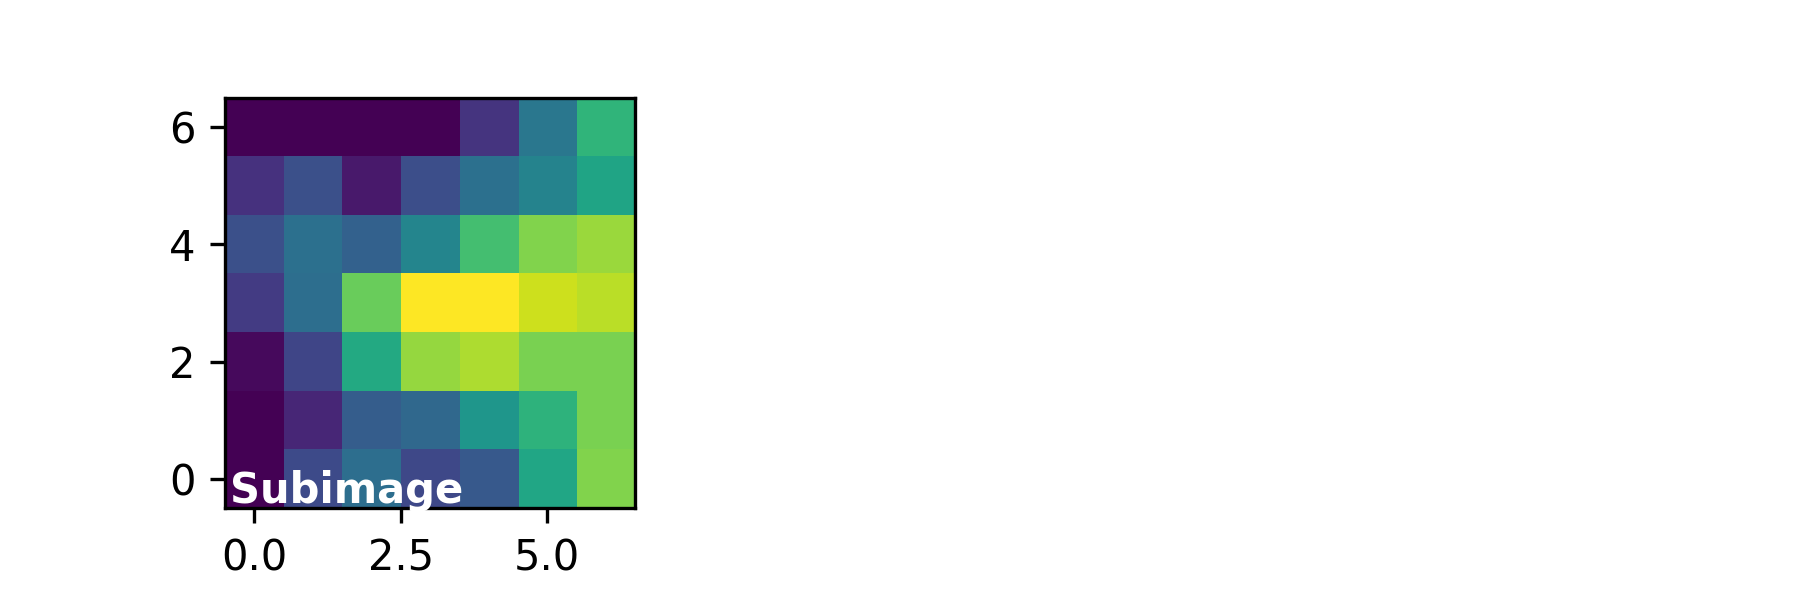

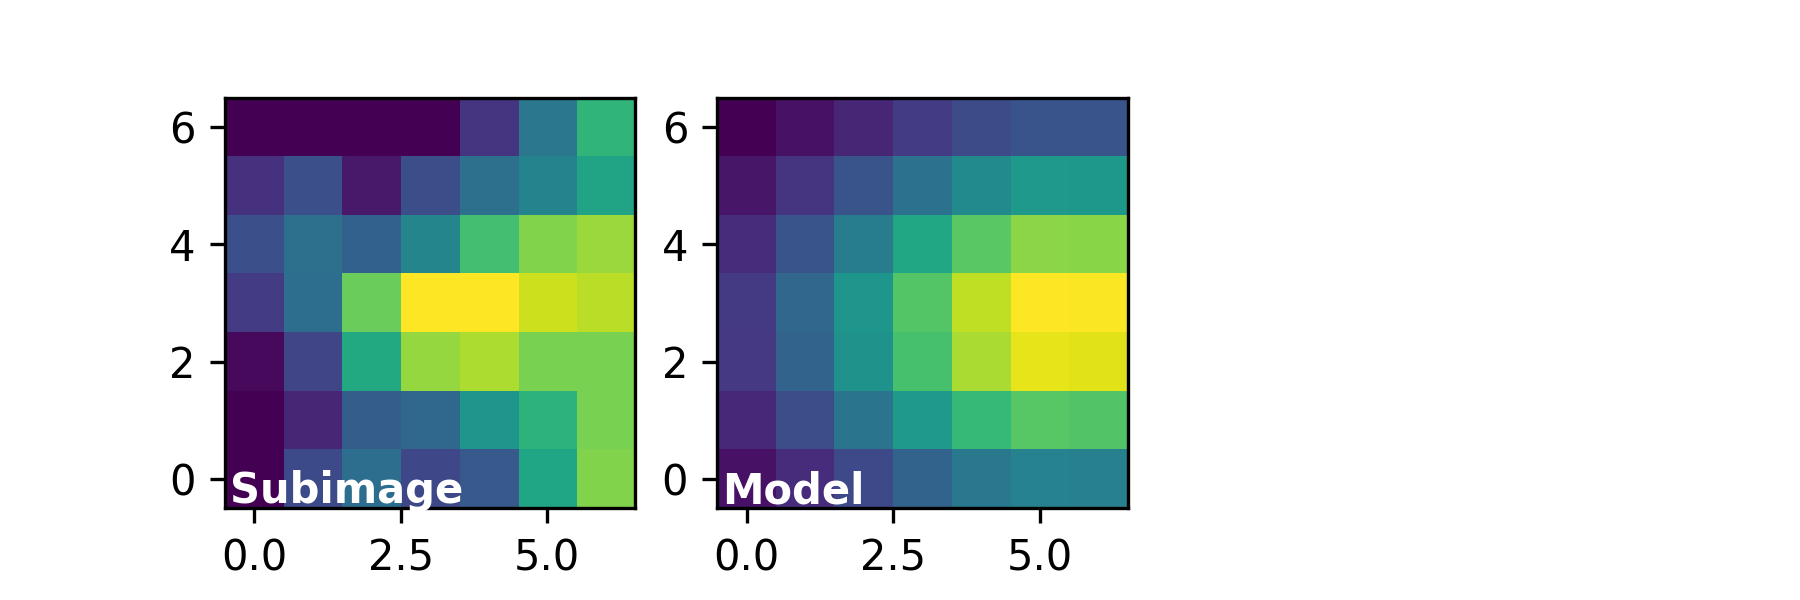

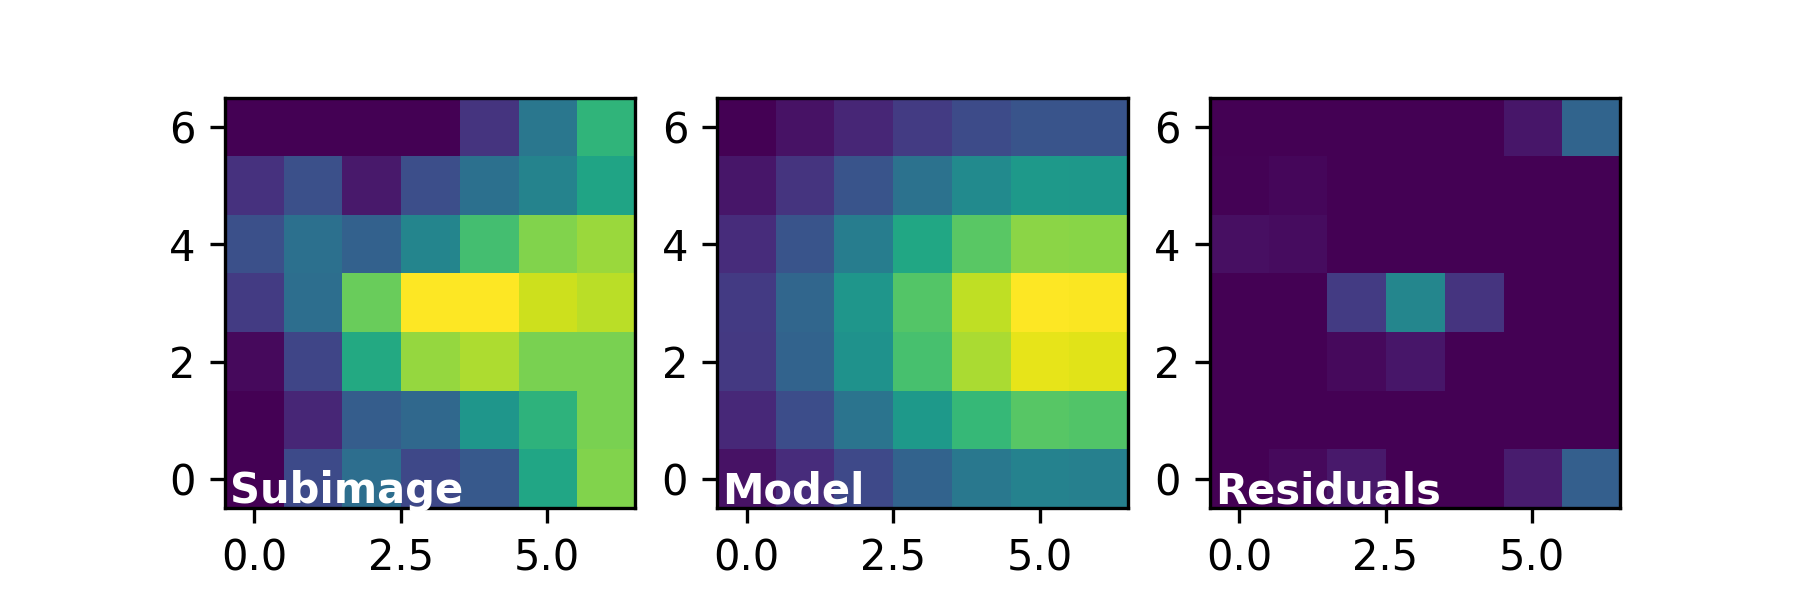

FWHM_y = 5.123220182383733
FWHM_x = 7.413076056606368 

centroid y = 22.66251246677234
centroid x = 22.422762770449793
centroid y subim = 2.6625124667723417
centroid x subim = 5.4227627704497925 

amplitude = 46088795.27768836
theta = 1.2077424147934497
Centroid median xy pixel coordinates for Level3_ifua_psf_ch1-short_s3d: (22,23)


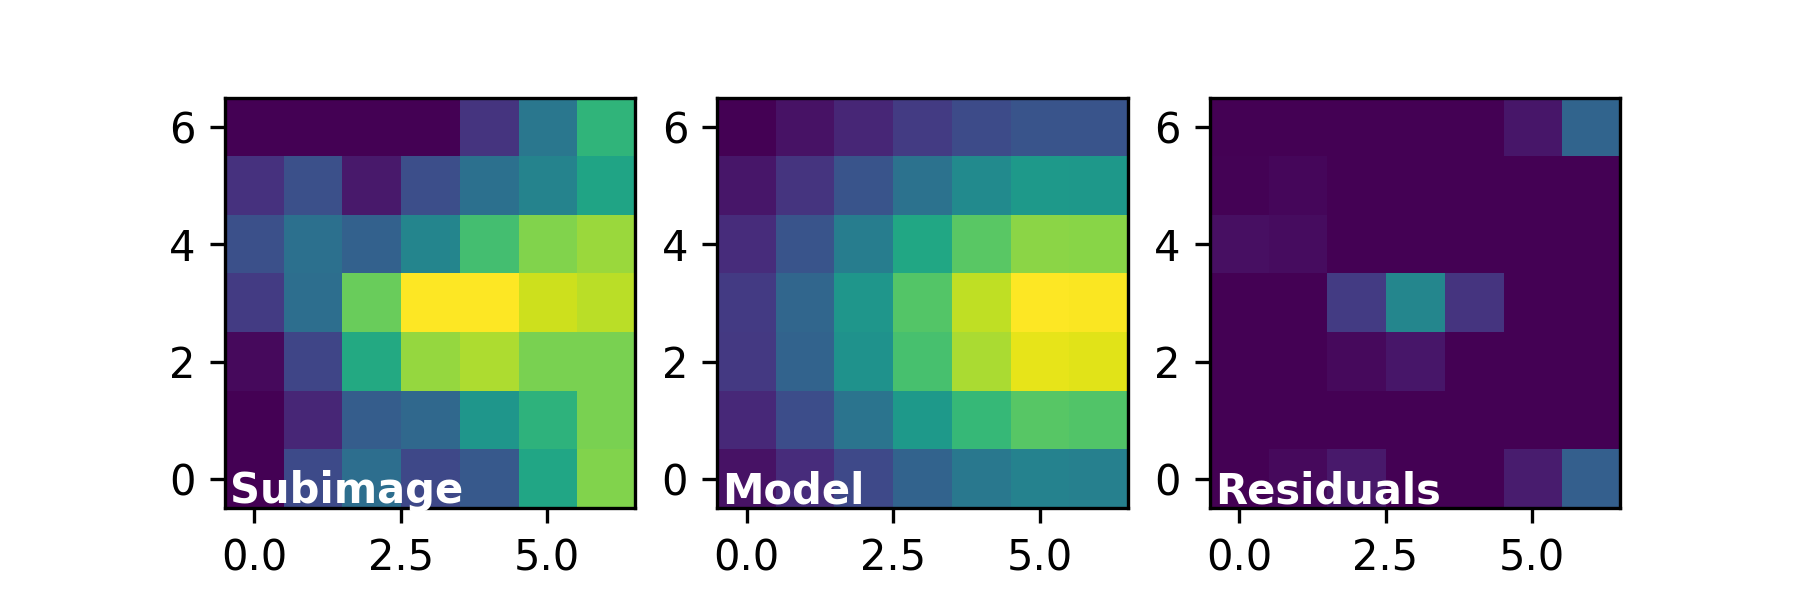

*** Recentering ../../../MINDS_OUTPUTS/GQLup/stage3linear_shifted_ddither/Level3_ifua_psf_ch1-medium_s3d ***
FITS file successfully saved
New shape: (7, 7)


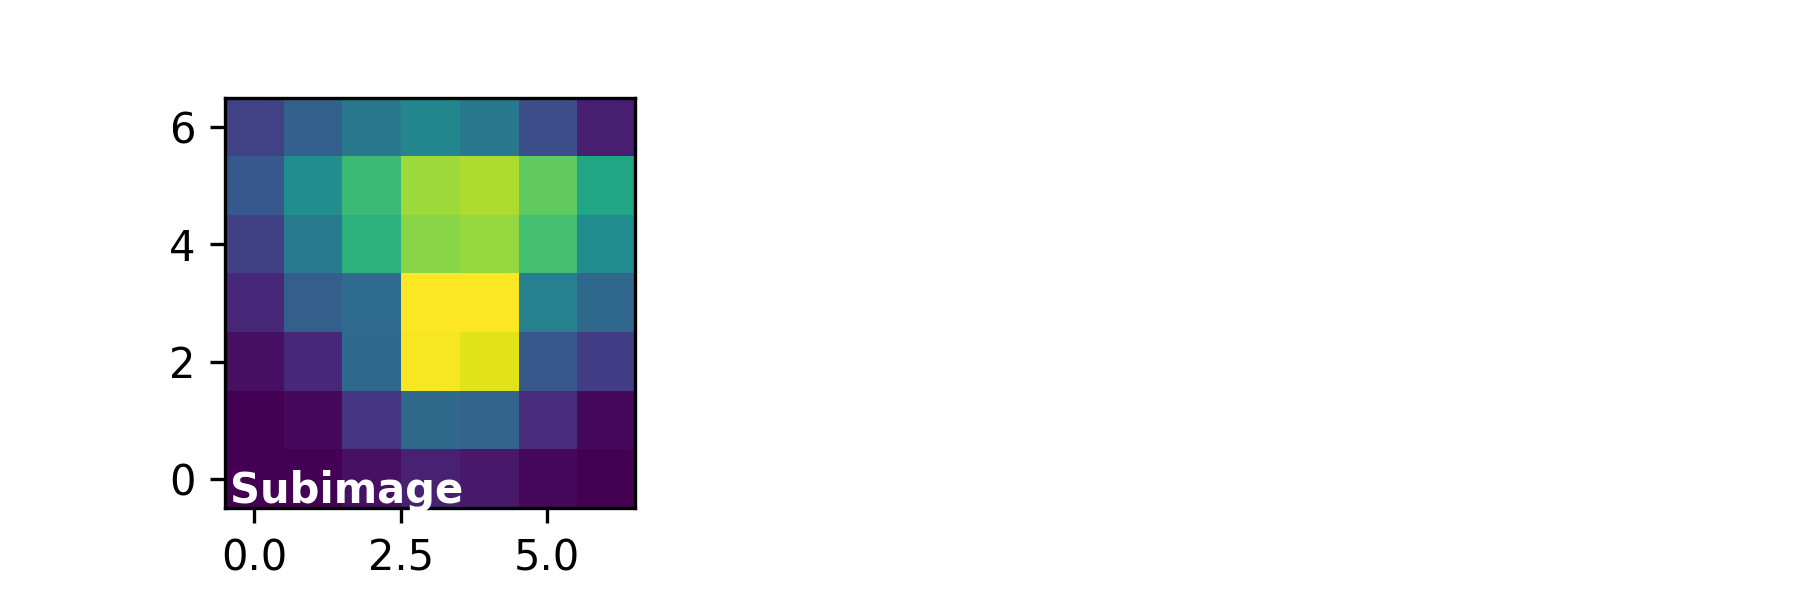

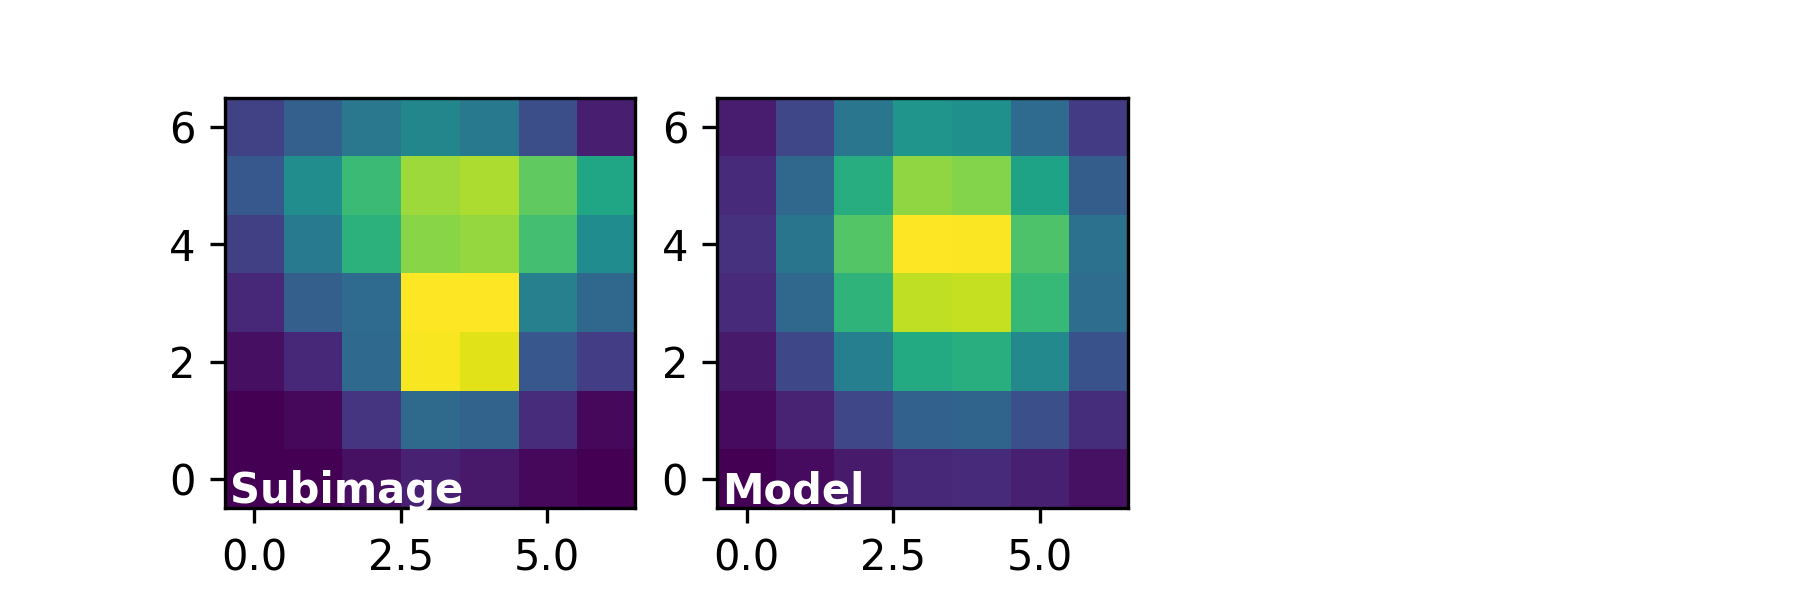

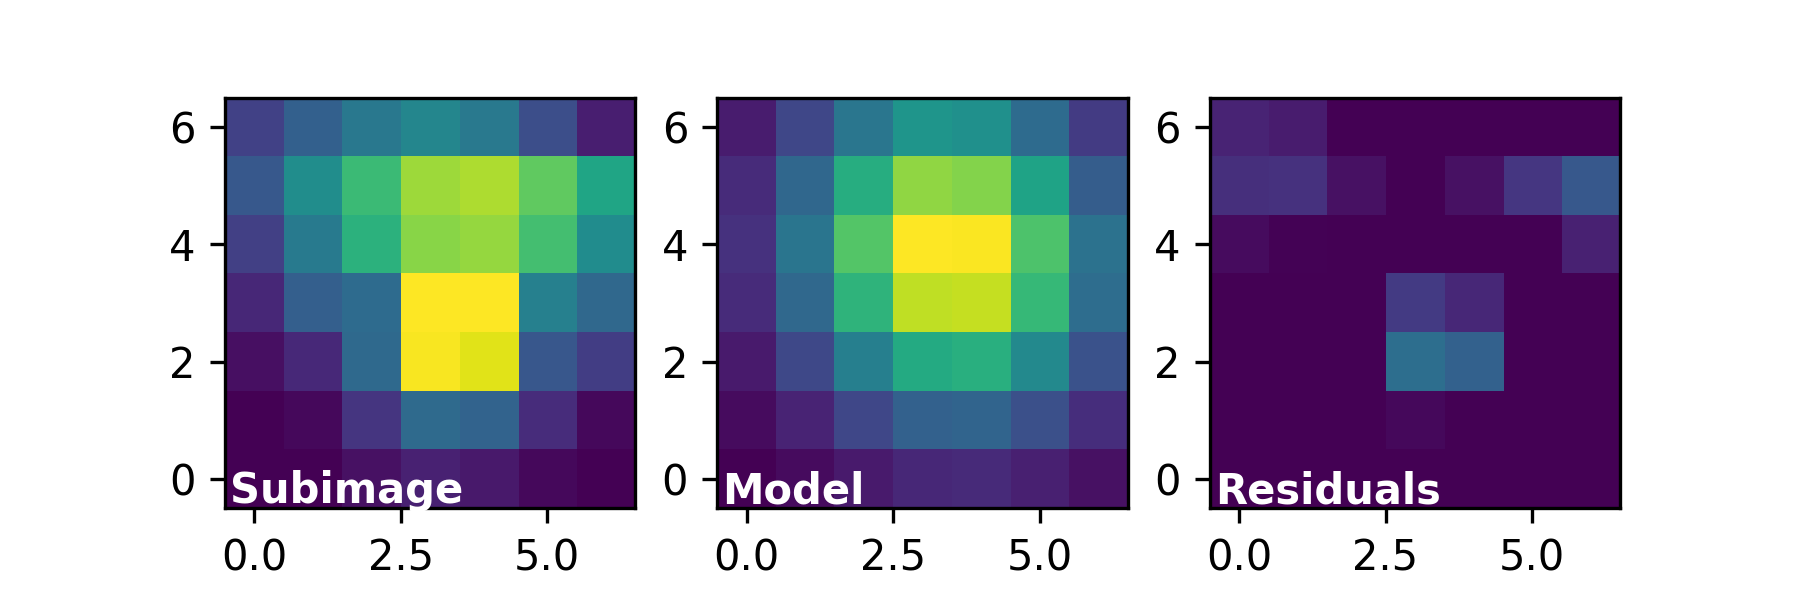

FWHM_y = 4.518570964468086
FWHM_x = 4.179055818827357 

centroid y = 21.832714781662233
centroid x = 22.489439328531486
centroid y subim = 3.8327147816622342
centroid x subim = 3.489439328531486 

amplitude = 11497909449.550674
theta = 23.033703858845787
Centroid median xy pixel coordinates for Level3_ifua_psf_ch1-medium_s3d: (22,22)


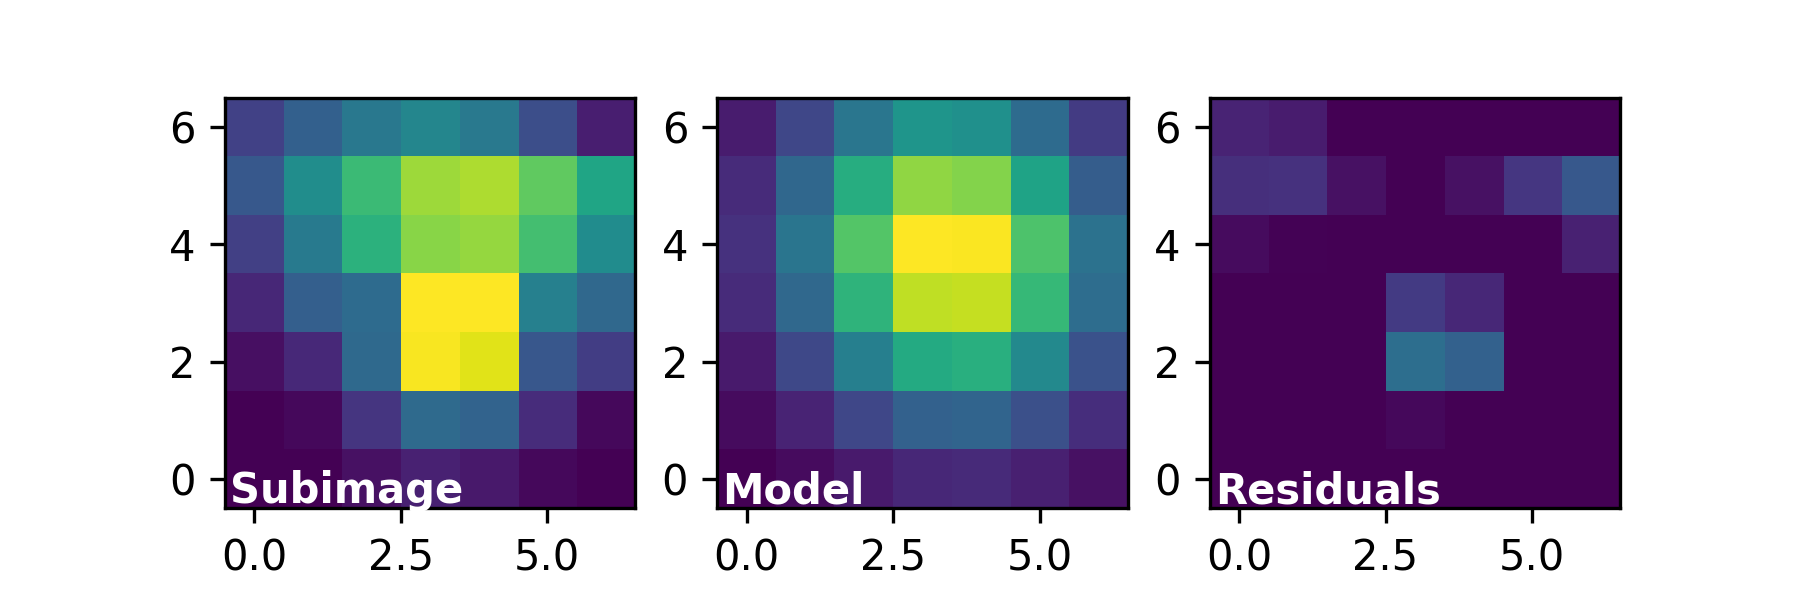

*** Recentering ../../../MINDS_OUTPUTS/GQLup/stage3linear_shifted_ddither/Level3_ifua_psf_ch1-long_s3d ***
FITS file successfully saved
New shape: (7, 7)


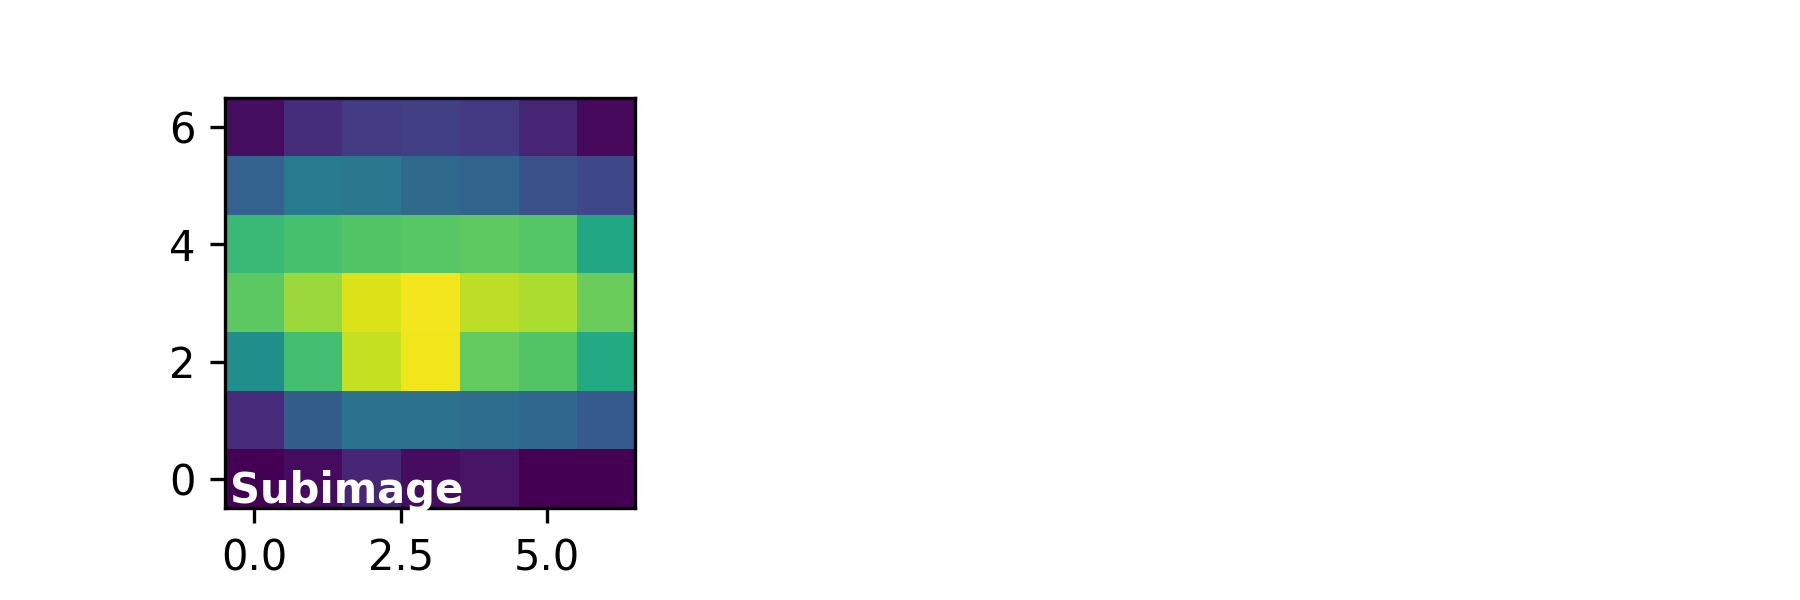

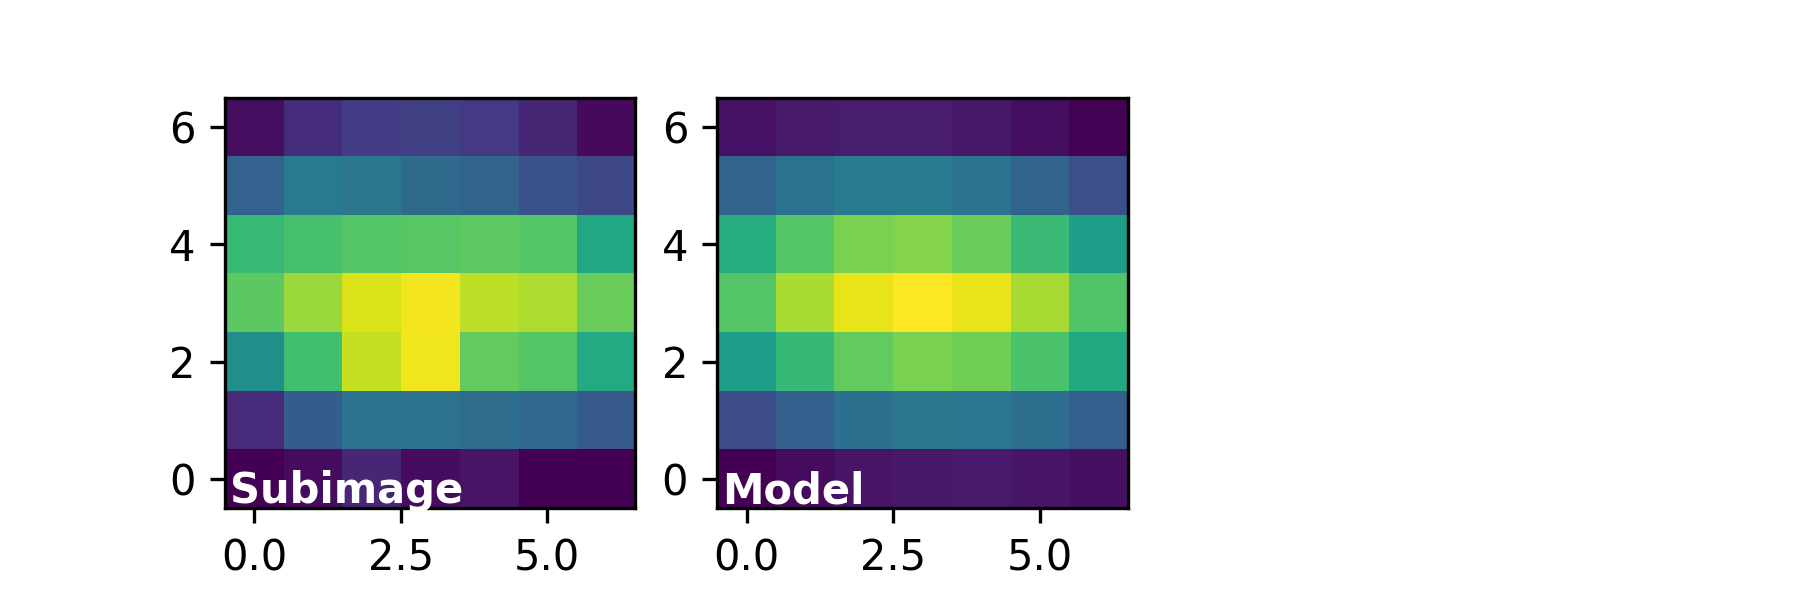

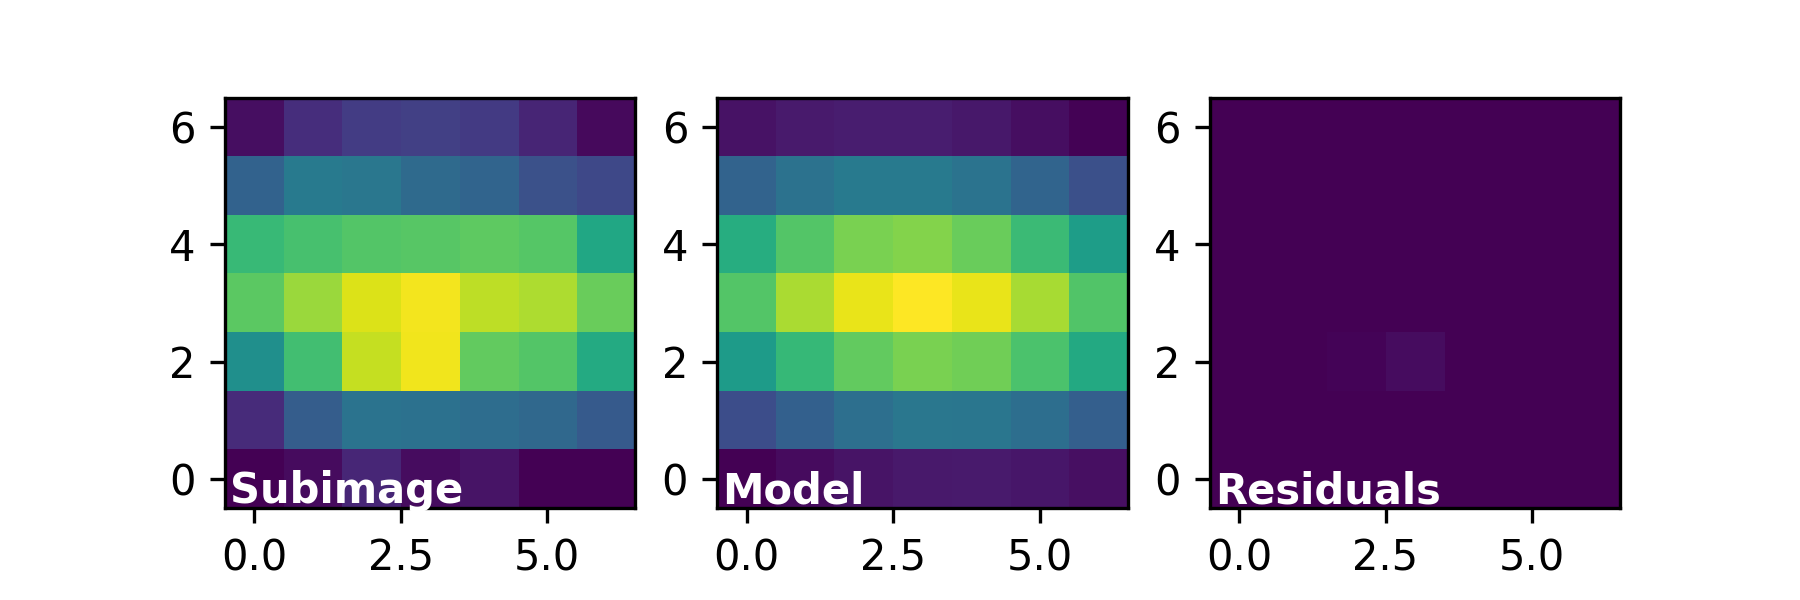

FWHM_y = 3.867253226374911
FWHM_x = 9.704769879591169 

centroid y = 24.02021702947238
centroid x = 22.987688558915575
centroid y subim = 3.0202170294723816
centroid x subim = 2.987688558915574 

amplitude = 117741523.23963666
theta = -2.618139064574444
Centroid median xy pixel coordinates for Level3_ifua_psf_ch1-long_s3d: (23,24)


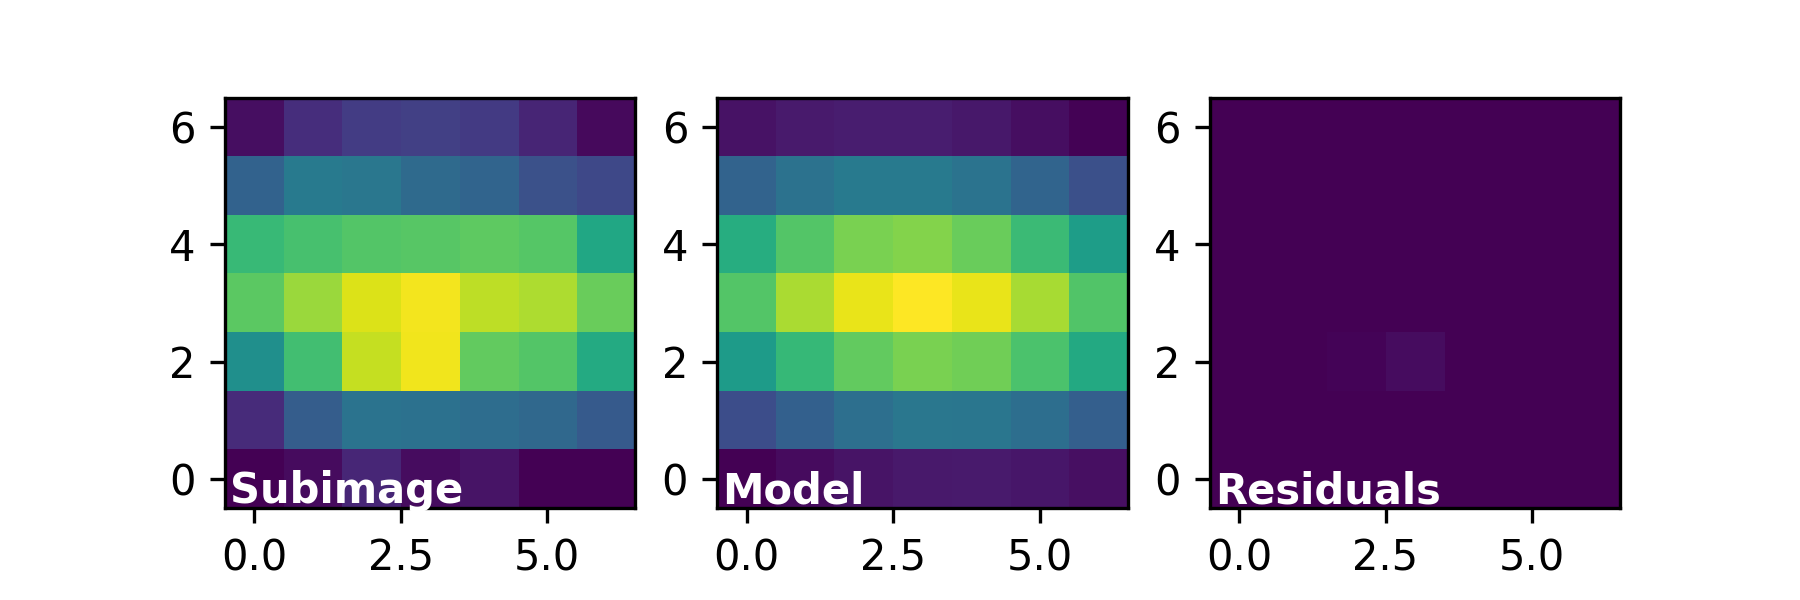

*** Recentering ../../../MINDS_OUTPUTS/GQLup/stage3linear_shifted_ddither/Level3_ifua_psf_ch2-short_s3d ***
FITS file successfully saved
New shape: (7, 7)


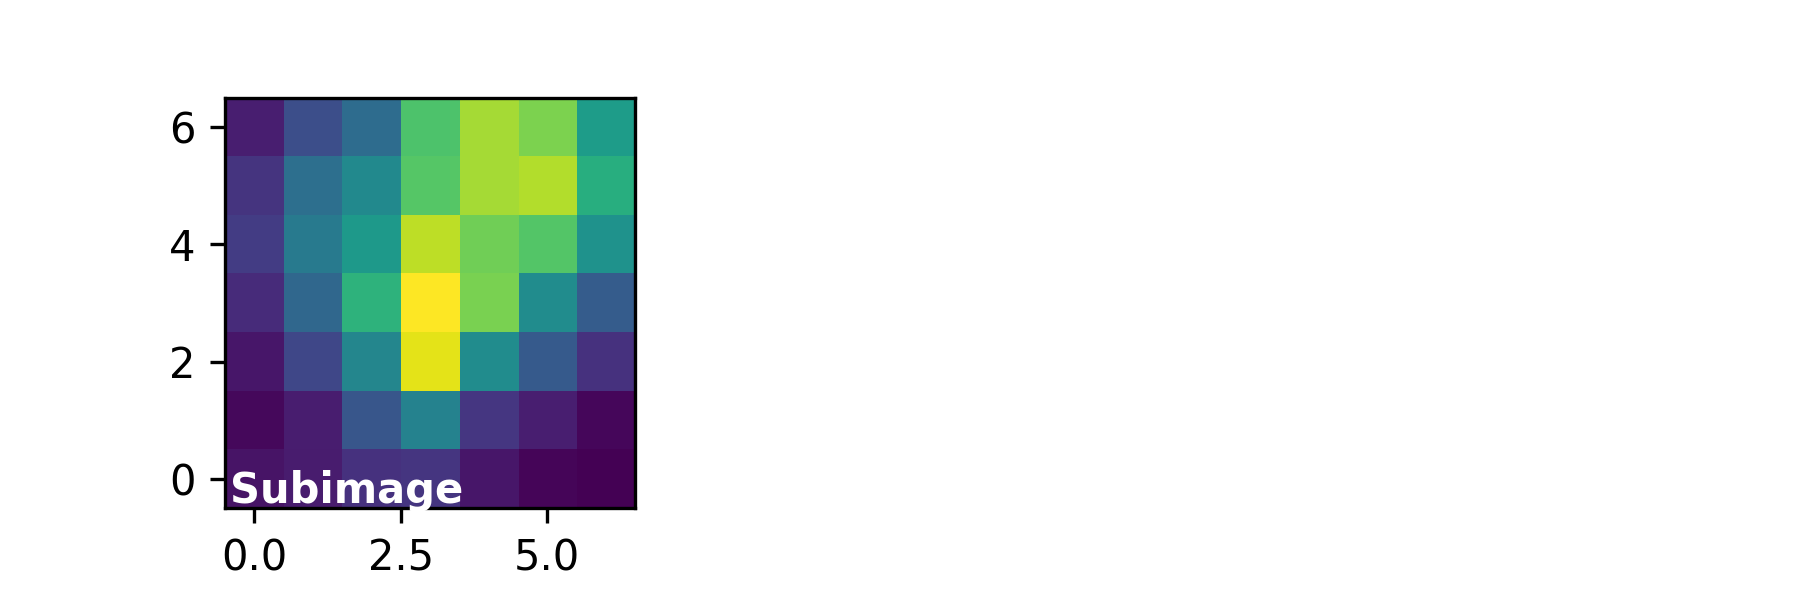

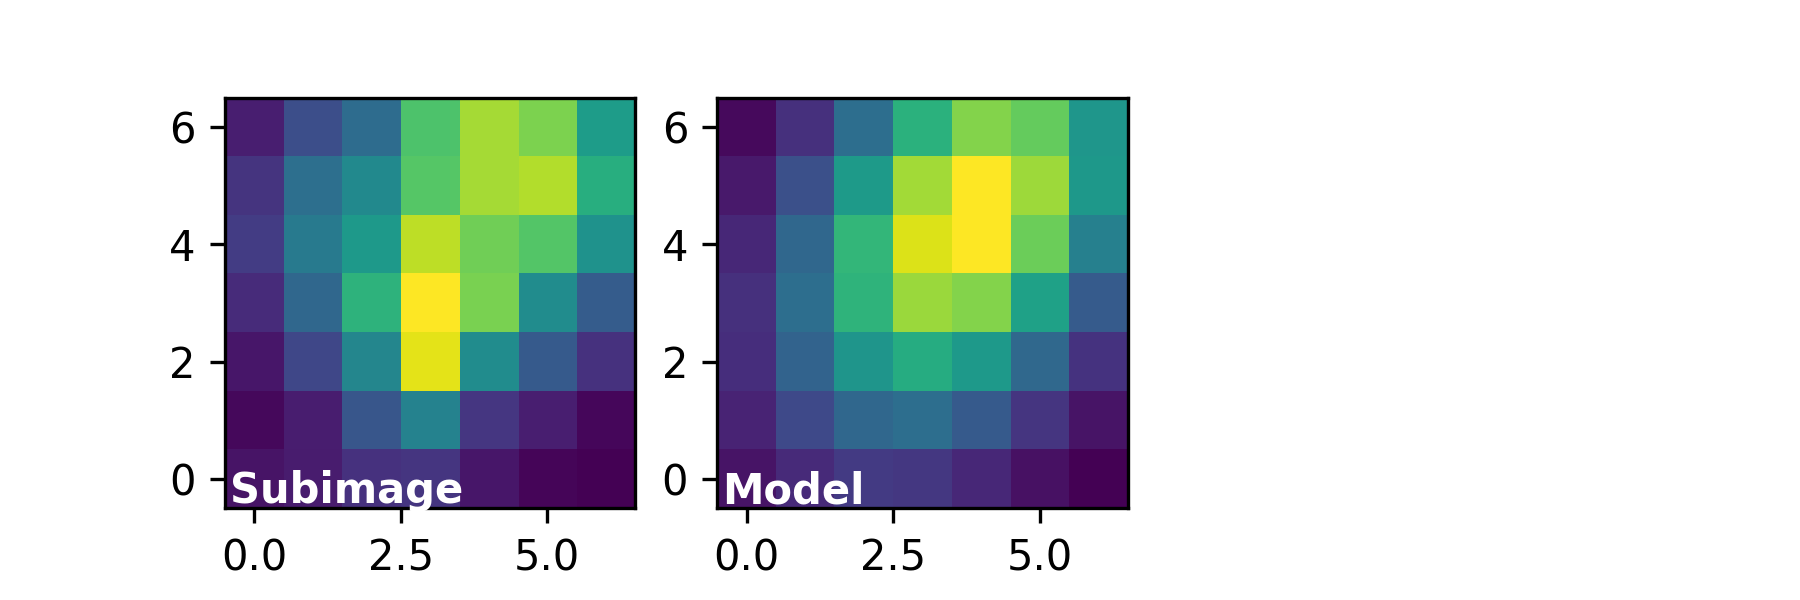

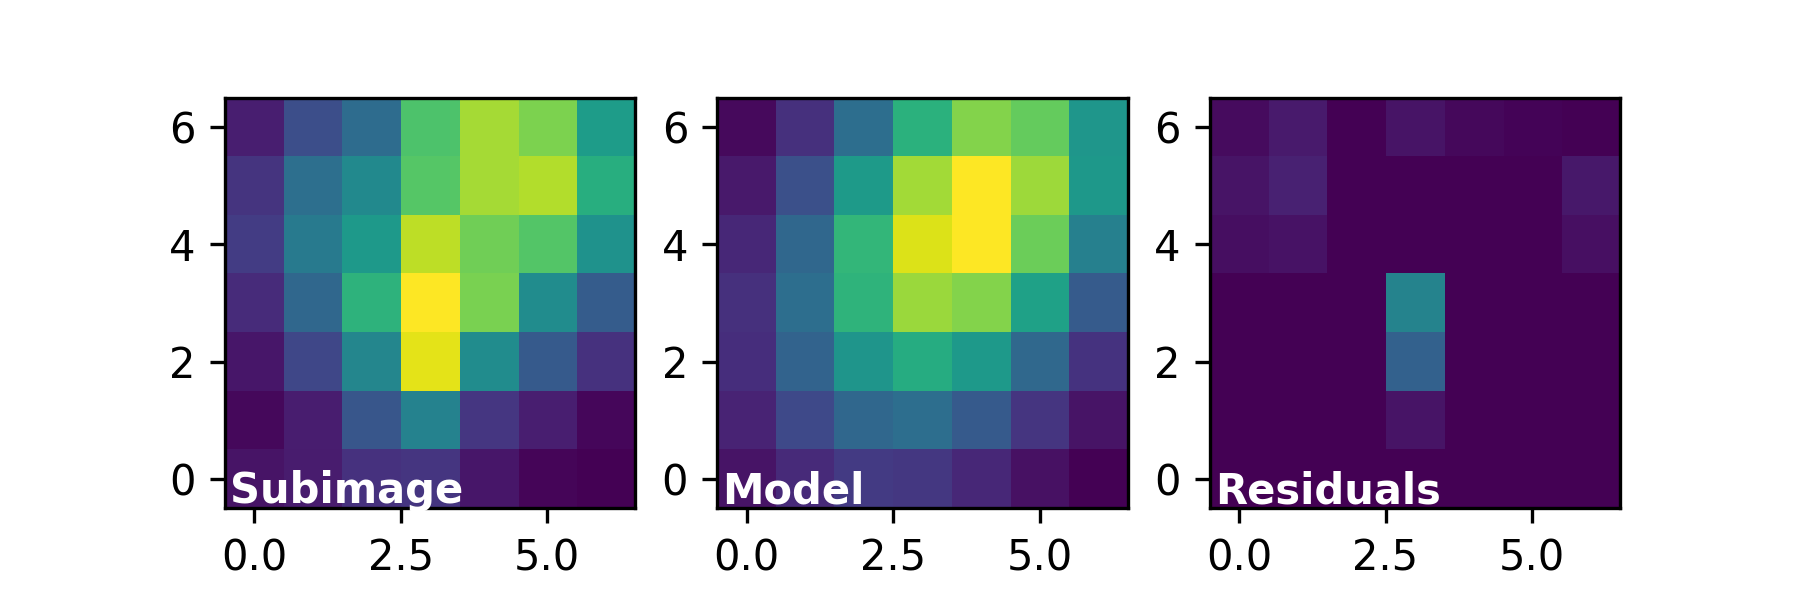

FWHM_y = 6.231420903045229
FWHM_x = 3.9663992501712917 

centroid y = 18.410530907875817
centroid x = 20.798248974506137
centroid y subim = 4.410530907875816
centroid x subim = 3.7982489745061363 

amplitude = 49873484.12476051
theta = -30.91607527976377
Centroid median xy pixel coordinates for Level3_ifua_psf_ch2-short_s3d: (21,18)


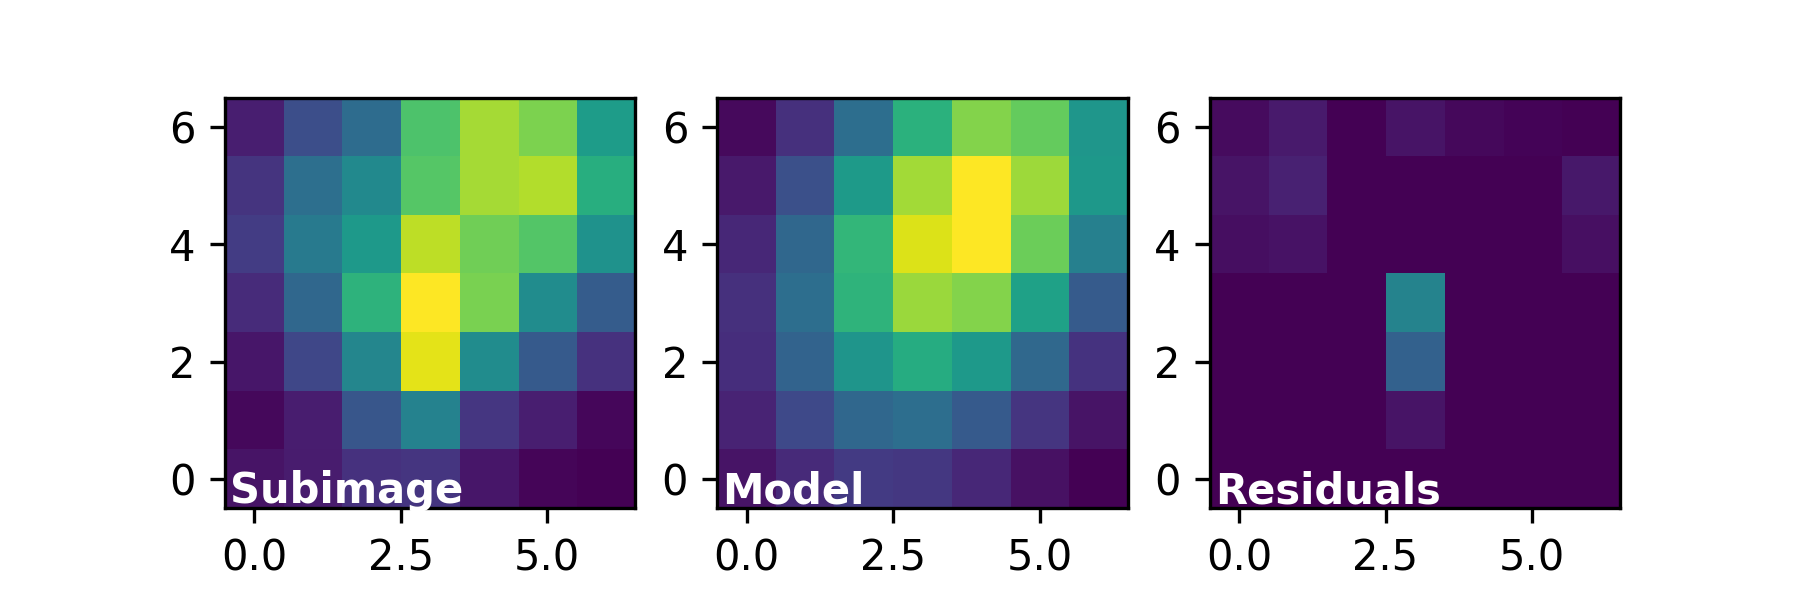

*** Recentering ../../../MINDS_OUTPUTS/GQLup/stage3linear_shifted_ddither/Level3_ifua_psf_ch2-medium_s3d ***
FITS file successfully saved
New shape: (7, 7)


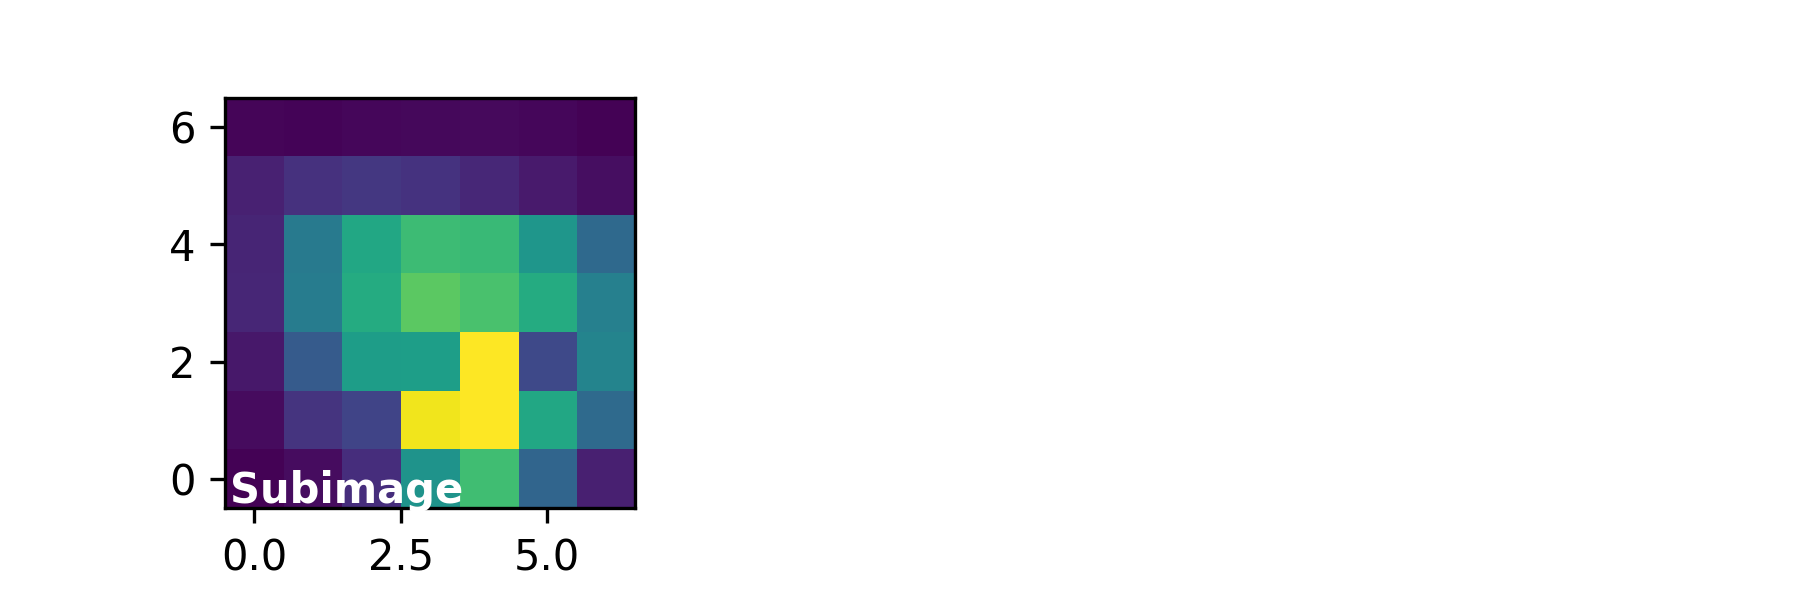

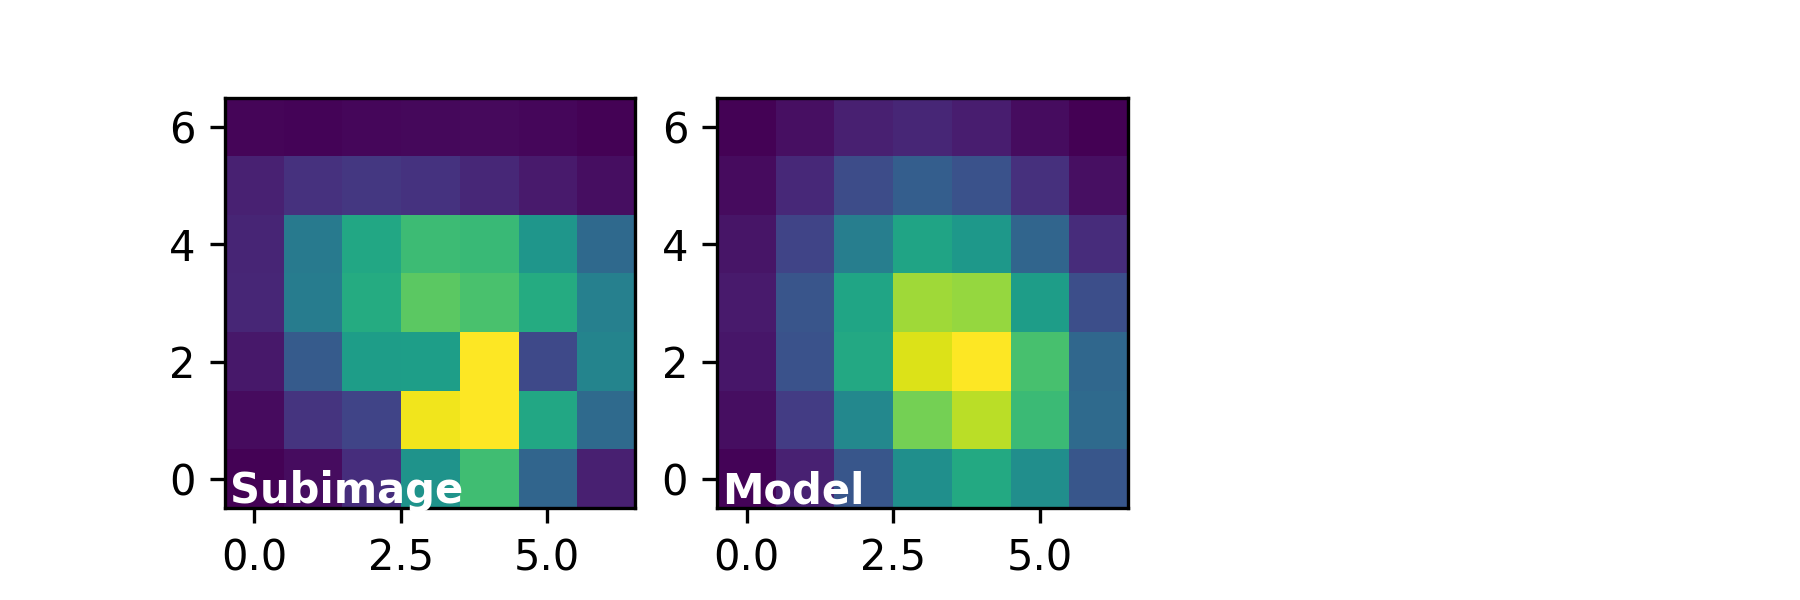

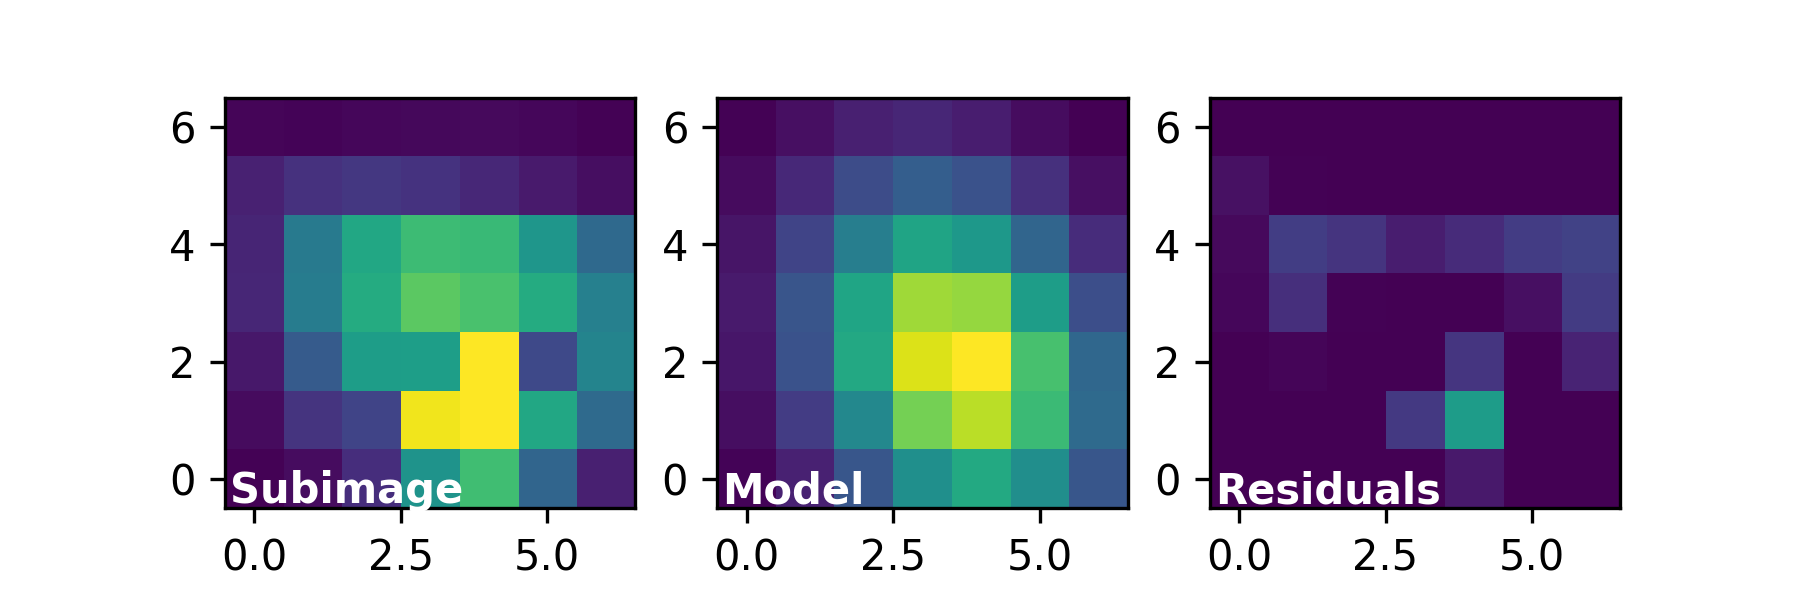

FWHM_y = 4.7980278067759645
FWHM_x = 3.63002668957506 

centroid y = 16.982016820209548
centroid x = 21.636974883333284
centroid y subim = 1.9820168202095467
centroid x subim = 3.6369748833332856 

amplitude = 913102725.2623506
theta = 25.65556145927738
Centroid median xy pixel coordinates for Level3_ifua_psf_ch2-medium_s3d: (22,17)


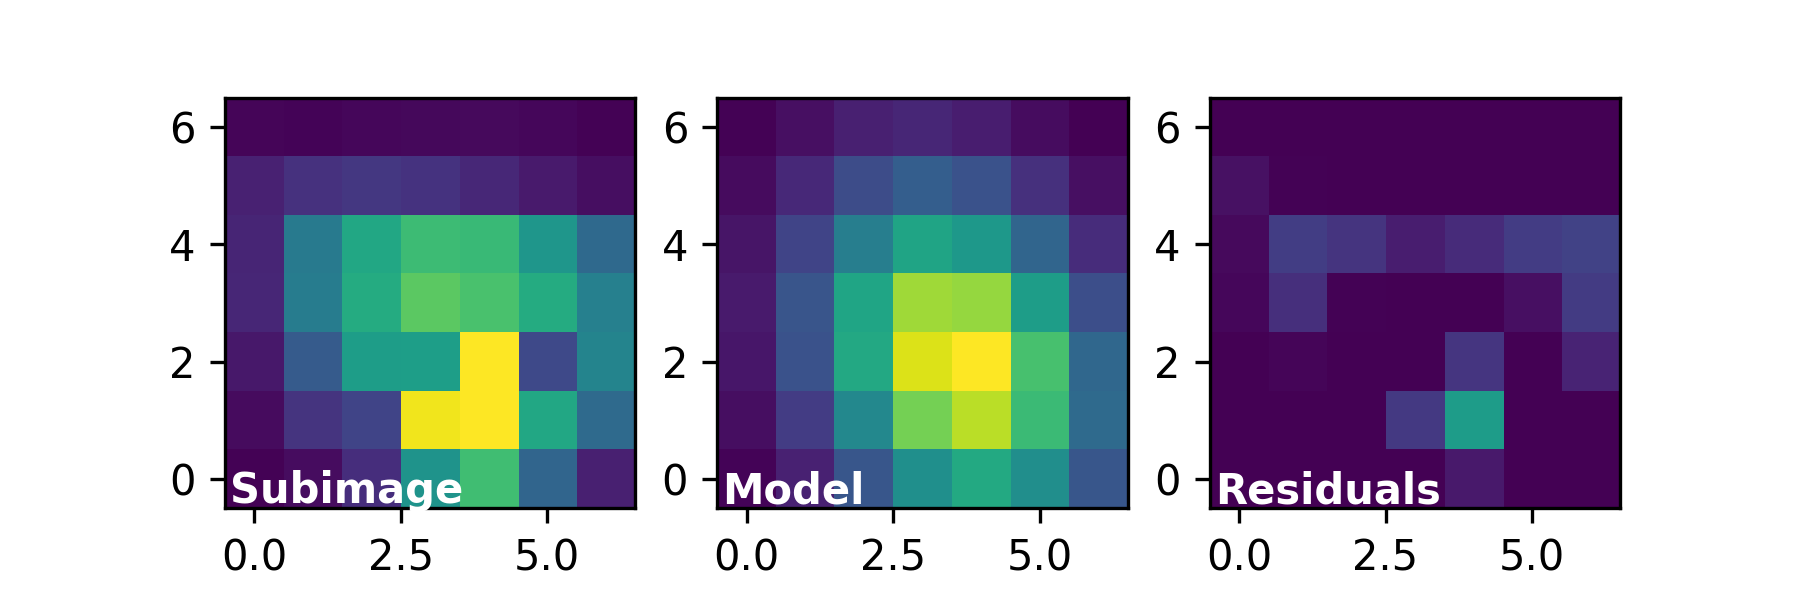

*** Recentering ../../../MINDS_OUTPUTS/GQLup/stage3linear_shifted_ddither/Level3_ifua_psf_ch2-long_s3d ***
FITS file successfully saved
New shape: (7, 7)


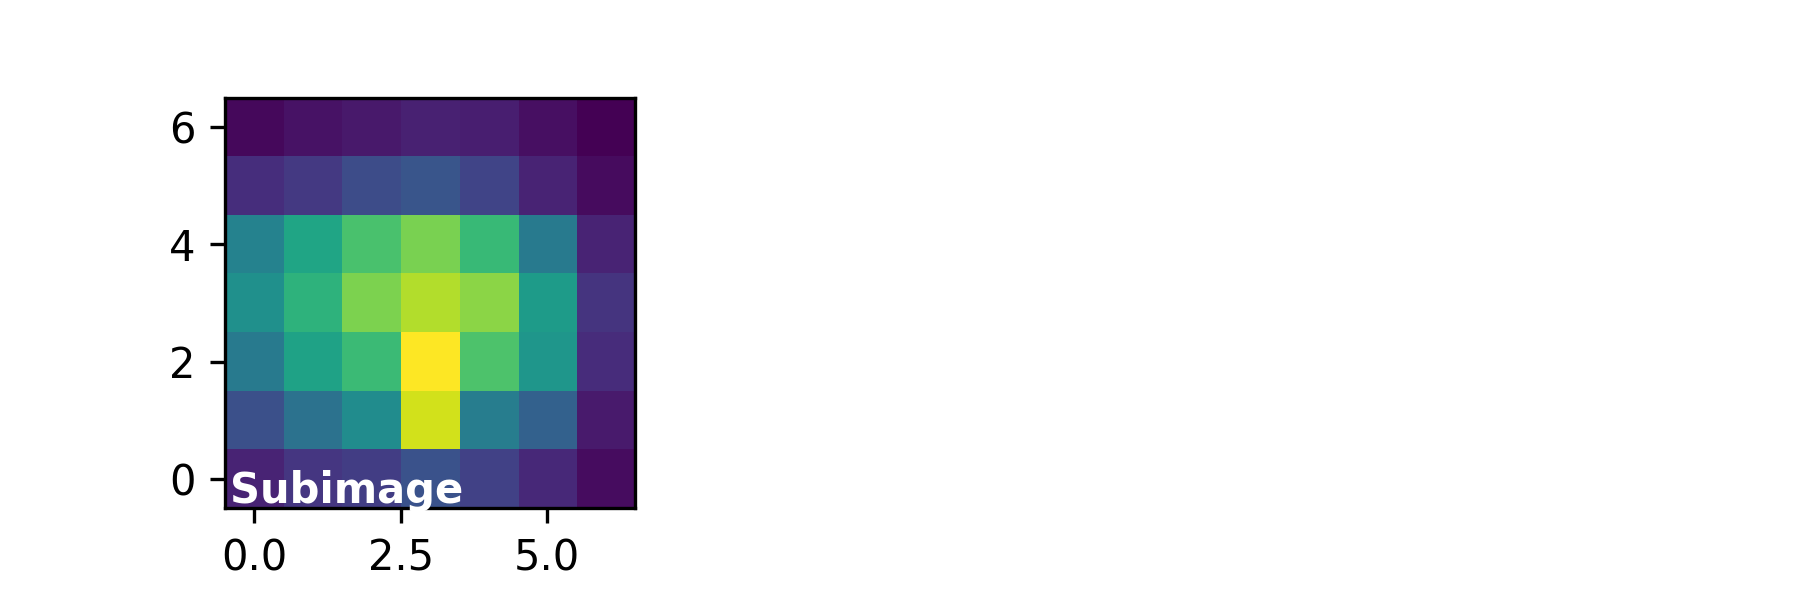

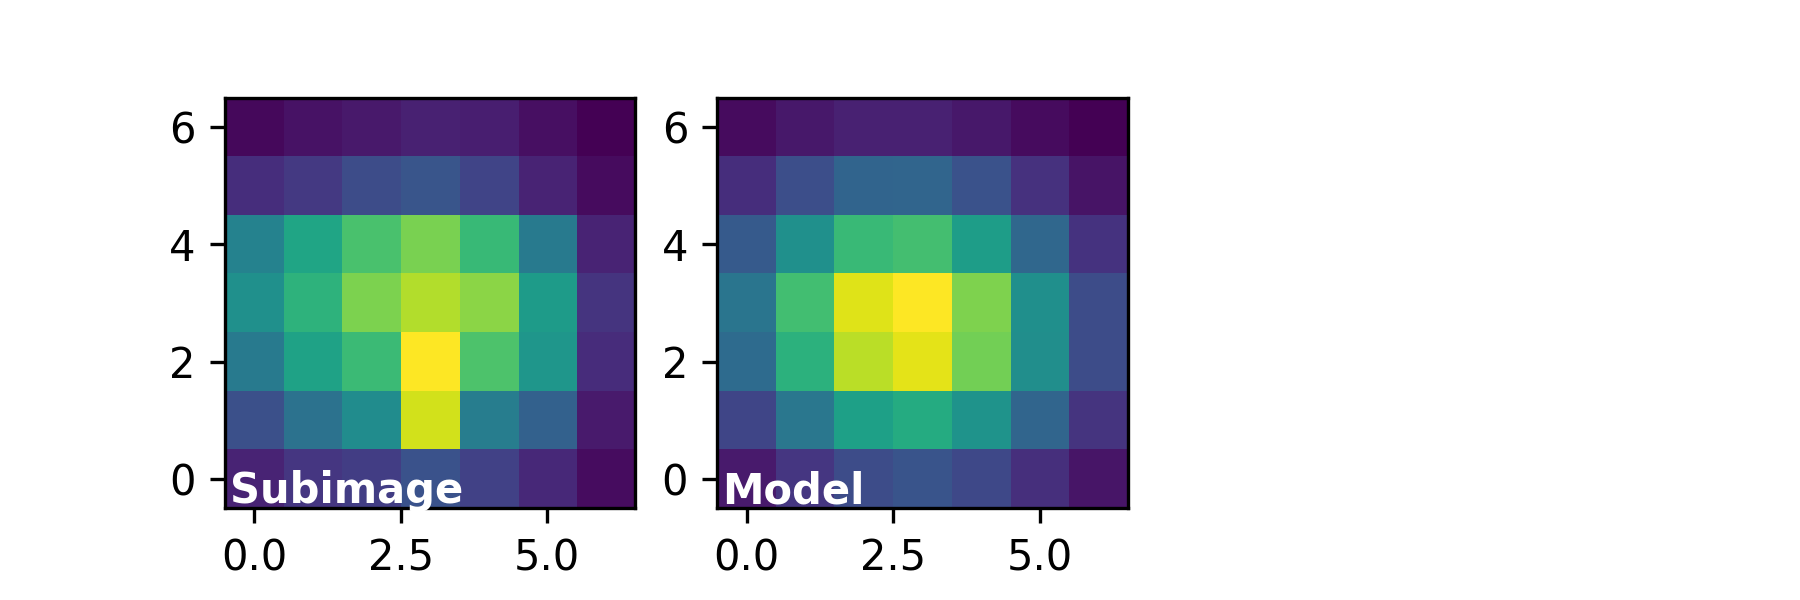

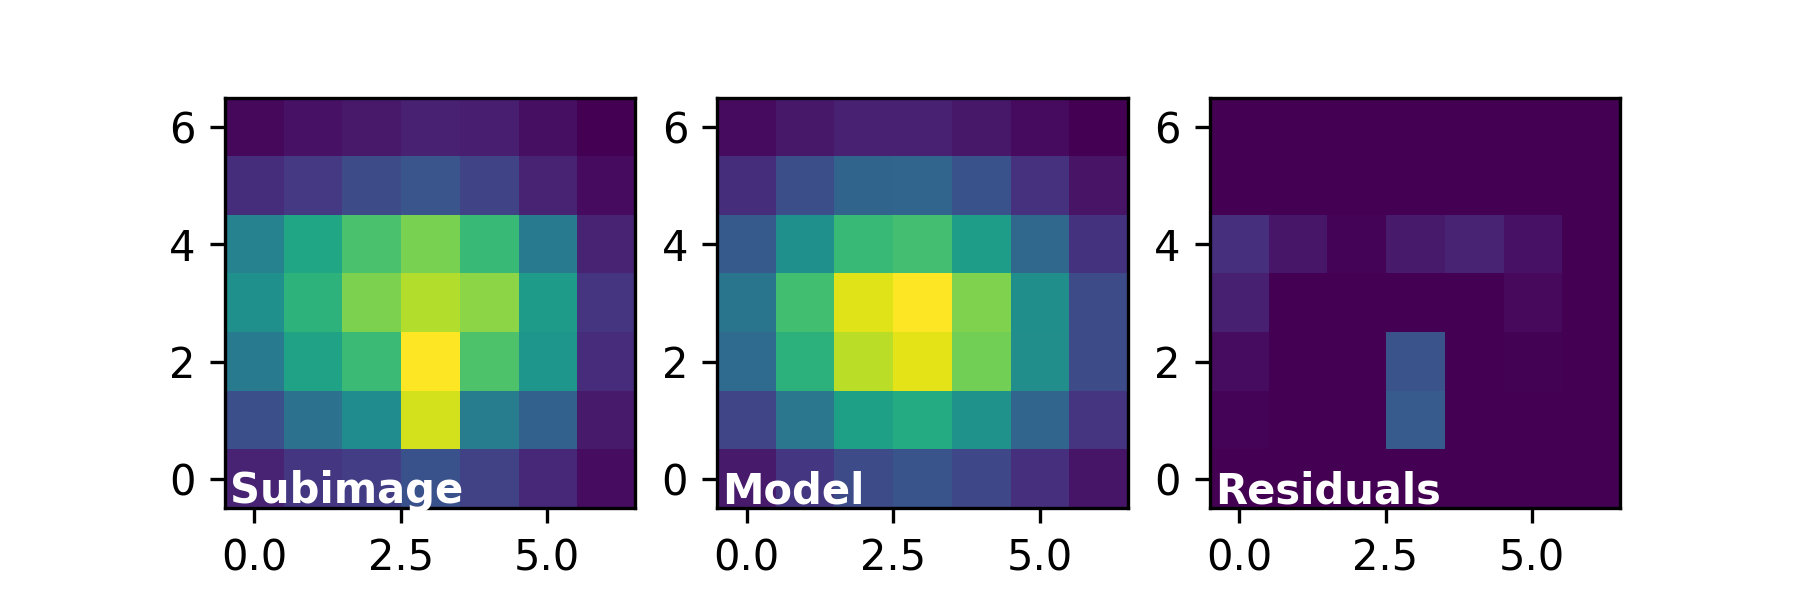

FWHM_y = 3.7819293529672477
FWHM_x = 4.675073293080448 

centroid y = 16.619730330480404
centroid x = 19.713933442451356
centroid y subim = 2.619730330480404
centroid x subim = 2.713933442451357 

amplitude = 205316305.347099
theta = -7.271539353393783
Centroid median xy pixel coordinates for Level3_ifua_psf_ch2-long_s3d: (20,17)


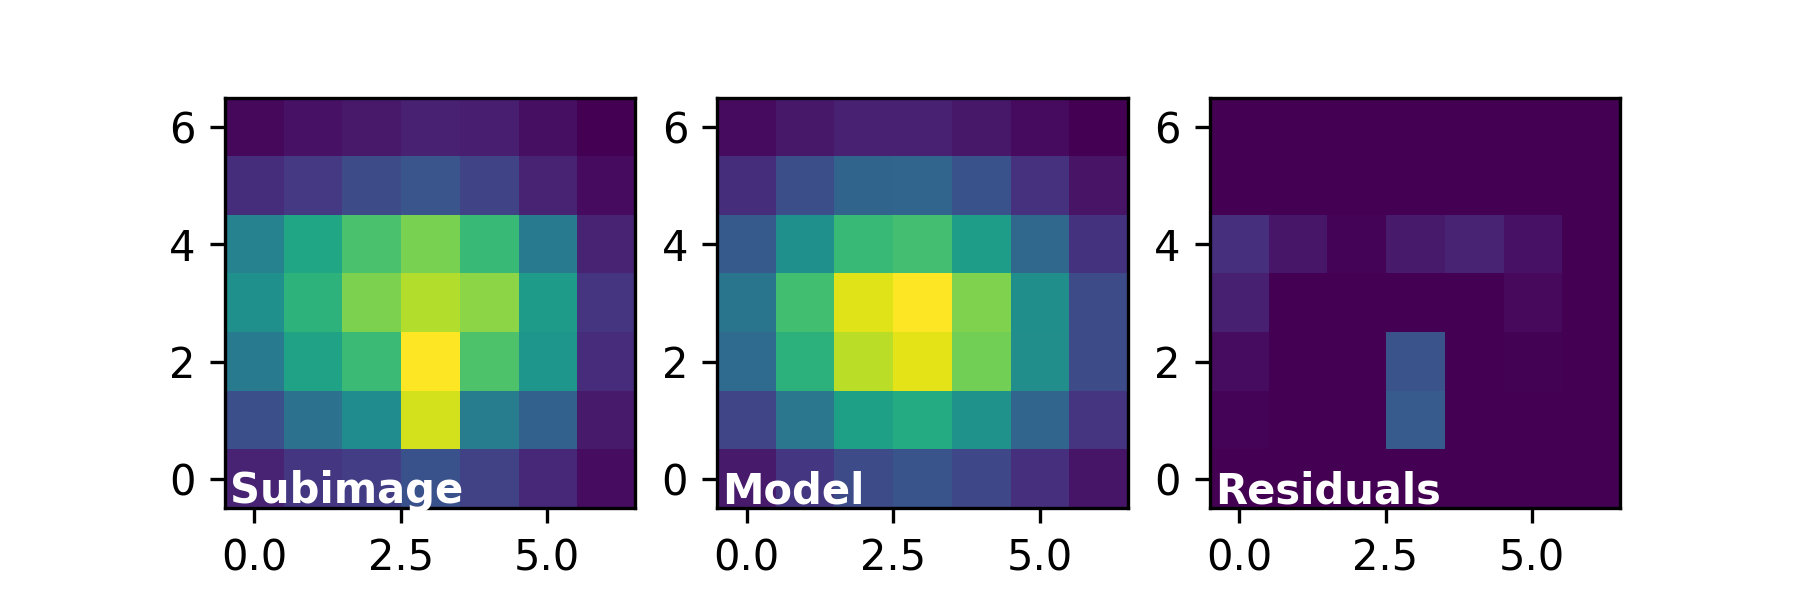

In [ ]:
discard_idx_band = []
if discard_band_cen is not None:
    for dd in discard_band_cen:
        discard_idx_band.append(convert_band_to_idx(dd)) 
cxy_med_ifua = []
for ff, file in enumerate(calfiles_ifua):
    bname = splitext(file)[0]
    print("*** Recentering {} ***".format(bname))
    if bname[-5:] == '_bpc3':
        bname = bname[:-5]
    outname = bname+'_cen.fits'
    if ff in discard_idx_band:
        os.system("cp {} {}".format(file, outname))
        cube = fits.getdata(file, 'SCI')
        cy, cx = frame_center(cube)
        cxy_med_ifua.append((cx,cy))
    else:
        cxy_med_ifua.append(recenter_cubes(file, sig=5, method=cen_method, imlib=imlib, debug=show_plots, 
                                           crop_sz=crop_sz, suffix='_cen', verbose=True, overwrite=True))
        if show_plots:
            plt.show()
    ## if no centering just copy input file
#         if cen_method is None:
#             os.system("cp {} {}".format(file, outname))
#    os.system("cp {} {}/.".format(outname, fin3_dir)) --> NOW done after potential residual BKG subtraction
if discard_band_cen is not None:
    # for bands with very low signal from the star, replace centroid coordinates with median of good coordinates in the same channel
    for ff in discard_idx_band:
        msg = "WARNING: centroid in band#{} will be replaced by ".format(ff)
        if ff%3 == 0:
            good_ff = [ff_tmp+ff for ff_tmp in [1,2] if ff_tmp+ff not in discard_idx_band]
        elif ff%3 == 1:
            good_ff = [ff_tmp+ff for ff_tmp in [-1,1] if ff_tmp+ff not in discard_idx_band]
        else:
            good_ff = [ff_tmp+ff for ff_tmp in [-2,-1] if ff_tmp+ff not in discard_idx_band]
        if len(good_ff)==2:
            cxy_med_ifua[ff] = (np.median([cxy_med_ifua[good_ff[0]][0],cxy_med_ifua[good_ff[1]][0]]),
                                np.median([cxy_med_ifua[good_ff[0]][1],cxy_med_ifua[good_ff[1]][1]]))
            msg += "median of centroid inferred in bands# {} and {}: {}".format(good_ff[0], good_ff[1], cxy_med_ifua[ff])
        elif len(good_ff)==1:
            cxy_med_ifua[ff] = (cxy_med_ifua[good_ff[0]][0], cxy_med_ifua[good_ff[0]][1])
            msg += "centroid inferred in band# {}: {}".format(good_ff[0], cxy_med_ifua[ff])
        else:
            msg += "center of field of view: {}".format(cxy_med_ifua[ff])
        print(msg)

In [ ]:
write_fits(join(spec3_dir,"cxy_med_ifua.fits"), np.array(cxy_med_ifua)) # write a first time to auto-generate some header keywords
_, head = open_fits(join(spec3_dir,"cxy_med_ifua.fits"), header=True)
chs = [1, 2, 3, 4]
bands = ['SHORT', 'MEDIUM','LONG'] #
c = 0    
print("Assumed XY coordinates for source spectrum extraction in the IFU-aligned cubes: ")
for i in chs:
    for j in bands:
        print("CH.{} {}: {}".format(i, j, cxy_med_ifua[c]))
        c+=1
        head['C_PAIR{}'.format(c)] = 'CH.{} {}'.format(i,j)
write_fits(join(spec3_dir,"cxy_med_ifua.fits"), np.array(cxy_med_ifua), header=head)
os.system("cp {} {}/.".format(join(spec3_dir,"cxy_med_ifua.fits"), fin3_dir))

FITS file successfully saved
FITS HDU-0 data and header successfully loaded. Data shape: (6, 2)
Assumed XY coordinates for source spectrum extraction in the IFU-aligned cubes: 
CH.1 SHORT: (22.422762770449793, 22.66251246677234)
CH.1 MEDIUM: (22.489439328531486, 21.832714781662233)
CH.1 LONG: (22.987688558915575, 24.02021702947238)
CH.2 SHORT: (20.798248974506137, 18.410530907875817)
CH.2 MEDIUM: (21.636974883333284, 16.982016820209548)
CH.2 LONG: (19.713933442451356, 16.619730330480404)


IndexError: list index out of range

### 5.3.2. Residual background subtraction

**For skyalign cubes:** 

In [ ]:
# List relevant files
calfiles=sorted(glob.glob(join(spec3_dir,'Level3{}*{}_cen.fits'.format(suffix[0], suf))))
calfiles = sort_files_wl(calfiles)
print(len(calfiles))

12


In [ ]:
if subtract_residual_bkg:
    for f, file in enumerate(calfiles):
        file_x1d = file.replace('{}_cen'.format(suf),'x1d')
        res_bkg_sub(file, file_x1d, cxy_med[f], r_min=r_min_res_bg_sub, suffix='_rbgsub', 
                    verbose=True, overwrite=overwrite_53)

**For ifualign cubes:**

In [ ]:
# List relevant files
calfiles_ifua=sorted(glob.glob(join(spec3_dir,'Level3_ifua{}*{}_cen.fits'.format(suffix[0], suf))))
calfiles_ifua = sort_files_wl(calfiles_ifua)
print(len(calfiles_ifua))

12


In [ ]:
if subtract_residual_bkg:
    for f, file in enumerate(calfiles_ifua):
        file_x1d = file.replace('{}_cen'.format(suf),'x1d')
        res_bkg_sub(file, file_x1d, cxy_med_ifua[f], r_min=r_min_res_bg_sub, suffix='_rbgsub', 
                    verbose=True, overwrite=overwrite_53)

In [ ]:
if subtract_residual_bkg:
    suf_bkg = '_rbgsub'
else:
    suf_bkg = ''

In [ ]:
calfiles_ifua

['../../../MINDS_OUTPUTS/GQLup/stage3CTandBKGsub_ddither/Level3_ifua_psf_ch1-short_s3d_cen.fits',
 '../../../MINDS_OUTPUTS/GQLup/stage3CTandBKGsub_ddither/Level3_ifua_psf_ch1-medium_s3d_cen.fits',
 '../../../MINDS_OUTPUTS/GQLup/stage3CTandBKGsub_ddither/Level3_ifua_psf_ch1-long_s3d_cen.fits',
 '../../../MINDS_OUTPUTS/GQLup/stage3CTandBKGsub_ddither/Level3_ifua_psf_ch2-short_s3d_cen.fits',
 '../../../MINDS_OUTPUTS/GQLup/stage3CTandBKGsub_ddither/Level3_ifua_psf_ch2-medium_s3d_cen.fits',
 '../../../MINDS_OUTPUTS/GQLup/stage3CTandBKGsub_ddither/Level3_ifua_psf_ch2-long_s3d_cen.fits',
 '../../../MINDS_OUTPUTS/GQLup/stage3CTandBKGsub_ddither/Level3_ifua_psf_ch3-short_s3d_cen.fits',
 '../../../MINDS_OUTPUTS/GQLup/stage3CTandBKGsub_ddither/Level3_ifua_psf_ch3-medium_s3d_cen.fits',
 '../../../MINDS_OUTPUTS/GQLup/stage3CTandBKGsub_ddither/Level3_ifua_psf_ch3-long_s3d_cen.fits',
 '../../../MINDS_OUTPUTS/GQLup/stage3CTandBKGsub_ddither/Level3_ifua_psf_ch4-short_s3d_cen.fits',
 '../../../MINDS_OUT

Write s3d cubes after potential subtraction of residual background level in final output directory:

In [ ]:
for ff, file in enumerate(calfiles):
    bname = splitext(file)[0]
    outname = bname+'{}.fits'.format(suf_bkg)
    print("Copying to final directory: {}".format(outname))
    os.system("cp {} {}/.".format(outname, fin3_dir)) #    os.system("cp {} {}/.".format(outname, fin3_dir)) --> NOW done after potential residual BKG subtraction

for ff, file in enumerate(calfiles_ifua):
    bname = splitext(file)[0]
    outname = bname+'{}.fits'.format(suf_bkg)
    print("Copying to final directory: {}".format(outname))
    os.system("cp {} {}/.".format(outname, fin3_dir))

Copying to final directory: ../../../MINDS_OUTPUTS/GQLup/stage3CTandBKGsub_ddither/Level3_psf_ch1-short_s3d_cen.fits
Copying to final directory: ../../../MINDS_OUTPUTS/GQLup/stage3CTandBKGsub_ddither/Level3_psf_ch1-medium_s3d_cen.fits
Copying to final directory: ../../../MINDS_OUTPUTS/GQLup/stage3CTandBKGsub_ddither/Level3_psf_ch1-long_s3d_cen.fits
Copying to final directory: ../../../MINDS_OUTPUTS/GQLup/stage3CTandBKGsub_ddither/Level3_psf_ch2-short_s3d_cen.fits
Copying to final directory: ../../../MINDS_OUTPUTS/GQLup/stage3CTandBKGsub_ddither/Level3_psf_ch2-medium_s3d_cen.fits
Copying to final directory: ../../../MINDS_OUTPUTS/GQLup/stage3CTandBKGsub_ddither/Level3_psf_ch2-long_s3d_cen.fits
Copying to final directory: ../../../MINDS_OUTPUTS/GQLup/stage3CTandBKGsub_ddither/Level3_psf_ch3-short_s3d_cen.fits
Copying to final directory: ../../../MINDS_OUTPUTS/GQLup/stage3CTandBKGsub_ddither/Level3_psf_ch3-medium_s3d_cen.fits
Copying to final directory: ../../../MINDS_OUTPUTS/GQLup/stage3

### 5.3.3. Aperture photometry + spike filtering

**Using `extract_1d`**

Note 1: the aperture correction factors are not used in `extract_1d` if src_type is defined as EXTENDED.

Note 2: we systematically run `extract_1d` whether it is the desired output or not. In the latter case, it is used to save the manually extracted spectrum into the same format.

In [ ]:
def extractspec(filename, outdir, overwrite, cxy=None, autocen=False,
                do_rfc1d_e1d=False, subtract_background=False):
    #print(filename)
    #suffix = make_spec1d_suffix(autocen=autocen, do_rfc1d_e1d=do_rfc1d_e1d, 
    #                            subtract_background=subtract_background)
    suffix = 'x1d_minds'
    if do_rfc1d_e1d:
        suffix += '_rfc1d'
    outfile = splitext(filename)[0]+'_'+suffix+'.fits'

    print(outfile)
    if not isfile(outfile) or overwrite:
        crds_config = Extract1dStep.get_config_from_reference(filename)
        e1d = Extract1dStep.from_config_section(crds_config) # Instantiate the pipeline

        if autocen:
            e1d.ifu_autocen = True
        else:
            e1d.center_xy = list(cxy)
            e1d.ifu_autocen = False
        
        if do_rfc1d_e1d:
            e1d.ifu_rfcorr = True
            
        if overwrite_target_classification:
            e1d.ifu_set_srctype = new_sourcetype
        e1d.ifu_rscale = apsize
        
        e1d.subtract_background = subtract_background
        
        # force the center of the aperture to be at the center of the images (since they've been recentered)
        #if extended:
        #    e1d.apply_apcorr=False
        e1d.suffix = suffix
        e1d.save_results = True 
        e1d.output_dir = outdir
        e1d(filename) # Run the pipeline on the science calibrated files
        
    return outfile, suffix

In [ ]:
# List relevant files
if bkg_method=='annulus':
    calfiles=sorted(glob.glob(join(spec3_dir,'Level3_ifua{}*{}_cen.fits'.format(suffix[0], suf)))) #don't take manually sub residual bkg - done better internally
else:
    calfiles=sorted(glob.glob(join(spec3_dir,'Level3_ifua{}*{}_cen{}.fits'.format(suffix[0], suf, suf_bkg))))
calfiles = sort_files_wl(calfiles)
bkgfiles=[]
for c in calfiles:
    if bkg_method=='sdither':
        basecal = basename(c).replace('Level3_ifua_psf','Level3_ifua_bkg')
        basecal = basecal.replace('_cen.fits','.fits')
        bkgfiles.append(join(spec3_dir,basecal))
    else:
        bkgfiles.append(None)
print(len(calfiles))
print(calfiles[0])

12
../../../MINDS_OUTPUTS/GQLup/stage3CTandBKGsub_ddither/Level3_ifua_psf_ch1-short_s3d_cen.fits


Run extractspec a first time without 1D residual fringe correction:

In [ ]:

cxy_list = [[25.00000000018015, 25.999999999916927], [25.00000000018015, 25.999999999916927], [25.00000000018015, 25.999999999916927], [21.764705846397927, 22.823529231237295], [22.764705846397927, 22.823529231237295], [21.764705846397927, 22.823529231237295], [24.649999966589487, 23.24999983230794], [23.649999966589487, 23.24999983230794], [23.649999966589487, 23.24999983230794], [16.371428564196957, 16.85714282061936], [16.371428564196957, 16.85714282061936], [16.371428564196957, 16.85714282061936]]

print(len(cxy_list))
calfiles=[]
for chan in [1,2,3,4] : 
    for band in ["short", "medium","long"] : 
        calfiles.append("../../../MINDS_OUTPUTS/stage3PSF_sub_ddither/Level3_ifua_psf_ch"+str(chan)+"-"+band+"_s3d_cen"".fits")
print(len(calfiles))

12
12


In [ ]:
#cxy = cxy_med_ifua[f][0],cxy_med_ifua[f][1]

if not psff:
    calfiles_x1d = []
    for f, file in enumerate(calfiles):
        cf, fin_suff = extractspec(file, spec3_dir,
                                   cxy=cxy_list[f], overwrite=overwrite_53,
                                   autocen=autocen, do_rfc1d_e1d=False, 
                                   subtract_background=(bkg_method == "annulus"))
        calfiles_x1d.append(cf)

2024-10-04 22:08:08,433 - stpipe - WARNING - Input dataset is not an instance of AbstractDataModel.


../../../MINDS_OUTPUTS/stage3PSF_sub_ddither/Level3_ifua_psf_ch1-short_s3d_cen_x1d_minds.fits


2024-10-04 22:08:08,434 - stpipe - INFO - PARS-EXTRACT1DSTEP: CRDS parameter reference retrieval disabled.
2024-10-04 22:08:08,438 - stpipe.Extract1dStep - INFO - Extract1dStep instance created.
2024-10-04 22:08:09,845 - stpipe.Extract1dStep - INFO - Step Extract1dStep running with args ('../../../MINDS_OUTPUTS/stage3PSF_sub_ddither/Level3_ifua_psf_ch1-short_s3d_cen.fits',).
2024-10-04 22:08:09,847 - stpipe.Extract1dStep - INFO - Step Extract1dStep parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ../../../MINDS_OUTPUTS/GQLup/stage3CTandBKGsub_ddither/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: x1d_minds
  search_output_file: True
  input_dir: ''
  smoothing_length: None
  bkg_fit: None
  bkg_order: None
  bkg_sigma_clip: 3.0
  log_increment: 50
  subtract_background: False
  use_source_posn: None
  center_xy:
  - 25.00000000018015
  - 25.999999999916927
  apply_apcorr: True
  ifu_

FileNotFoundError: [Errno 2] No such file or directory: '../../../MINDS_OUTPUTS/stage3PSF_sub_ddither/Level3_ifua_psf_ch1-short_s3d_cen.fits'

In [ ]:
cxy_med_ifua

[(23.66944169025283, 22.985540798581816),
 (22.192554715816, 21.481044532977837),
 (21.722414018043832, 23.943372636154663),
 (20.785324779769205, 17.87317731401331),
 (21.64436888789955, 16.701518289497912),
 (19.452942321255534, 16.383020810946867),
 (26.901327085912826, 22.495539168273787),
 (24.394598368312113, 19.609669385511484),
 (26.233824399864876, 20.187739043998125),
 (14.511264283698402, 12.95706522039825),
 (14.046258550618461, 11.811228818269434),
 (15.109520651528392, 17.297657453099568)]

If requested, run extractspec a second time with 1D residual fringe correction:

In [ ]:
if not psff and do_rfc1d:
    calfiles_x1d_rfc1d = []
    for f, file in enumerate(calfiles):
        cf, fin_suff_rfc1d = extractspec(file, spec3_dir,
                                         cxy=(cxy_med_ifua[f][0],cxy_med_ifua[f][1]), overwrite=overwrite_53,
                                         autocen=autocen, do_rfc1d_e1d=do_rfc1d_bef_leak, 
                                         subtract_background=(bkg_method == "annulus"))
        calfiles_x1d_rfc1d.append(cf)

../../../MINDS_OUTPUTS/stage3PSF_sub_ddither/Level3_ifua_psf_ch1-short_s3d_cen_x1d_minds_rfc1d.fits


2024-09-16 18:52:11,007 - stpipe.Extract1dStep - INFO - Extract1dStep instance created.
2024-09-16 18:52:11,185 - stpipe.Extract1dStep - INFO - Step Extract1dStep running with args ('../../../MINDS_OUTPUTS/stage3PSF_sub_ddither/Level3_ifua_psf_ch1-short_s3d_cen.fits',).
2024-09-16 18:52:11,187 - stpipe.Extract1dStep - INFO - Step Extract1dStep parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ../../../MINDS_OUTPUTS/stage3vend13_ddither/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: x1d_minds_rfc1d
  search_output_file: True
  input_dir: ''
  smoothing_length: None
  bkg_fit: None
  bkg_order: None
  bkg_sigma_clip: 3.0
  log_increment: 50
  subtract_background: False
  use_source_posn: None
  center_xy:
  - 23.66944169025283
  - 22.985540798581816
  apply_apcorr: True
  ifu_autocen: False
  ifu_rfcorr: True
  ifu_set_srctype: POINT
  ifu_rscale: 1.5
  ifu_covar_scale: 1.0
  soss_atoca

../../../MINDS_OUTPUTS/stage3PSF_sub_ddither/Level3_ifua_psf_ch1-medium_s3d_cen_x1d_minds_rfc1d.fits


2024-09-16 18:52:14,886 - stpipe.Extract1dStep - INFO - Extract1dStep instance created.
2024-09-16 18:52:15,058 - stpipe.Extract1dStep - INFO - Step Extract1dStep running with args ('../../../MINDS_OUTPUTS/stage3PSF_sub_ddither/Level3_ifua_psf_ch1-medium_s3d_cen.fits',).
2024-09-16 18:52:15,060 - stpipe.Extract1dStep - INFO - Step Extract1dStep parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ../../../MINDS_OUTPUTS/stage3vend13_ddither/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: x1d_minds_rfc1d
  search_output_file: True
  input_dir: ''
  smoothing_length: None
  bkg_fit: None
  bkg_order: None
  bkg_sigma_clip: 3.0
  log_increment: 50
  subtract_background: False
  use_source_posn: None
  center_xy:
  - 22.192554715816
  - 21.481044532977837
  apply_apcorr: True
  ifu_autocen: False
  ifu_rfcorr: True
  ifu_set_srctype: POINT
  ifu_rscale: 1.5
  ifu_covar_scale: 1.0
  soss_atoca:

../../../MINDS_OUTPUTS/stage3PSF_sub_ddither/Level3_ifua_psf_ch1-long_s3d_cen_x1d_minds_rfc1d.fits


2024-09-16 18:52:19,004 - stpipe.Extract1dStep - INFO - Extract1dStep instance created.
2024-09-16 18:52:19,178 - stpipe.Extract1dStep - INFO - Step Extract1dStep running with args ('../../../MINDS_OUTPUTS/stage3PSF_sub_ddither/Level3_ifua_psf_ch1-long_s3d_cen.fits',).
2024-09-16 18:52:19,180 - stpipe.Extract1dStep - INFO - Step Extract1dStep parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ../../../MINDS_OUTPUTS/stage3vend13_ddither/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: x1d_minds_rfc1d
  search_output_file: True
  input_dir: ''
  smoothing_length: None
  bkg_fit: None
  bkg_order: None
  bkg_sigma_clip: 3.0
  log_increment: 50
  subtract_background: False
  use_source_posn: None
  center_xy:
  - 21.722414018043832
  - 23.943372636154663
  apply_apcorr: True
  ifu_autocen: False
  ifu_rfcorr: True
  ifu_set_srctype: POINT
  ifu_rscale: 1.5
  ifu_covar_scale: 1.0
  soss_atoca

../../../MINDS_OUTPUTS/stage3PSF_sub_ddither/Level3_ifua_psf_ch2-short_s3d_cen_x1d_minds_rfc1d.fits


2024-09-16 18:52:23,406 - stpipe.Extract1dStep - INFO - Extract1dStep instance created.
2024-09-16 18:52:23,580 - stpipe.Extract1dStep - INFO - Step Extract1dStep running with args ('../../../MINDS_OUTPUTS/stage3PSF_sub_ddither/Level3_ifua_psf_ch2-short_s3d_cen.fits',).
2024-09-16 18:52:23,582 - stpipe.Extract1dStep - INFO - Step Extract1dStep parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ../../../MINDS_OUTPUTS/stage3vend13_ddither/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: x1d_minds_rfc1d
  search_output_file: True
  input_dir: ''
  smoothing_length: None
  bkg_fit: None
  bkg_order: None
  bkg_sigma_clip: 3.0
  log_increment: 50
  subtract_background: False
  use_source_posn: None
  center_xy:
  - 20.785324779769205
  - 17.87317731401331
  apply_apcorr: True
  ifu_autocen: False
  ifu_rfcorr: True
  ifu_set_srctype: POINT
  ifu_rscale: 1.5
  ifu_covar_scale: 1.0
  soss_atoca

../../../MINDS_OUTPUTS/stage3PSF_sub_ddither/Level3_ifua_psf_ch2-medium_s3d_cen_x1d_minds_rfc1d.fits


2024-09-16 18:52:27,161 - stpipe.Extract1dStep - INFO - Extract1dStep instance created.
2024-09-16 18:52:27,335 - stpipe.Extract1dStep - INFO - Step Extract1dStep running with args ('../../../MINDS_OUTPUTS/stage3PSF_sub_ddither/Level3_ifua_psf_ch2-medium_s3d_cen.fits',).
2024-09-16 18:52:27,338 - stpipe.Extract1dStep - INFO - Step Extract1dStep parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ../../../MINDS_OUTPUTS/stage3vend13_ddither/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: x1d_minds_rfc1d
  search_output_file: True
  input_dir: ''
  smoothing_length: None
  bkg_fit: None
  bkg_order: None
  bkg_sigma_clip: 3.0
  log_increment: 50
  subtract_background: False
  use_source_posn: None
  center_xy:
  - 21.64436888789955
  - 16.701518289497912
  apply_apcorr: True
  ifu_autocen: False
  ifu_rfcorr: True
  ifu_set_srctype: POINT
  ifu_rscale: 1.5
  ifu_covar_scale: 1.0
  soss_atoc

../../../MINDS_OUTPUTS/stage3PSF_sub_ddither/Level3_ifua_psf_ch2-long_s3d_cen_x1d_minds_rfc1d.fits


2024-09-16 18:52:31,471 - stpipe.Extract1dStep - INFO - Extract1dStep instance created.
2024-09-16 18:52:31,648 - stpipe.Extract1dStep - INFO - Step Extract1dStep running with args ('../../../MINDS_OUTPUTS/stage3PSF_sub_ddither/Level3_ifua_psf_ch2-long_s3d_cen.fits',).
2024-09-16 18:52:31,650 - stpipe.Extract1dStep - INFO - Step Extract1dStep parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ../../../MINDS_OUTPUTS/stage3vend13_ddither/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: x1d_minds_rfc1d
  search_output_file: True
  input_dir: ''
  smoothing_length: None
  bkg_fit: None
  bkg_order: None
  bkg_sigma_clip: 3.0
  log_increment: 50
  subtract_background: False
  use_source_posn: None
  center_xy:
  - 19.452942321255534
  - 16.383020810946867
  apply_apcorr: True
  ifu_autocen: False
  ifu_rfcorr: True
  ifu_set_srctype: POINT
  ifu_rscale: 1.5
  ifu_covar_scale: 1.0
  soss_atoca

../../../MINDS_OUTPUTS/stage3PSF_sub_ddither/Level3_ifua_psf_ch3-short_s3d_cen_x1d_minds_rfc1d.fits


2024-09-16 18:52:36,057 - stpipe.Extract1dStep - INFO - Extract1dStep instance created.
2024-09-16 18:52:36,232 - stpipe.Extract1dStep - INFO - Step Extract1dStep running with args ('../../../MINDS_OUTPUTS/stage3PSF_sub_ddither/Level3_ifua_psf_ch3-short_s3d_cen.fits',).
2024-09-16 18:52:36,234 - stpipe.Extract1dStep - INFO - Step Extract1dStep parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ../../../MINDS_OUTPUTS/stage3vend13_ddither/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: x1d_minds_rfc1d
  search_output_file: True
  input_dir: ''
  smoothing_length: None
  bkg_fit: None
  bkg_order: None
  bkg_sigma_clip: 3.0
  log_increment: 50
  subtract_background: False
  use_source_posn: None
  center_xy:
  - 26.901327085912826
  - 22.495539168273787
  apply_apcorr: True
  ifu_autocen: False
  ifu_rfcorr: True
  ifu_set_srctype: POINT
  ifu_rscale: 1.5
  ifu_covar_scale: 1.0
  soss_atoc

../../../MINDS_OUTPUTS/stage3PSF_sub_ddither/Level3_ifua_psf_ch3-medium_s3d_cen_x1d_minds_rfc1d.fits


2024-09-16 18:52:41,322 - stpipe.Extract1dStep - INFO - Extract1dStep instance created.
2024-09-16 18:52:41,499 - stpipe.Extract1dStep - INFO - Step Extract1dStep running with args ('../../../MINDS_OUTPUTS/stage3PSF_sub_ddither/Level3_ifua_psf_ch3-medium_s3d_cen.fits',).
2024-09-16 18:52:41,501 - stpipe.Extract1dStep - INFO - Step Extract1dStep parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ../../../MINDS_OUTPUTS/stage3vend13_ddither/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: x1d_minds_rfc1d
  search_output_file: True
  input_dir: ''
  smoothing_length: None
  bkg_fit: None
  bkg_order: None
  bkg_sigma_clip: 3.0
  log_increment: 50
  subtract_background: False
  use_source_posn: None
  center_xy:
  - 24.394598368312113
  - 19.609669385511484
  apply_apcorr: True
  ifu_autocen: False
  ifu_rfcorr: True
  ifu_set_srctype: POINT
  ifu_rscale: 1.5
  ifu_covar_scale: 1.0
  soss_ato

../../../MINDS_OUTPUTS/stage3PSF_sub_ddither/Level3_ifua_psf_ch3-long_s3d_cen_x1d_minds_rfc1d.fits


2024-09-16 18:52:45,308 - stpipe.Extract1dStep - INFO - Extract1dStep instance created.
2024-09-16 18:52:45,487 - stpipe.Extract1dStep - INFO - Step Extract1dStep running with args ('../../../MINDS_OUTPUTS/stage3PSF_sub_ddither/Level3_ifua_psf_ch3-long_s3d_cen.fits',).
2024-09-16 18:52:45,489 - stpipe.Extract1dStep - INFO - Step Extract1dStep parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ../../../MINDS_OUTPUTS/stage3vend13_ddither/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: x1d_minds_rfc1d
  search_output_file: True
  input_dir: ''
  smoothing_length: None
  bkg_fit: None
  bkg_order: None
  bkg_sigma_clip: 3.0
  log_increment: 50
  subtract_background: False
  use_source_posn: None
  center_xy:
  - 26.233824399864876
  - 20.187739043998125
  apply_apcorr: True
  ifu_autocen: False
  ifu_rfcorr: True
  ifu_set_srctype: POINT
  ifu_rscale: 1.5
  ifu_covar_scale: 1.0
  soss_atoca

../../../MINDS_OUTPUTS/stage3PSF_sub_ddither/Level3_ifua_psf_ch4-short_s3d_cen_x1d_minds_rfc1d.fits


2024-09-16 18:52:49,652 - stpipe.Extract1dStep - INFO - Extract1dStep instance created.
2024-09-16 18:52:49,827 - stpipe.Extract1dStep - INFO - Step Extract1dStep running with args ('../../../MINDS_OUTPUTS/stage3PSF_sub_ddither/Level3_ifua_psf_ch4-short_s3d_cen.fits',).
2024-09-16 18:52:49,829 - stpipe.Extract1dStep - INFO - Step Extract1dStep parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ../../../MINDS_OUTPUTS/stage3vend13_ddither/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: x1d_minds_rfc1d
  search_output_file: True
  input_dir: ''
  smoothing_length: None
  bkg_fit: None
  bkg_order: None
  bkg_sigma_clip: 3.0
  log_increment: 50
  subtract_background: False
  use_source_posn: None
  center_xy:
  - 14.511264283698402
  - 12.95706522039825
  apply_apcorr: True
  ifu_autocen: False
  ifu_rfcorr: True
  ifu_set_srctype: POINT
  ifu_rscale: 1.5
  ifu_covar_scale: 1.0
  soss_atoca

../../../MINDS_OUTPUTS/stage3PSF_sub_ddither/Level3_ifua_psf_ch4-medium_s3d_cen_x1d_minds_rfc1d.fits


2024-09-16 18:52:53,047 - stpipe.Extract1dStep - INFO - Extract1dStep instance created.
2024-09-16 18:52:53,221 - stpipe.Extract1dStep - INFO - Step Extract1dStep running with args ('../../../MINDS_OUTPUTS/stage3PSF_sub_ddither/Level3_ifua_psf_ch4-medium_s3d_cen.fits',).
2024-09-16 18:52:53,223 - stpipe.Extract1dStep - INFO - Step Extract1dStep parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ../../../MINDS_OUTPUTS/stage3vend13_ddither/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: x1d_minds_rfc1d
  search_output_file: True
  input_dir: ''
  smoothing_length: None
  bkg_fit: None
  bkg_order: None
  bkg_sigma_clip: 3.0
  log_increment: 50
  subtract_background: False
  use_source_posn: None
  center_xy:
  - 14.046258550618461
  - 11.811228818269434
  apply_apcorr: True
  ifu_autocen: False
  ifu_rfcorr: True
  ifu_set_srctype: POINT
  ifu_rscale: 1.5
  ifu_covar_scale: 1.0
  soss_ato

../../../MINDS_OUTPUTS/stage3PSF_sub_ddither/Level3_ifua_psf_ch4-long_s3d_cen_x1d_minds_rfc1d.fits


2024-09-16 18:52:56,603 - stpipe.Extract1dStep - INFO - Extract1dStep instance created.
2024-09-16 18:52:56,783 - stpipe.Extract1dStep - INFO - Step Extract1dStep running with args ('../../../MINDS_OUTPUTS/stage3PSF_sub_ddither/Level3_ifua_psf_ch4-long_s3d_cen.fits',).
2024-09-16 18:52:56,785 - stpipe.Extract1dStep - INFO - Step Extract1dStep parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ../../../MINDS_OUTPUTS/stage3vend13_ddither/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: x1d_minds_rfc1d
  search_output_file: True
  input_dir: ''
  smoothing_length: None
  bkg_fit: None
  bkg_order: None
  bkg_sigma_clip: 3.0
  log_increment: 50
  subtract_background: False
  use_source_posn: None
  center_xy:
  - 15.109520651528392
  - 17.297657453099568
  apply_apcorr: True
  ifu_autocen: False
  ifu_rfcorr: True
  ifu_set_srctype: POINT
  ifu_rscale: 1.5
  ifu_covar_scale: 1.0
  soss_atoca

**Manual extraction method based on `photutils`**

In [ ]:
# Extract spectra from the science residual_fringes files (if no specific bg observation)
#calfiles_x1d=sorted(glob.glob(join(spec3_dir,'*Level3{}*_x1d.fits'.format(suffix[0]))))  # used to create outputs with the same format

nfile=len(calfiles)

if isinstance(spike_filtering, bool):
    spike_filtering = [spike_filtering]*nfile
if np.isscalar(sp_sig):
    sp_sig = [sp_sig]*nfile

base_suffix = '_s3d_cen'
if bkg_method != 'annulus':
    base_suffix += suf_bkg

if psff:
    calfiles_x1d=[calfiles[i].replace('s3d_cen','x1d') for i in range(len(calfiles))]
    suffix_ex1d = base_suffix+'_x1d_ap{:.1f}FWHM'.format(apsize)
    if suf_bkg == '':
        nchar = 13 # number of characters to be removed from suffix_ex1d when printing labels in plots
    else:
        nchar = 20
    if do_sec5:
        for ii in range(nfile):
            extract_ap(calfiles[ii], calfiles_x1d[ii], suffix=suffix_ex1d, fname_bkg=bkgfiles[ii], cxy=cxy_med_ifua[ii], 
                       apcorr=apcorr, apcorr_fn=apcorr_fn, list_aps=list_aps, apsize=apsize, 
                       spike_filtering=spike_filtering[ii], sp_corr_win=sp_corr_win, sp_sig=sp_sig[ii], 
                       include_bkg_err=(bkg_method=='sdither'), ann_removal=(bkg_method=='annulus'), 
                       max_nspax=max_nspax, neg_only=neg_only, verbose=True, overwrite=overwrite_53, debug=False)
elif do_rfc1d:# and do_rfc1d_bef_leak:
    suffix_ex1d = base_suffix+'_'+fin_suff_rfc1d #'_x1d_minds_rfc1d'
    nchar = len(suffix_ex1d) # number of characters to be removed from suffix_ex1d when printing labels in plots
else:
    suffix_ex1d = base_suffix+'_'+fin_suff #'_x1d_minds'
    nchar = len(suffix_ex1d) # number of characters to be removed from suffix_ex1d when printing labels in plots
    
# rename existing x1d files from vanilla pipeline run
if do_rfc1d:
    sstring = os.path.join(spec3_dir, f'Level3_ifua_rfc1d_psf*x1d.fits')
else:
    sstring = os.path.join(spec3_dir, f'Level3_ifua_psf*x1d.fits')
x1d_files = sorted(glob.glob(sstring))
x1d_files = [x1d_files[i] for i in range(len(x1d_files)) if not '_{}_cen'.format(suf) in x1d_files[i]]
if len(x1d_files) != 12:
    print("{} 'vanilla' files found, which is different than 12. Check this is the intended behaviour.".format(len(x1d_files)))
for xff, xfile in enumerate(x1d_files):
    nxfile = xfile.replace('_x1d.fits', '_x1d_vanilla.fits')
    # CORRECT RFC1D HERE and include in x1d_vanilla
    os.system("cp {} {}".format(os.path.join(spec3_dir, xfile),
                                os.path.join(spec3_dir, nxfile)))

cp: ../../../MINDS_OUTPUTS/stage3vend13_ddither/../../../MINDS_OUTPUTS/stage3vend13_ddither/Level3_ifua_rfc1d_psf_ch1-long_x1d.fits: No such file or directory
cp: ../../../MINDS_OUTPUTS/stage3vend13_ddither/../../../MINDS_OUTPUTS/stage3vend13_ddither/Level3_ifua_rfc1d_psf_ch1-medium_x1d.fits: No such file or directory
cp: ../../../MINDS_OUTPUTS/stage3vend13_ddither/../../../MINDS_OUTPUTS/stage3vend13_ddither/Level3_ifua_rfc1d_psf_ch1-short_x1d.fits: No such file or directory
cp: ../../../MINDS_OUTPUTS/stage3vend13_ddither/../../../MINDS_OUTPUTS/stage3vend13_ddither/Level3_ifua_rfc1d_psf_ch2-long_x1d.fits: No such file or directory
cp: ../../../MINDS_OUTPUTS/stage3vend13_ddither/../../../MINDS_OUTPUTS/stage3vend13_ddither/Level3_ifua_rfc1d_psf_ch2-medium_x1d.fits: No such file or directory
cp: ../../../MINDS_OUTPUTS/stage3vend13_ddither/../../../MINDS_OUTPUTS/stage3vend13_ddither/Level3_ifua_rfc1d_psf_ch2-short_x1d.fits: No such file or directory
cp: ../../../MINDS_OUTPUTS/stage3vend13_

### 5.3.4. Spectral leak fix in band 3A
<div class="alert alert-block alert-warning">
This step runs the spectral leak fix to remove the flux at 12.2 micron leaking through the dichroics - on the spectra extracted at the centroid locations inferred in the MINDS notebook (otherwise it is also done in stage 3 for the default pipeline-extracted spectrum).
</div>

In [ ]:
def writel3asn(scifiles, asnfile, prodname, bg_files=None):
    # Define the basic association of science files
    asn = afl.asn_from_list(scifiles, rule=DMS_Level3_Base, product_name=prodname)
        
    if bg_files is not None:   # Add background files to the association
        nbg=len(bg_files)
        for ii in range(0, nbg):
            asn['products'][0]['members'].append({'expname': bg_files[ii], 'exptype': 'background'})
        
    # Write the association to a json file
    _, serialized = asn.dump()
    with open(asnfile, 'w') as outfile:
        outfile.write(serialized)
        
        outname_ifua = 'Level3_ifua{}'.format(suffix[s])

In [ ]:
calfiles_x1d

['../../../MINDS_OUTPUTS/stage3PSF_sub_ddither/Level3_ifua_psf_ch1-short_s3d_cen_x1d_minds.fits',
 '../../../MINDS_OUTPUTS/stage3PSF_sub_ddither/Level3_ifua_psf_ch1-medium_s3d_cen_x1d_minds.fits',
 '../../../MINDS_OUTPUTS/stage3PSF_sub_ddither/Level3_ifua_psf_ch1-long_s3d_cen_x1d_minds.fits',
 '../../../MINDS_OUTPUTS/stage3PSF_sub_ddither/Level3_ifua_psf_ch2-short_s3d_cen_x1d_minds.fits',
 '../../../MINDS_OUTPUTS/stage3PSF_sub_ddither/Level3_ifua_psf_ch2-medium_s3d_cen_x1d_minds.fits',
 '../../../MINDS_OUTPUTS/stage3PSF_sub_ddither/Level3_ifua_psf_ch2-long_s3d_cen_x1d_minds.fits',
 '../../../MINDS_OUTPUTS/stage3PSF_sub_ddither/Level3_ifua_psf_ch3-short_s3d_cen_x1d_minds.fits',
 '../../../MINDS_OUTPUTS/stage3PSF_sub_ddither/Level3_ifua_psf_ch3-medium_s3d_cen_x1d_minds.fits',
 '../../../MINDS_OUTPUTS/stage3PSF_sub_ddither/Level3_ifua_psf_ch3-long_s3d_cen_x1d_minds.fits',
 '../../../MINDS_OUTPUTS/stage3PSF_sub_ddither/Level3_ifua_psf_ch4-short_s3d_cen_x1d_minds.fits',
 '../../../MINDS_OUT

In [ ]:
if do_sec5 and do_leak_correction:
    # open files as datamodel
    file_list = calfiles_x1d
    print(calfiles_x1d)
    for i in range(len(calfiles_x1d)):
        if 'ch1-medium' in calfiles_x1d[i]:
            ind1b = i
        if 'ch3-short' in calfiles_x1d[i]:
            ind3a = i

    dm1b = fits.open(calfiles_x1d[ind1b])
    dm3a = fits.open(calfiles_x1d[ind3a])
        
    if psff:
        ## get columns
        dm1b_tab = dm1b[1].data
        wavelength1b = dm1b_tab['WAVELENGTH']
        flux1b = dm1b_tab['FLUX']

        dm3a_tab = dm3a[1].data
        wavelength3a = dm3a_tab['WAVELENGTH']
        flux3a = dm3a_tab['FLUX']
        dm1b.close()
        
        # Read the measured transmission curves from the csv files
        # zeroth colum is wavelength [micrometer]
        # first column is room temperature transmission
        # second column is 7K transmission
        col = 2
        filterWave= np.genfromtxt(join(psff_dir,'MRSFilterTransmissions/',"fm_dichroics_1a.csv"), delimiter=";")[:,0]
        D1A = np.genfromtxt(join(psff_dir,'MRSFilterTransmissions/', "fm_dichroics_1a.csv"), delimiter=";")[:,col]/100.
        D2A = np.genfromtxt(join(psff_dir,'MRSFilterTransmissions/', "fm_dichroics_2a.csv"), delimiter=";")[:,col]/100.
        D3A = np.genfromtxt(join(psff_dir,'MRSFilterTransmissions/', "fm_dichroics_3a.csv"), delimiter=";")[:,col]/100.
        system_transmission = D1A*D2A*(1-D3A)
        system_transmission_int = interp1d(filterWave+0.02,system_transmission)

        # correct
        corr = flux1b*system_transmission_int(wavelength1b)
        corr_int = interp1d(wavelength1b,corr)
        ind = np.where(np.array(wavelength3a)/2>wavelength1b[-1])[0][0]
        flux3a[:ind] = flux3a[:ind] - corr_int(np.array(wavelength3a[:ind])/2)

        dm3a[1].data['FLUX'] = flux3a
        dm3a.writeto(calfiles_x1d[ind3a], overwrite=True)
        dm3a.close()
    else:
        sls = SpectralLeakStep()
        mc_dm = ModelContainer(os.path.join(l3asn_dir, 'l3asn_ifua{}.json'.format(suffix[0])))#[idm1b, idm3a])
        crds_config = sls.get_reference_file(mc_dm, 'mrsptcorr')
        if do_rfc1d:
            files1b_x1d = calfiles_x1d_rfc1d[ind1b]
            files3a_x1d = calfiles_x1d_rfc1d[ind3a]
        else:
            files1b_x1d = calfiles_x1d[ind1b]
            files3a_x1d = calfiles_x1d[ind3a]        
        with datamodels.open(files1b_x1d) as idm1b:
            with datamodels.open(files3a_x1d) as idm3a:
                flux3a_corr = spectral_leak.do_correction(crds_config, idm1b, idm3a)
        dm1b.close()
        dm3a[1].data['FLUX'] = flux3a_corr
        if do_rfc1d:
            dm3a.writeto(calfiles_x1d_rfc1d[ind3a], overwrite=True)
        else:
            dm3a.writeto(calfiles_x1d[ind3a], overwrite=True)
        dm3a.close()

If rfc1d is requested **after** spectral leak correction, run it here:

In [ ]:
if do_rfc1d and not do_rfc1d_bef_leak:
    for ff, file in enumerate(calfiles_x1d_rfc1d):
        print('processing {}'.format(basename(file)))

        hdul = fits.open(file)
        hdul.verify('ignore')
        channel = int(hdul[0].header['CHANNEL'])
        # open file as datamodel
        dm = fits.open(file)
        # get columns
        wavelength = dm.spec[0].spec_table['WAVELENGTH']
        temp_flux = dm.spec[0].spec_table['FLUX']
        surf_bright = dm.spec[0].spec_table['SURF_BRIGHT']
        background = dm.spec[0].spec_table['BACKGROUND']
        
        # Apply residual fringe to the flux array
        try:
            temp_flux = rfutils.fit_residual_fringes_1d(temp_flux, wavelength, channel=channel,
                                                        dichroic_only=False, max_amp=None)
        except Exception:
            log.info("Flux residual fringe correction failed- skipping.")

        # Apply residual fringe to the surf_bright array
        try:
            surf_bright = rfutils.fit_residual_fringes_1d(surf_bright, wavelength, channel=channel,
                                                          dichroic_only=False, max_amp=None)
        except Exception:
            log.info("Surf bright residual fringe correction failed- skipping.")

        # Apply residual fringe to the background array
        try:
            background = rfutils.fit_residual_fringes_1d(background, wavelength, channel=channel,
                                                         dichroic_only=False, max_amp=None)
        except Exception:
            log.info("Background residual fringe correction failed- skipping.")
            
        dm[1].data['FLUX'] = temp_flux
        dm[1].data['SURF_BRIGHT'] = surf_bright
        dm[1].data['BACKGROUND'] = background
        dm.close()

### 5.4. Stitch and write results in final directory

(+ if relevant: gathering of spectra obtained from past reductions, application of scaling factors to stitch bands)

<div class="alert alert-block alert-warning">
This step runs the additional Residual Fringe step to correct fringes originating in the MRS dichroics at the spectrum level (particularly for Channels 3 and 4). 
After running the Spec3pipeline, this step would be run on the x1d.fits files, producing _x1d_rfc1d.txt files and plotting them, together with the extracted spectra on which this final fringe correction is not performed for comparison.
    
**Note: if Danny's reference files that are optimised for point sources are used (i.e. `psff=True`), it is recommended to skip the residual fringe correction**

</div>

In [ ]:
# gather the spectra
files = glob.glob(join(spec3_dir, 'Level3_ifua{}*{}.fits'.format(suffix[0], suffix_ex1d)))
# sort them by WL
files = sort_files_wl(files)
files_bn = [splitext(files[i])[0] for i in range(len(files))]
print("Found spectra:")
for f in files:
    print(f)

Found spectra:
../../../MINDS_OUTPUTS/stage3vend13_ddither/Level3_ifua_psf_ch1-short_s3d_cen_x1d_minds_rfc1d.fits
../../../MINDS_OUTPUTS/stage3vend13_ddither/Level3_ifua_psf_ch1-medium_s3d_cen_x1d_minds_rfc1d.fits
../../../MINDS_OUTPUTS/stage3vend13_ddither/Level3_ifua_psf_ch1-long_s3d_cen_x1d_minds_rfc1d.fits
../../../MINDS_OUTPUTS/stage3vend13_ddither/Level3_ifua_psf_ch2-short_s3d_cen_x1d_minds_rfc1d.fits
../../../MINDS_OUTPUTS/stage3vend13_ddither/Level3_ifua_psf_ch2-medium_s3d_cen_x1d_minds_rfc1d.fits
../../../MINDS_OUTPUTS/stage3vend13_ddither/Level3_ifua_psf_ch2-long_s3d_cen_x1d_minds_rfc1d.fits
../../../MINDS_OUTPUTS/stage3vend13_ddither/Level3_ifua_psf_ch3-short_s3d_cen_x1d_minds_rfc1d.fits
../../../MINDS_OUTPUTS/stage3vend13_ddither/Level3_ifua_psf_ch3-medium_s3d_cen_x1d_minds_rfc1d.fits
../../../MINDS_OUTPUTS/stage3vend13_ddither/Level3_ifua_psf_ch3-long_s3d_cen_x1d_minds_rfc1d.fits
../../../MINDS_OUTPUTS/stage3vend13_ddither/Level3_ifua_psf_ch4-short_s3d_cen_x1d_minds_rfc1d.

In [ ]:
# define suffix for output filename, as a function of selected options
lab = ''
if use_agg_det1_params:
    lab += '_aggdet1'
if do_bpc1:
    lab += '_bpc1'
if not do_bpc2:
    lab += '_nobpc2'
if do_bpc3:
    lab += '_bpc3'
if bg_observation:
    lab += '_bg_observation'
else:
    lab += '_'+bkg_method
if cen_method is not None:
    lab += '_'+cen_method
if not psff:
    lab += '_nopsff'
if dith_combi_method != 'drizzle':
    lab += '_{}'.format(dith_combi_method) # {'drizzle', 'emsm', 'msm'}
if do_rfc1d and '_rfc1d' not in files[0]: # second condition added - to be tested.
    lab += '_rfc1d'
if correct_jumps is not None:
    lab += '_'+correct_jumps
if psff:
    if np.sum(spike_filtering) == 0: # spike_filtering is necessarily a list of 12 elements at this stage
        lab += '_nospikefilt'
    else:
        if neg_only:
            lab += '_neg-spikefilt'
        if np.sum(spike_filtering) < 12:
            spfilt_int = [str(int(spike_filtering[i])) for i in range(len(spike_filtering))]
            if neg_only:
                lab += ''.join(spfilt_int)
            else:
                lab += '_spikefilt'+''.join(spfilt_int)
if overwrite_target_classification and not psff:
    lab += '_'+new_sourcetype
lab

'_ddither_nopsff_POINT'

In [ ]:
# find other existing spectra (e.g. from previous reduction with different parameters)
all_txt_files = glob.glob(join(spec3_dir, '*.txt'))
other_txt_files = [txtf for txtf in all_txt_files if basename(txtf).startswith('Level3_ifua{}'.format(suffix[0]))]
for file_tmp in files_bn:
    for ot_files in other_txt_files:
        if file_tmp in ot_files and basename(ot_files).endswith(lab+'.txt'):
            other_txt_files.remove(ot_files)
            break

nsuff = len(other_txt_files)//len(files)
suff_tmp = []
o_nchars = [] # number of characters to remove for labels in plots, for other files
for f, ftmp in enumerate(other_txt_files):
    if ftmp.startswith(splitext(files[0])[0][:-len(suffix_ex1d)]):# or ftmp.startswith(splitext(other_txt_files[0])[0][:-len(suffix_ex1d)]):
        flen = len(files[0][:-len(suffix_ex1d+'.fits')])
        if "_x1d_ap" in ftmp:
            add_len = len('_s3d_cen_x1d_')
            suff_tmp.append(splitext(ftmp[flen+add_len:])[0])
        else:
            add_len = len('_s3d_cen_x1d_minds_')
            suff_tmp.append(splitext(ftmp[flen+add_len:])[0])
            
if len(suff_tmp) != nsuff:
    pdb.set_trace() # double-check why there is a problem.

if nsuff>0:
    other_files = [None]*nsuff    
    for s in range(nsuff):
        sorted_ofiles = glob.glob(join(spec3_dir, '*{}.txt'.format(suff_tmp[s])))
        if spec_mode == 'per_band':
            sorted_ofiles.sort()
            # sort by wavelength (i.e. not alphabetically for bands spectra)
            sorted_otfiles = []
            for ff, fi in enumerate(sorted_ofiles):
                if ff%3 == 1 or ff%3 == 2:
                    sorted_otfiles.insert(len(sorted_otfiles)-ff%3, fi)
                else:
                    sorted_otfiles.append(fi)
        other_files[s] = sorted_otfiles
else:
    other_files = []

In [ ]:
nfiles = len(files)
all_wavelengths = []
all_fluxes = []
all_scal_facs = []
# Find scaling factors to correct for jumps between bands. Use Occam Razor argument to either scale or correct for slope.
nbad_ch_for_scaling = 5 # number of edge channels removed when considering stitching based on overlapping wavelengths

for ff, file in enumerate(files):
    print('processing {}'.format(basename(file)))
    
    # open file as datamodel
    dm = datamodels.open(file)
    # get columns
    ori_wavelength = dm.spec[0].spec_table['WAVELENGTH']
    flux = dm.spec[0].spec_table['FLUX']
    
    
#     if type(nch_cut_per_band) == str:
#         if "red" in nch_cut_per_band:
#             if ff < len(files)-1:
#                 dm_next = datamodels.open(files[ff+1])
#                 next_wavelengths = dm_next.spec[0].spec_table['WAVELENGTH']
#                 idx_overlap = find_nearest(ori_wavelength, next_wavelengths[0], constraint='floor')
#                 if ff == 0:
#                     nch_bad_per_band = [(0,len(ori_wavelength)-idx_overlap-1)]
#                 else: 
#                     nch_bad_per_band.append((0,len(ori_wavelength)-idx_overlap-1))
#             else:
#                 idx_overlap = len(ori_wavelength)-1
#                 nch_bad_per_band.append((0,0))
#             wavelength = ori_wavelength[:idx_overlap+1]
#             flux = flux[:idx_overlap+1]
#         else:
#             if ff == 0:
#                 idx_overlap = 0
#                 nch_bad_per_band = [(0,0)]
#             else:
#                 dm_prev = datamodels.open(files[ff-1])
#                 prev_wavelengths = dm_prev.spec[0].spec_table['WAVELENGTH']
#                 idx_overlap = find_nearest(ori_wavelength, prev_wavelengths[-1], constraint='ceil')
#                 nch_bad_per_band.append((idx_overlap,0))
#             wavelength = ori_wavelength[idx_overlap:]
#             flux = flux[idx_overlap:]           
#    elif nch_bad_per_band[ff][0]>0 or nch_bad_per_band[ff][1]>0:
#         wavelength = ori_wavelength[nch_bad_per_band[ff][0]:len(ori_wavelength)-nch_bad_per_band[ff][1]]
#         flux = flux[nch_bad_per_band[ff][0]:len(flux)-nch_bad_per_band[ff][1]]
#     else:
#         wavelength=ori_wavelength

    wavelength = ori_wavelength[nbad_ch_for_scaling:-nbad_ch_for_scaling]
    flux = flux[nbad_ch_for_scaling:-nbad_ch_for_scaling]

    all_wavelengths.append(wavelength)
    all_fluxes.append(flux)
    
    # calculate first guess rescaling factors between bands, based on overlapping wavelengths
    if ff and correct_jumps is not None:
        try:
            scal_fac = calc_scal_fac(all_wavelengths[ff-1], all_wavelengths[ff], all_fluxes[ff-1], all_fluxes[ff])
            print("First guess scale factor for Ch. {} band {}: {:.2f}".format(((ff//3)+1), (ff%3)+1, scal_fac))
        except:
            scal_fac = 1 # e.g. for lack of overlapping channels (as between CH4B and CH4C, after removing bad channels of CH4B)
    else:
        scal_fac = 1
    all_scal_facs.append(scal_fac)

processing Level3_ifua_psf_ch1-short_s3d_cen_x1d_minds_rfc1d.fits
processing Level3_ifua_psf_ch1-medium_s3d_cen_x1d_minds_rfc1d.fits
processing Level3_ifua_psf_ch1-long_s3d_cen_x1d_minds_rfc1d.fits
processing Level3_ifua_psf_ch2-short_s3d_cen_x1d_minds_rfc1d.fits
processing Level3_ifua_psf_ch2-medium_s3d_cen_x1d_minds_rfc1d.fits
processing Level3_ifua_psf_ch2-long_s3d_cen_x1d_minds_rfc1d.fits
processing Level3_ifua_psf_ch3-short_s3d_cen_x1d_minds_rfc1d.fits
processing Level3_ifua_psf_ch3-medium_s3d_cen_x1d_minds_rfc1d.fits
processing Level3_ifua_psf_ch3-long_s3d_cen_x1d_minds_rfc1d.fits
processing Level3_ifua_psf_ch4-short_s3d_cen_x1d_minds_rfc1d.fits
processing Level3_ifua_psf_ch4-medium_s3d_cen_x1d_minds_rfc1d.fits
processing Level3_ifua_psf_ch4-long_s3d_cen_x1d_minds_rfc1d.fits


In [ ]:
# infer when to scale and when to bend spectrum
if correct_jumps == 'occam':
    final_scal_facs, do_bend = identify_scalefac_vs_bending(all_scal_facs, thr=thr_occam)
    for i in range(len(do_bend)):
        print("CH.{} B{}: scaling factor = {:.2f}, bend spectrum slope? {}".format((i//3)+1, (i%3)+1, final_scal_facs[i], do_bend[i]))
elif correct_jumps == 'scale_only':
    final_scal_facs = [all_scal_facs[0]]
    for i in range(1,len(all_scal_facs)):
        final_scal_facs.append(all_scal_facs[i]*final_scal_facs[i-1])
    do_bend = [None]*len(all_scal_facs)
else:
    final_scal_facs = [1]*len(all_scal_facs)
    do_bend = [None]*len(all_scal_facs)

In [ ]:
final_scal_facs

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [ ]:
nch_cut_per_band

In [ ]:
# remove existing spectra from final output directory, before writing new ones
exist_specfiles = glob.glob(join(fin3_dir, 'Level3_ifua_psf*.txt'))
for e, efile in enumerate(exist_specfiles):
    os.system("rm {}".format(efile))

exist_specfiles = glob.glob(join(fin3_dir, 'Level3_ifua_psf*x1d*fits'))
for e, efile in enumerate(exist_specfiles):
    os.system("rm {}".format(efile))
    
for ff, file in enumerate(files):
    print('processing {}'.format(basename(file)))
    
    hdul = fits.open(file)
    hdul.verify('ignore')
    channel = hdul[0].header['CHANNEL']
    # open file as datamodel
    dm = datamodels.open(file)
    # get columns
    ori_wavelength = dm.spec[0].spec_table['WAVELENGTH']
    flux = dm.spec[0].spec_table['FLUX']
    
    if type(nch_cut_per_band) == str:
        if 'red' in nch_cut_per_band:
            if ff < len(files)-1:
                dm_next = datamodels.open(files[ff+1])
                next_wavelengths = dm_next.spec[0].spec_table['WAVELENGTH']
                idx_overlap = find_nearest(ori_wavelength, next_wavelengths[0], constraint='floor')
                if ff == 0:
                    nch_bad_per_band = [(0,len(ori_wavelength)-idx_overlap-1)]
                else: 
                    nch_bad_per_band.append((0,len(ori_wavelength)-idx_overlap-1))
            else:
                idx_overlap = len(ori_wavelength)-1
                nch_bad_per_band.append((0,0))
            wavelength = ori_wavelength[:idx_overlap+1]
            flux = flux[:idx_overlap+1]
        else:
            if 'no overlap' in nch_cut_per_band:
                idx_overlap = 0
                nch_bad_per_band = [(0,0)]
            else:
                dm_prev = datamodels.open(files[ff-1])
                prev_wavelengths = dm_prev.spec[0].spec_table['WAVELENGTH']
                idx_overlap = find_nearest(ori_wavelength, prev_wavelengths[-1], constraint='ceil')
                nch_bad_per_band.append((idx_overlap,0))
            wavelength = ori_wavelength[idx_overlap:]
            flux = flux[idx_overlap:]
    elif nch_bad_per_band[ff][0]>0 or nch_bad_per_band[ff][1]>0:
        wavelength = ori_wavelength[nch_bad_per_band[ff][0]:len(ori_wavelength)-nch_bad_per_band[ff][1]]
        flux = flux[nch_bad_per_band[ff][0]:len(flux)-nch_bad_per_band[ff][1]]
    else:
        wavelength=ori_wavelength
    
    # identify first wavelength of CH4A
    if (ff//3)+1 == 4 and (ff%3)+1 == 1: #file == files[-3]:
        print("First wavelength of CH4A recorded")
        wl0_ch4a = wavelength[0]
    
    # apply either unique scaling factor or bending factors:
    if not ff:
        scal_fac = 1
    elif do_bend[ff]:
        scal_fac = bend_spectrum(final_scal_facs[ff], final_scal_facs[ff+1], wavelength)
        print("Bend spectrum for Ch. {} band {} (linear interp. from {:.2f} to {:.2f})".format(((ff//3)+1), (ff%3)+1, final_scal_facs[ff], final_scal_facs[ff+1]))
    else:
        scal_fac = final_scal_facs[ff]
        print("Final scale factor for Ch. {} band {}: {:.2f}".format(((ff//3)+1), (ff%3)+1, scal_fac))
    flux*= scal_fac
    
    # build final spectrum
    if ff==0:
        all_wavelength = list(wavelength)
        all_corrected_flux = list(flux)
    else:
        all_wavelength.extend(wavelength)
        all_corrected_flux.extend(flux)
    
    # save the spectrum to a text file
    out_name = splitext(file)[0] + '{}.txt'.format(lab)
    out_array = np.savetxt(out_name, np.array([wavelength, flux]).T)
    ## copy final spectrum to final output directory
    bname = basename(out_name)
    
    ## different suffixes for clarity
    out_name_tmp = join(fin3_dir,basename(splitext(file)[0]))
    if psff:
        out_name_tmp += '_psff'
    if do_rfc1d:
        out_name_tmp += '_rfc1d'
        
    out_name_txt = out_name_tmp + '.txt'
    out_name_x1d = out_name_tmp + '.fits'
    
    os.system("cp {} {}".format(out_name, out_name_txt))
    
    write_x1d(out_name_x1d, file, wavelength, flux, overwrite=True)

processing Level3_ifua_psf_ch1-short_s3d_cen_x1d_minds_rfc1d.fits
processing Level3_ifua_psf_ch1-medium_s3d_cen_x1d_minds_rfc1d.fits
Final scale factor for Ch. 1 band 2: 1.00
processing Level3_ifua_psf_ch1-long_s3d_cen_x1d_minds_rfc1d.fits
Final scale factor for Ch. 1 band 3: 1.00
processing Level3_ifua_psf_ch2-short_s3d_cen_x1d_minds_rfc1d.fits
Final scale factor for Ch. 2 band 1: 1.00
processing Level3_ifua_psf_ch2-medium_s3d_cen_x1d_minds_rfc1d.fits
Final scale factor for Ch. 2 band 2: 1.00
processing Level3_ifua_psf_ch2-long_s3d_cen_x1d_minds_rfc1d.fits
Final scale factor for Ch. 2 band 3: 1.00
processing Level3_ifua_psf_ch3-short_s3d_cen_x1d_minds_rfc1d.fits
Final scale factor for Ch. 3 band 1: 1.00
processing Level3_ifua_psf_ch3-medium_s3d_cen_x1d_minds_rfc1d.fits
Final scale factor for Ch. 3 band 2: 1.00
processing Level3_ifua_psf_ch3-long_s3d_cen_x1d_minds_rfc1d.fits
Final scale factor for Ch. 3 band 3: 1.00
processing Level3_ifua_psf_ch4-short_s3d_cen_x1d_minds_rfc1d.fits
Firs

### 5.5. Continuum subtraction

Let's first make a csv file compiling the spectrum of all bands together.

For this, let's define a routine to turn all individual 1d spectrum files into a DataFrame table. This puts all channels into one table and adds columns with fringe corrected spectrum, band etc (e.g. for easier plotting):

In [ ]:
def x1d_files_to_table(x1d_fnames, x1d_fnames_rfc1d=None, nch_bad_per_band=None, correct_jumps=None, 
                       final_scal_facs=None, do_bend=None, contsub_spectrum=None):
    def _correct_spectrum(ff, x1d_fname):
        try:
            dm = datamodels.open(x1d_fname)
            wl = np.array(dm.spec[0].spec_table['WAVELENGTH'])
        except:
            hdu = fits.open(x1d_fname)
            wl = hdu[1].data['WAVELENGTH']
            
        hdul = fits.open(x1d_fname)
        hdul.verify('ignore')
        channel = hdul[0].header['CHANNEL']
        table = hdul[1].data
        cols = hdul[1].columns
        ncols = cols.names
        wl = table['WAVELENGTH']
        flux = table['FLUX']
        flux_error = table['FLUX_ERROR']
        
        hdul.close()        
        
        # remove bad chs at edge of bands
        if nch_bad_per_band is None:
            raise ValueError("Run Sec. 5.4 to define nch_bad_per_band")
        elif nch_bad_per_band[ff][0]>0 or nch_bad_per_band[ff][1]>0:
            print(nch_bad_per_band[ff])
            wl2 = wl[nch_bad_per_band[ff][0]:len(wl)-nch_bad_per_band[ff][1]]
            flux2 = flux[nch_bad_per_band[ff][0]:len(flux)-nch_bad_per_band[ff][1]]
            flux_error2 = flux_error[nch_bad_per_band[ff][0]:len(flux_error)-nch_bad_per_band[ff][1]]
        else:
            wl2 = np.empty(len(wl))
            wl2[:] = wl
            flux2 = np.empty(len(flux))
            flux2[:] = flux
            flux_error2 = np.empty(len(flux_error))
            flux_error2[:] = flux_error
        # remove channels with no information
        wl2 = wl2[np.where(flux2!=0)]
        flux2 = flux2[np.where(flux2!=0)]
        flux_error2 = flux_error2[np.where(flux2!=0)]
            
        basename, _ = os.path.splitext(os.path.basename(fname_x1d))
        print(basename)
        if 'long' in basename:
            band = 'long'
            band_num = 'C'
        elif 'medium' in basename:
            band = 'medium'
            band_num = 'B'
        elif 'short' in basename:
            band ='short'
            band_num = 'A'

        hdul = fits.open(fname_x1d)
        hdul.verify('ignore')
        channel = hdul[0].header['CHANNEL']
        table = hdul[1].data
        cols = hdul[1].columns
        ncols = cols.names
        wl = table['WAVELENGTH']
        flux = table['FLUX']
        flux_error = table['FLUX_ERROR']
        
        hdul.close()
            
        return wl2, flux2, flux_error2, band, band_num, channel 
    
    def _stitch(flux2, correct_jumps, do_bend):
        # correct jumps
        if correct_jumps is not None:
            # apply either unique scaling factor or bending factors:
            if not ff:
                scal_fac = 1
            elif do_bend[ff]:
                scal_fac = bend_spectrum(final_scal_facs[ff], final_scal_facs[ff+1], wavelength)
                print("Bend spectrum for Ch. {} band {} (linear interp. from {:.2f} to {:.2f})".format(((ff//3)+1), (ff%3)+1, final_scal_facs[ff], final_scal_facs[ff+1]))
            else:
                scal_fac = final_scal_facs[ff]
                print("Final scale factor for Ch. {} band {}: {:.2f}".format(((ff//3)+1), (ff%3)+1, scal_fac))
            flux2*=scal_fac
        return flux2

    spectra = []
    for ff, fname_x1d in enumerate(x1d_fnames):
        print(ff)
        print(fname_x1d)
        wl2, flux2, flux_error2, band, band_num, channel = _correct_spectrum(ff, fname_x1d)
        spectrum = pd.DataFrame({'wavelength': wl2, 'flux': flux2, 'flux_error': flux_error2})
        
        if correct_jumps is not None: 
            flux2_st = _stitch(flux2, correct_jumps, do_bend)
            spectrum['flux_stitch_{}'.format(correct_jumps)] = flux2
                
        if x1d_fnames_rfc1d is not None:
            wl2, flux2_rfc1d, flux_error2_rfc1d, _, _, _ = _correct_spectrum(ff, x1d_fnames_rfc1d[ff])   
            spectrum['flux_fcorr'] = flux2_rfc1d
            spectrum['flux_fcorr_error'] = flux_error2_rfc1d
            if correct_jumps is not None: 
                flux2_st = _stitch(flux2_rfc1d, correct_jumps, do_bend)
                spectrum['flux_stitch_{}_fcorr'.format(correct_jumps)] = flux2_st
                    
        if contsub_spectrum is not None:
            wl_contsub = np.array(contsub_spectrum['Wavelength'])
            spec_contsub = np.array(contsub_spectrum['CSFlux'])
            idx0 = find_nearest(wl_contsub, wl2[0])
            idxN = find_nearest(wl_contsub, wl2[-1])
            spectrum['flux_continuum'] = flux2-spec_contsub[idx0:idxN+1]
            spectrum['flux_contsub'] = spec_contsub[idx0:idxN+1]

        spectrum['CHANNEL'] = channel
        spectrum['BAND'] = band
        spectrum['BAND_NUM'] = band_num
        band_id = f'{channel}'+f'{band_num}'
        spectrum['BAND_ID'] = band_id
        spectrum['wavelength_index'] = spectrum.index
        spectra.append(spectrum)

    spectrum_df = pd.concat(spectra, ignore_index=True)
    
    return spectrum_df

In [ ]:
nch_bad_per_band

[(0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0)]

Now let's save the data frames:

In [ ]:
# let's first save the vanilla jwst pipeline spectrum (no rescaling involved)
sstring = os.path.join(spec3_dir, f'Level3_ifua_psf*x1d.fits')
x1d_files = sorted(glob.glob(sstring))
x1d_files = sort_files_wl(x1d_files)
x1d_files = [x1d_files[i] for i in range(len(x1d_files)) if '_{}_cen'.format(suf) not in x1d_files[i]] # just to be sure, do not consider "s3d_cen" suffix
for ff, fin_file in enumerate(x1d_files):
    bname, _ = os.path.splitext(os.path.basename(fin_file))
    os.system("cp {} {}".format(fin_file, os.path.join(fin3_dir, bname+'_vanilla.fits')))
spectrum_df_vanilla_pip = x1d_files_to_table(x1d_files, nch_bad_per_band=nch_bad_per_band)
spectrum_df_vanilla_pip.to_csv(os.path.join(fin3_dir, f"spectrum_vanilla.csv"))

# now let's save the MINDS-processed spectrum
if psff:
    sstring = os.path.join(spec3_dir, f'Level3_ifua_psf*'+'{}.fits'.format(suffix_ex1d))
    x1d_files = sorted(glob.glob(sstring))
    x1d_files = sort_files_wl(x1d_files)
    spectrum_df = x1d_files_to_table(x1d_files, nch_bad_per_band=nch_bad_per_band, correct_jumps=correct_jumps, 
                                     final_scal_facs=final_scal_facs, do_bend=do_bend)
    spectrum_df.to_csv(os.path.join(fin3_dir, f"spectrum_minds_ap{apsize}FWHM_psff.csv"))
else:
    # note: this will save the MINDS-enhanced pipeline-extracted spectrum
    sstring = os.path.join(spec3_dir, f'Level3_ifua_psf*_minds.fits')
    x1d_files = sorted(glob.glob(sstring))
    x1d_files = sort_files_wl(x1d_files)
    if bkg_method == 'annulus':
        x1d_suf = '_{}_cen'.format(suf)
    else:
        x1d_suf = '_{}_cen{}'.format(suf, suf_bkg)
    x1d_files = [x1d_files[i] for i in range(len(x1d_files)) if x1d_suf in x1d_files[i]]
    ## also include x1d_minds_rfc1d if they exist
    if do_rfc1d:
        sstring = os.path.join(spec3_dir, f'Level3_ifua_psf*_minds_rfc1d.fits')
        x1d_files_rfc1d = sorted(glob.glob(sstring))
        x1d_files_rfc1d = sort_files_wl(x1d_files_rfc1d)
        x1d_files_rfc1d = [x1d_files_rfc1d[i] for i in range(len(x1d_files_rfc1d)) if x1d_suf in x1d_files_rfc1d[i]]
        spectrum_df = x1d_files_to_table(x1d_files, x1d_files_rfc1d, nch_bad_per_band=nch_bad_per_band,
                                         correct_jumps=correct_jumps, final_scal_facs=final_scal_facs,
                                         do_bend=do_bend)
    else:
        x1d_files = [x1d_files[i] for i in range(len(x1d_files)) if '_minds_rfc1d.fits' not in x1d_files[i]] ## do not include any potential "rfc1d" files that may exist from a previous run
        spectrum_df = x1d_files_to_table(x1d_files, nch_bad_per_band=nch_bad_per_band, correct_jumps=correct_jumps, 
                                         final_scal_facs=final_scal_facs, do_bend=do_bend)
    spectrum_df.to_csv(os.path.join(fin3_dir, f"spectrum_minds.csv"))

NameError: name 'suf' is not defined

In [ ]:
nch_bad_per_band

[(0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0)]

In [ ]:
if contsub:
    if psff:
        Spectrum = pd.read_csv(os.path.join(fin3_dir, f"spectrum_minds_ap{apsize}FWHM_psff.csv"))#, 
                               #skiprows=1, usecols=[1,2], names=['Wavelength', 'Flux'])
    else:
        Spectrum = pd.read_csv(os.path.join(fin3_dir, f"spectrum_minds.csv"))#, skiprows=1, 
                               #usecols=[1,2], names=['Wavelength', 'Flux'])
    print(Spectrum)
    
    StitchedWav  = Spectrum['wavelength'].to_numpy()
    if do_rfc1d:
        if correct_jumps is not None:
            key = 'flux_stitch_{}_fcorr'.format(correct_jumps) 
        else:
            key = 'flux_fcorr'
    else:
        if correct_jumps is not None:
            key = 'flux_stitch_{}'.format(correct_jumps) 
        else:
            key = 'flux'   
    StitchedFlux = Spectrum[key].to_numpy()
        
    # Mask required for outlier detection in the continuum fitting algorithm - only done internally of Baseline() now
#     Mask         = (StitchedWav <= 27.8)
#     StitchedWav  = StitchedWav[Mask]
#     StitchedFlux = StitchedFlux[Mask]


       Unnamed: 0  wavelength      flux  flux_error  flux_fcorr  \
0               0      4.9004 -0.045327    0.000145   -0.328280   
1               1      4.9012 -0.057204    0.000144   -0.336040   
2               2      4.9020 -0.056042    0.000143   -0.346302   
3               3      4.9028 -0.054092    0.000131   -0.339601   
4               4      4.9036 -0.056036    0.000136   -0.345768   
...           ...         ...       ...         ...         ...   
11620       11620     28.6030  0.559693    0.005384    0.582297   
11621       11621     28.6090  0.634191    0.005934    0.654159   
11622       11622     28.6150  0.606831    0.005537    0.621516   
11623       11623     28.6210  0.605058    0.006125    0.624883   
11624       11624     28.6270  0.634403    0.013015    0.636427   

       flux_fcorr_error  CHANNEL   BAND BAND_NUM BAND_ID  wavelength_index  
0              0.000349        1  short        A      1A                 0  
1              0.000345        1  short  

In [ ]:
contsub = False
if contsub:
    MaskFeature   = mask_12mu_feature
    OStitchedFlux = StitchedFlux.copy()
    if type(nch_cut_per_band) != str: # this means there may still be overlaps to be solved. Double-check:
        dlambda = StitchedWLs[1:]-StitchedWLs[:-1]
        if np.amin(dlambda) < 0:
            raise ValueError("Set nch_cut_per_band to either one of the 'no overlap' options, or to a list of int/tuples such that there is no overlap between bands.")
    ## Do not use the interpolated version for your analysis; it is unclear what the underlying spectrum actually is here!
    if MaskFeature:
        FMask = (StitchedWav >= 12.118) & (StitchedWav <= 12.132)

        Interpolation = I1D(x=StitchedWav[~FMask], y=StitchedFlux[~FMask], kind='cubic')
        StitchedFlux  = Interpolation(StitchedWav)
        pass

    BL, Mask = Baseline(Wavelength = StitchedWav,
                        Flux       = StitchedFlux,  ## The interpolated flux is being used for obtaining the continuum; if MaskFeature = True
                        WL         = bl_params['WL'],
                        NK         = int(np.ceil(len(StitchedWav)/bl_params['NKf'])),
                        Quant      = bl_params['Quant'],
                        SD         = bl_params['SD'],
                        DO         = bl_params['DO'],
                        MI         = bl_params['MI'],
                        Lam        = bl_params['Lam'],
                        Tol        = bl_params['Tol'],
                        sigma_clip = bl_params['sigma_clip'],
                        W_max_out  = bl_params['W_max_out'])

    StitchedBL     = BL
    StitchedMask   = Mask
    StitchedFluxCS = StitchedFlux - StitchedBL

In [ ]:
if contsub and bl_params['NKf_ch4'] != bl_params['NKf']:
    ## === Channel 4: smaller knot spacing
    WavMask1 = (StitchedWav >= wl0_ch4a)
    WavMask2 = (StitchedWav[~StitchedMask] >= wl0_ch4a)

    BL4ABC   = PureBaseline(Wavelength = StitchedWav[WavMask1],
                            MaskedWav  = StitchedWav[~StitchedMask][WavMask2],
                            MaskedFlux = StitchedFlux[~StitchedMask][WavMask2],
                            NK         = int(np.ceil(len(StitchedWav[WavMask1])/bl_params['NKf_ch4'])),
                            Quant      = bl_params['Quant_ch4'],
                            SD         = bl_params['SD'],
                            DO         = bl_params['DO'],
                            MI         = bl_params['MI'],
                            Lam        = bl_params['Lam'],
                            Tol        = bl_params['Tol'])

    BL[WavMask1]   = BL4ABC
    
    if bl_params['IP_ch4']:
        IPMask = (StitchedWav >= wl0_ch4a-0.05) & (StitchedWav <= wl0_ch4a+0.05)
        Interpolation = I1D(x=StitchedWav[~IPMask], y=BL[~IPMask], kind='cubic')
        BL            = Interpolation(StitchedWav)
        pass
    
    StitchedBL = BL
    StitchedFluxCS = StitchedFlux - StitchedBL

In [ ]:
if contsub:
    ## === Save the results:
    ContSubData = {'Wavelength': StitchedWav,
                   'Flux': OStitchedFlux,
                   'CSFlux': StitchedFluxCS,
                   'Mask': StitchedMask,
                   'Baseline': StitchedBL}
    pickle.dump(ContSubData, open(os.path.join(fin3_dir, f'FullSpectrum_CS.p'), 'wb'))

Let's write again the final csv file including a column for the continuum-subtracted spectrum:

In [ ]:
if contsub:
    # this saves the MINDS pipeline-extracted spectrum, including columns for continuum estimation and continuum-subtracted spectra
    if psff:
        sstring = os.path.join(spec3_dir, f'Level3_ifua_psf*'+'{}.fits'.format(suffix_ex1d))
        x1d_files = sorted(glob.glob(sstring))
        x1d_files = sort_files_wl(x1d_files)
        spectrum_df = x1d_files_to_table(x1d_files, nch_bad_per_band=nch_bad_per_band, correct_jumps=correct_jumps, 
                                         final_scal_facs=final_scal_facs, do_bend=do_bend, contsub_spectrum=ContSubData)
        spectrum_df.to_csv(os.path.join(fin3_dir, f"spectrum_minds_ap{apsize}FWHM_psff.csv"))
    else:
        if do_rfc1d:
            spectrum_df = x1d_files_to_table(x1d_files, x1d_files_rfc1d, nch_bad_per_band, correct_jumps=correct_jumps, 
                                             final_scal_facs=final_scal_facs, do_bend=do_bend, contsub_spectrum=ContSubData)
        else:
            spectrum_df = x1d_files_to_table(x1d_files, nch_bad_per_band=nch_bad_per_band, correct_jumps=correct_jumps, 
                                             final_scal_facs=final_scal_facs, do_bend=do_bend, contsub_spectrum=ContSubData)
        spectrum_df.to_csv(os.path.join(fin3_dir, f"spectrum_minds.csv"))

## 6. Plots

In [ ]:
# plot options
cols = ['b','g','orange','m','y','r','c']*2 # color list for: current reduction, Spitzer spectrum, and other reductions found in the same folder (if compare=True)
ls = ['-', ':', 'dashdot']

### 6.1. Plots with DataFrames

#### Example for simple plot (Matthias)

In [ ]:
try:
    import seaborn as sns
    sns.set_context(context='talk', font_scale=1, rc=None)
    sns.set_style("ticks")
    plt.rcParams.update({"xtick.bottom" : True, "ytick.left" : True, "xtick.minor.visible" : True, "ytick.minor.visible": True})
except:
    pass

if show_plots:
    if interactive_plots:
        %matplotlib widget
    else:
        %matplotlib inline

# vanilla
flux_col = 'flux'
plt.close('all')
band_ids = np.unique(spectrum_df_vanilla_pip['BAND_ID'])
for band in band_ids:
    mask_band = spectrum_df_vanilla_pip['BAND_ID'] == band
    spectrum_seg = spectrum_df_vanilla_pip[mask_band]
    mask_wavelength = spectrum_seg['wavelength'] < wl_max
    plt.plot(spectrum_seg['wavelength'][mask_wavelength].values,
             spectrum_seg[flux_col][mask_wavelength].values,
             label=band)
plt.xlabel('Wavelength (micron)')
plt.ylabel('Flux (Jy)')
plt.legend()
plt.savefig(os.path.join(figs_dir, f"spectrum_vanilla_pipeline.png"))
    
# psff    
if psff:
    flux_col = 'flux'
    if 'flux_fcorr' in spectrum_df.columns:
        flux_col = 'flux_fcorr'
    plt.close('all')
    band_ids = np.unique(spectrum_df['BAND_ID'])
    for band in band_ids:
        mask_band = spectrum_df['BAND_ID'] == band
        spectrum_seg = spectrum_df[mask_band]
        mask_wavelength = spectrum_seg['wavelength'] < wl_max
        plt.plot(spectrum_seg['wavelength'][mask_wavelength].values,
                 spectrum_seg[flux_col][mask_wavelength].values,
                 label=band)
    plt.xlabel('Wavelength (micron)')
    plt.ylabel('Flux (Jy)')
    plt.legend()
    plt.savefig(os.path.join(figs_dir, f"spectrum_minds_psff.png"))
else:       
    # minds + jwst
    flux_col = 'flux'
    if 'flux_fcorr' in spectrum_df.columns:
        flux_col = 'flux_fcorr'
    plt.close('all')
    band_ids = np.unique(spectrum_df['BAND_ID'])
    for band in band_ids:
        mask_band = spectrum_df['BAND_ID'] == band
        spectrum_seg = spectrum_df[mask_band]
        mask_wavelength = spectrum_seg['wavelength'] < wl_max
        plt.plot(spectrum_seg['wavelength'][mask_wavelength].values,
                 spectrum_seg[flux_col][mask_wavelength].values*10**3,
                 label=band)
    plt.xlabel('Wavelength (micron)')
    plt.ylabel('Flux (mJy)')
    plt.ylim([0,30])
    plt.legend()
    plt.savefig(os.path.join(figs_dir, f"spectrum_minds.png"))

NameError: name 'spectrum_df_vanilla_pip' is not defined

**Seaborn package works great for quickly plotting data frames, if you have seaborn installed try:**

**Does not work with newest version of Pandas and Seaborn. Waiting for fix....**

In [ ]:
try:
    import seaborn as sns
    plot_fringes = True
    plot_legend = True
    if psff:
        g = sns.FacetGrid(spectrum_df, row="BAND_ID", sharex=False, sharey=False, aspect=5)
        g.map_dataframe(
            sns.lineplot, x="wavelength", y="flux_fcorr",
                        color='black', drawstyle='steps-mid',
                        label='Fringe correction')
        if plot_fringes:
            g.map_dataframe(
                sns.lineplot, x="wavelength", y="flux",
                alpha=0.5, color='orange', drawstyle='steps-mid',
                label='No fringe correction')
        if plot_legend:
            g.add_legend()
    else:
        g = sns.FacetGrid(spectrum_df_std_phot, row="BAND_ID", sharex=False, sharey=False, aspect=5)
        if rfc1d:
            label='Fringe correction'
        else:
            label='No fringe correction'
        label += "(std pipeline)"
        g.map_dataframe(
            sns.lineplot, x="wavelength", y="flux_fcorr",
                        color='black', drawstyle='steps-mid',
                        label=label)
except:
    pass

### 6.2. Comparison plots

NameError: name 'files' is not defined

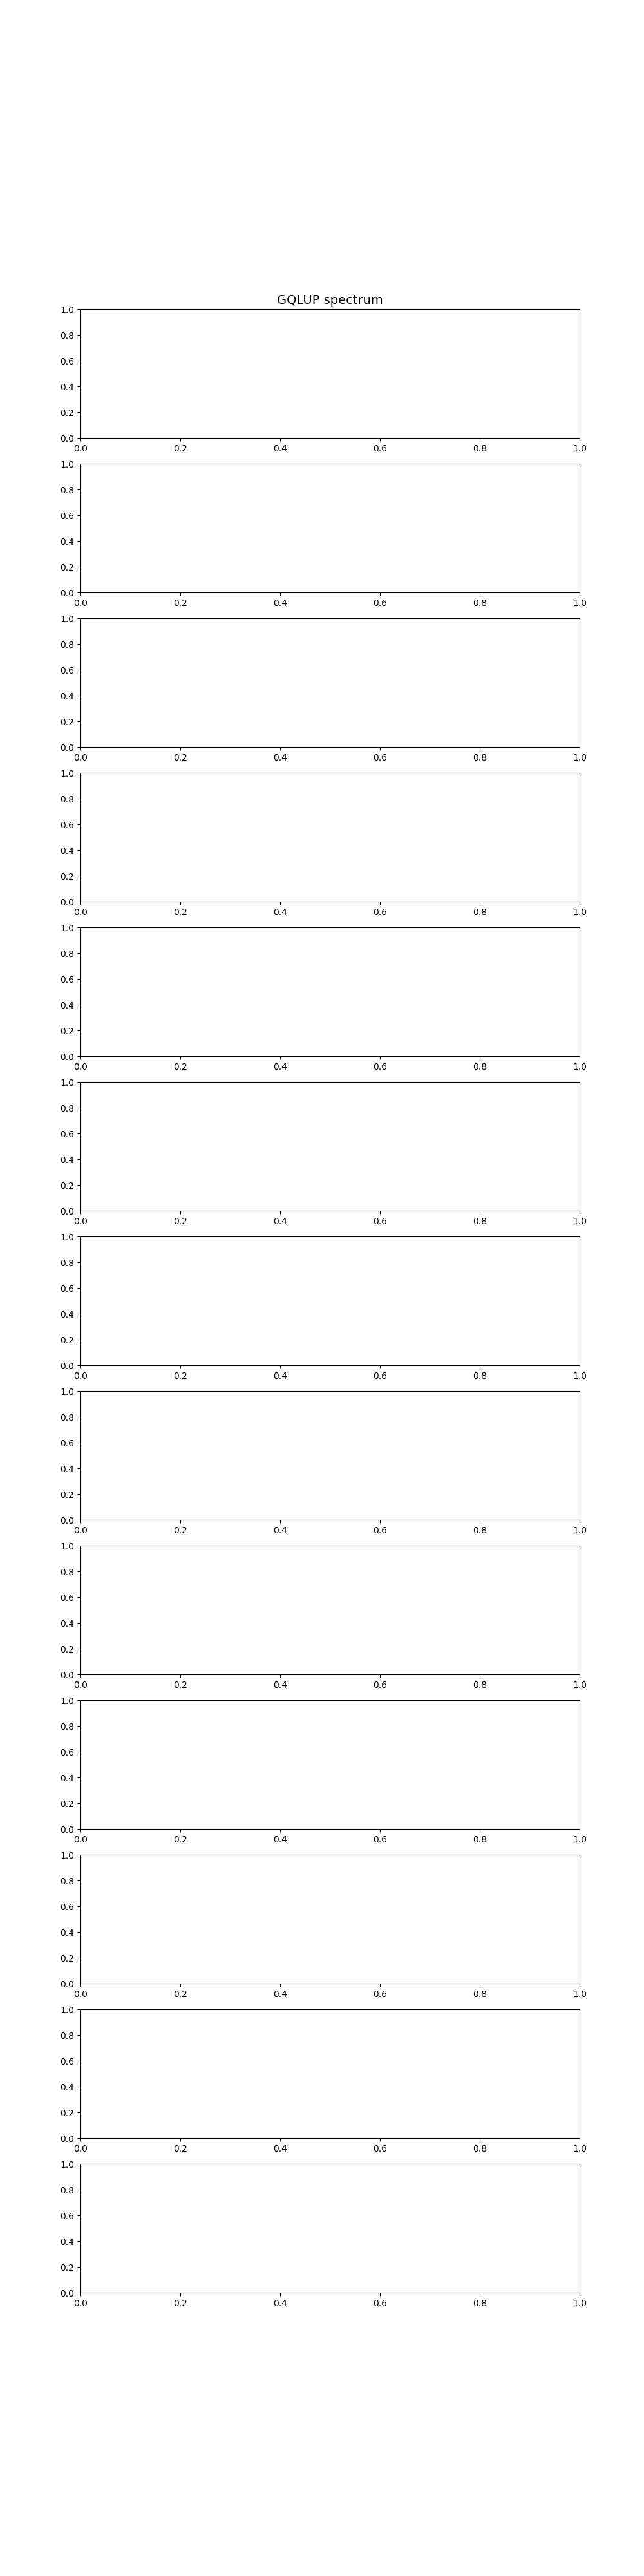

In [ ]:
# plot the spectrum (last panel shows the full spectrum)
if spec_mode == 'per_band':
    npanels = 13
    fig, axs = plt.subplots(npanels, 1, figsize=(10, 40))#, sharex=True)
else: # per channel
    npanels = 5 
    fig, axs = plt.subplots(npanels, 1, figsize=(10, 20))#, sharex=True)
axs[0].set_title("{} spectrum".format(source), fontsize=14)

# PLOT SPITZER SPECTRUM AS 'SPACE TRUTH'
if spitzer_file is not None:
    #spitzer_spec = pd.read_csv(join(input_dir,"PDS70_Spitzer-CASSIS-LR.1.csv"), header=1, skiprows=0) ## old spectrum
    spitzer_spec = pd.read_csv(spitzer_file, header=0, skiprows=0, sep='       ', engine='python') # new Spitzer data reduction
    #swav = spitzer_spec['#lam:mic']
    swav = np.array(spitzer_spec['lambda'])
    sf = np.array(spitzer_spec['Flux'])
    sf_er = np.array(spitzer_spec['F_Er'])

    idx0 = find_nearest(swav, wl_min)
    idx1 = find_nearest(swav, wl_max)
    if npanels>4:
        axs[npanels-1].errorbar(swav[idx0:idx1], sf[idx0:idx1], sf_er[idx0:idx1], c=cols[1], markersize=0, \
                                linestyle='--', linewidth=1, 
                                label='Spitzer IRS LRS', alpha=0.8)
# plot photometry
if photom_file is not None:
    photom_data = pd.read_csv(photom_file, header=0, skiprows=0, sep='\t')
    wl_p = photom_data['wavelength']
    f_p = photom_data['flux']
    ferr_p = photom_data['err_flux']
    ins_p = photom_data['instrument']
    
    if npanels>4:
        for pp in range(len(wl_p)):
            if pp == 0:
                lab_tmp = 'Photometry'
            else:
                lab_tmp = None
            axs[npanels-1].errorbar(wl_p[pp], f_p[pp], ferr_p[pp], c='k', marker='s', markersize=3,
                                    label=lab_tmp, alpha=0.8)
 
# PLOT MRS spectra
for ff, file in enumerate(files):
    
    # Load the spectrum
    out_name = splitext(file)[0] + '{}.txt'.format(lab)
    wavelength, corrected_flux = np.loadtxt(out_name).T
    
    # plot MRS spectrum
    good_idx = np.where(wavelength<wl_max)
    axs[ff].plot(wavelength[good_idx], corrected_flux[good_idx], c=cols[0], markersize=0, linestyle='-', linewidth=1, 
                label='MIRI/MRS - {} ({})'.format(suffix_ex1d[nchar:], lab[1:]), alpha=0.8)
    if npanels>4:
        if ff == 0:
            label = 'MIRI/MRS - {}{}'.format(suffix_ex1d[nchar:], lab)
        else:
            label = None
        axs[npanels-1].plot(wavelength[good_idx], corrected_flux[good_idx], c=cols[0], markersize=0, linestyle='-', linewidth=1, 
                            label=label, alpha=0.8)
    
    # plot Spitzer spectrum
    if spitzer_file is not None:
        idx0s = find_nearest(swav, max(np.amin(wavelength), wl_min))
        idx1s = find_nearest(swav, min(np.amax(wavelength), wl_max))
        axs[ff].errorbar(swav[idx0s:idx1s], sf[idx0s:idx1s], sf_er[idx0s:idx1s], c=cols[1], markersize=0, linestyle='--', linewidth=1, 
                    label='Spitzer IRS LRS', alpha=0.8)

    # also plot other spectra if requested and if they exist
    if compare_spec and nsuff>0:
        other_plot_files = [other_files[i] for i in range(min(5,nsuff))]
        suff_tmp_plot = [suff_tmp[i] for i in range(min(5,nsuff))]
        lab_c = '_comparison'
        f_i = 2 # set to 0 if you wish reductions starting from the first one to be plotted
        f_n = 3 # set to -1 if you wish reductions up to the last one to be plotted
        for f, flist in enumerate(other_plot_files[f_i:f_n]): #adapt "5" to change max number of comparisons
            #if f!=1 and f!=2:
            arr = np.loadtxt(flist[ff])
            wavelength = arr[:,0]
            corrected_flux_autobg = arr[:,1]
            good_idx = np.where(wavelength<wl_max)
            axs[ff].plot(wavelength[good_idx], corrected_flux_autobg[good_idx], c=cols[2+f], markersize=0, linestyle='-', linewidth=1, 
                         label='MIRI/MRS - {}'.format(suff_tmp_plot[f_i+f]), alpha=0.8)
            if npanels>4:
                if ff == 0:
                    label = 'MIRI/MRS - {}'.format(suff_tmp_plot[f_i+f])
                else:
                    label = None
                axs[npanels-1].plot(wavelength[good_idx], corrected_flux_autobg[good_idx], c=cols[2+f], markersize=0, linestyle='-', linewidth=1, 
                                    label=label, alpha=0.8)
    else:
        lab_c = ''

    axs[ff].set_ylabel('Flux (Jy)', fontsize=12)
    axs[ff].legend(prop={'size': 10}, loc=0)
    axs[npanels-1].set_xlabel(r'Wavelength ($\mu$m)', fontsize=12)
    axs[npanels-1].set_ylabel('Flux (Jy)', fontsize=12)
    axs[npanels-1].legend(prop={'size': 10}, loc=0)
    
    plt.tight_layout(h_pad=0)
    if spec_mode == 'per_band' and npanels == 13:
        plt.savefig(join(figs_dir,"{}_spectra_band{}.pdf".format(source, lab_c)), bbox_inches='tight')
    elif spec_mode == 'per_channel' and npanels == 5:
        plt.savefig(join(figs_dir,"{}_spectra_channel{}.pdf".format(source, lab_c)), bbox_inches='tight')
    else:
        plt.savefig(join(figs_dir,"{}_spectra{}.pdf".format(source, lab_c)), bbox_inches='tight')
    if show_plots:
        plt.show()
    
final_out_name = 'spectrum_minds.txt'
final_out_array = np.savetxt(join(fin3_dir,final_out_name), np.array([all_wavelength, all_corrected_flux]).T)

Make a single plot of the spectrum at all wavelengths

In [ ]:
# plotting options
cols_b = ['b','y','r','k']
ls = ['-', '--',':', 'dashdot']
band_labs = ['SHORT', 'MEDIUM', 'LONG']

NameError: name 'files' is not defined

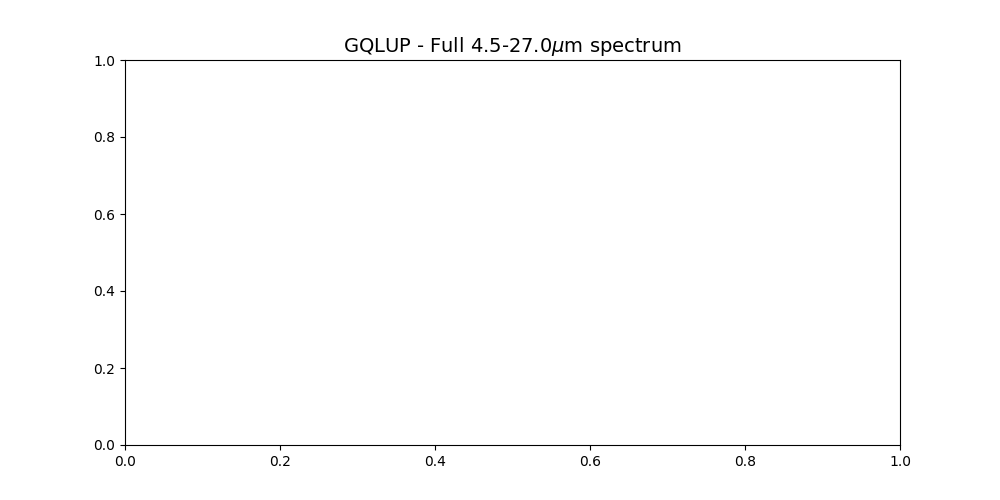

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(10, 5))#, sharex=True)
axs.set_title("{} - Full {:.1f}-{:.1f}$\mu$m spectrum".format(source,wl_min,wl_max), fontsize=14)

# PLOT SPITZER SPECTRUM AS 'SPACE TRUTH'
if spitzer_file is not None:
    #spitzer_spec = pd.read_csv(join(input_dir,"PDS70_Spitzer-CASSIS-LR.1.csv"), header=1, skiprows=0) ## old spectrum
    spitzer_spec = pd.read_csv(spitzer_file, header=0, skiprows=0, sep='       ', engine='python') # new Spitzer data reduction
    #swav = spitzer_spec['#lam:mic']
    swav = np.array(spitzer_spec['lambda'])
    sf = np.array(spitzer_spec['Flux'])
    sf_er = np.array(spitzer_spec['F_Er'])

all_wavelengths = []
all_fluxes = []
for ff, file in enumerate(files):
    if ff>0:
        label=None
    print('processing {}'.format(file))
    
    # open file as datamodel
    dm = datamodels.open(file)
    ## get columns
    ori_wavelength = dm.spec[0].spec_table['WAVELENGTH']
    flux = dm.spec[0].spec_table['FLUX']
    if type(nch_bad_per_band) == str:
        if "red" in nch_bad_per_band:
            if ff < len(files)-1:
                dm_next = datamodels.open(files[ff+1])
                next_wavelengths = dm_next.spec[0].spec_table['WAVELENGTH']
                idx_overlap = find_nearest(next_wavelengths[0], ori_wavelength, constraint='floor')
                if ff == 0:
                    nch_bad_per_band = [(0,len(ori_wavelength)-idx_overlap-1)]
                else: 
                    nch_bad_per_band.append((0,len(ori_wavelength)-idx_overlap-1))
            else:
                idx_overlap = len(ori_wavelength)-1
                nch_bad_per_band.append((0,0))
            wavelength = ori_wavelength[:idx_overlap+1]
            flux = flux[:idx_overlap+1]
        else:
            if ff == 0:
                idx_overlap = 0
                nch_bad_per_band = [(0,0)]
            else:
                dm_prev = datamodels.open(files[ff-1])
                prev_wavelengths = dm_prev.spec[0].spec_table['WAVELENGTH']
                idx_overlap = find_nearest(prev_wavelengths[-1], ori_wavelength, constraint='ceil')
                nch_bad_per_band.append((idx_overlap,0))
            wavelength = ori_wavelength[idx_overlap:]
            flux = flux[idx_overlap:]
    elif nch_bad_per_band[ff][0]>0 or nch_bad_per_band[ff][1]>0:
        wavelength = ori_wavelength[nch_bad_per_band[ff][0]:len(ori_wavelength)-nch_bad_per_band[ff][1]]
        flux = flux[nch_bad_per_band[ff][0]:len(flux)-nch_bad_per_band[ff][1]]
    else:
        wavelength = ori_wavelength

    # load the spectrum from a text file
    out_name = splitext(file)[0] + '{}.txt'.format(lab)
    out_array = np.loadtxt(out_name)
    wavelength = out_array[:,0]
    corrected_flux = out_array[:,1]
        
    # plot MRS spectrum
    good_idx = np.where(wavelength<wl_max)
    if ff < 3:
        label_tmp = 'MIRI/MRS ({} bands)'.format(band_labs[ff%3])
    else:
        label_tmp = None
    axs.plot(wavelength[good_idx], corrected_flux[good_idx], c=cols_b[ff%3], markersize=0, linestyle=ls[0], linewidth=1, 
             label=label_tmp, alpha=0.8)
    
    # plot Spitzer spectrum
    if spitzer_file is not None:
        if ff == 0:
            label_tmp = 'Spitzer IRS LRS'
        else:
            label_tmp = None
        idx0s = find_nearest(swav, max(np.amin(ori_wavelength), wl_min))
        idx1s = find_nearest(swav, min(np.amax(ori_wavelength), wl_max))
        axs.errorbar(swav[idx0s:idx1s], sf[idx0s:idx1s], sf_er[idx0s:idx1s], c=cols[1], markersize=0, linestyle=ls[1], linewidth=1, 
                     label=label_tmp, alpha=0.8)
        
    # also plot other spectra if requested and if they exist
    if compare_spec:
        for f, flist in enumerate(other_files[2:3]):
            if f == 0 and ff==0:
                lab_tmp = 'MIRI/MRS - {}'.format(suff_tmp[2+f])
            else:
                lab_tmp = None
            arr = np.loadtxt(flist[ff])
            wavelength = arr[:,0]
            corrected_flux_autobg = arr[:,1]
            good_idx = np.where(wavelength<wl_max)
            axs.plot(wavelength[good_idx], corrected_flux_autobg[good_idx], c=cols_b[ff%3], markersize=0, linestyle=ls[2+f], linewidth=1, 
                    label=lab_tmp, alpha=0.8)
            
# plot photometry
if photom_file is not None:
    photom_data = pd.read_csv(photom_file, header=0, skiprows=0, sep='\t')
    wl_p = photom_data['wavelength']
    f_p = photom_data['flux']
    ferr_p = photom_data['err_flux']
    ins_p = photom_data['instrument']
    for pp in range(len(wl_p)):
        if pp == 0:
            lab_tmp = 'Photometry'
        else:
            lab_tmp = None
        axs.errorbar(wl_p[pp], f_p[pp], ferr_p[pp], c='k', marker='s',markersize=3,
                     label=lab_tmp, alpha=0.8)
            
axs.set_ylabel('Flux (Jy)', fontsize=12)
axs.set_xlabel(r'Wavelength ($\mu$m)', fontsize=12)
axs.legend(prop={'size': 10}, loc=0)

plt.tight_layout(h_pad=0)
plt.savefig(join(figs_dir,"{}_spectra_full{}.pdf".format(source,ver)), bbox_inches='tight')
if show_plots:
    plt.show()

### 6.3. Final plot

In [ ]:
fwl_min=4.5      # min wavelength for the plot
fwl_max=26.8  # max wavelength for the plot
cols_f = ['k','c','b','g','orange','r','m','brown']
#compare_spec = True # whether to compare with other spectra

NameError: name 'files' is not defined

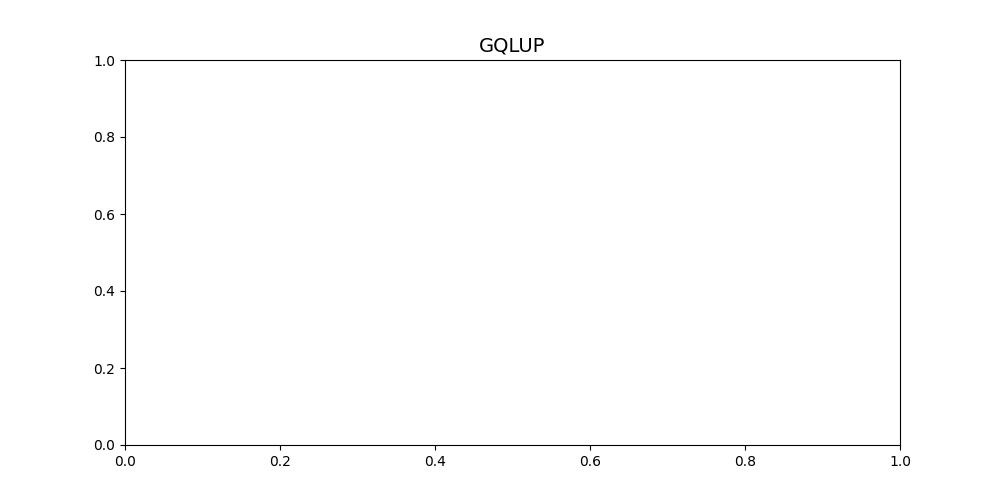

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(10, 5))#, sharex=True)
axs.set_title("{}".format(source), #" - Full {:.1f}-{:.1f}$\mu$m spectrum".format(source,wl_min,wl_max), 
              fontsize=14)

# PLOT SPITZER SPECTRUM AS 'SPACE TRUTH'
if spitzer_file is not None and compare_spec:
    #spitzer_spec = pd.read_csv(join(input_dir,"PDS70_Spitzer-CASSIS-LR.1.csv"), header=1, skiprows=0) ## old spectrum
    spitzer_spec = pd.read_csv(spitzer_file, header=0, skiprows=0, sep='       ', engine='python') # new Spitzer data reduction
    #swav = spitzer_spec['#lam:mic']
    swav = np.array(spitzer_spec['lambda'])
    sf = np.array(spitzer_spec['Flux'])
    sf_er = np.array(spitzer_spec['F_Er'])

all_wavelengths = []
all_fluxes = []
for ff, file in enumerate(files):
    if ff>0:
        label=None
    print('processing {}'.format(file))
    
    # open file as datamodel
    dm = datamodels.open(file)
    ## get columns
    ori_wavelength = dm.spec[0].spec_table['WAVELENGTH']
    flux = dm.spec[0].spec_table['FLUX']
    if type(nch_bad_per_band) == str:
        if "red" in nch_bad_per_band:
            if ff < len(files)-1:
                dm_next = datamodels.open(files[ff+1])
                next_wavelengths = dm_next.spec[0].spec_table['WAVELENGTH']
                idx_overlap = find_nearest(next_wavelengths[0], ori_wavelength, constraint='floor')
                if ff == 0:
                    nch_bad_per_band = [(0,len(ori_wavelength)-idx_overlap-1)]
                else: 
                    nch_bad_per_band.append((0,len(ori_wavelength)-idx_overlap-1))
            else:
                idx_overlap = len(ori_wavelength)-1
                nch_bad_per_band.append((0,0))
            wavelength = ori_wavelength[:idx_overlap+1]
            flux = flux[:idx_overlap+1]
        else:
            if ff == 0:
                idx_overlap = 0
                nch_bad_per_band = [(0,0)]
            else:
                dm_prev = datamodels.open(files[ff-1])
                prev_wavelengths = dm_prev.spec[0].spec_table['WAVELENGTH']
                idx_overlap = find_nearest(prev_wavelengths[-1], ori_wavelength, constraint='ceil')
                nch_bad_per_band.append((idx_overlap,0))
            wavelength = ori_wavelength[idx_overlap:]
            flux = flux[idx_overlap:]
    elif nch_bad_per_band[ff][0]>0 or nch_bad_per_band[ff][1]>0:
        wavelength = ori_wavelength[nch_bad_per_band[ff][0]:-nch_bad_per_band[ff][1]]
        flux = flux[nch_bad_per_band[ff][0]:-nch_bad_per_band[ff][1]]
    else:
        wavelength = ori_wavelength

    # load the spectrum from a text file
    out_name = splitext(file)[0] + '{}.txt'.format(lab)
    out_array = np.loadtxt(out_name)
    wavelength = out_array[:,0]
    corrected_flux = out_array[:,1]*10**3
        
    # plot MRS spectrum
    good_idx = np.where(wavelength<fwl_max)
    if ff == 0:
        label_tmp = 'MIRI/MRS'
    else:
        label_tmp = None
    axs.plot(wavelength[good_idx], corrected_flux[good_idx], c=cols_f[0], markersize=0, linestyle='solid', linewidth=1, 
             label=label_tmp, alpha=0.8)

# plot photometry
if photom_file is not None:
    photom_data = pd.read_csv(photom_file, header=0, skiprows=0, sep='\t')
    wl_p = photom_data['wavelength']
    f_p = photom_data['flux']
    ferr_p = photom_data['err_flux']
    ins_p = photom_data['instrument']
    for pp in range(len(wl_p)):
        axs.errorbar(wl_p[pp], f_p[pp], ferr_p[pp], c=cols_f[1+pp], marker='s', markersize=3,
                     label=ins_p[pp], alpha=0.8)

# plot Spitzer spectrum
if spitzer_file is not None:# and compare_spec:
    label_tmp = 'Spitzer IRS LRS'
    idx0s = find_nearest(swav, fwl_min)
    idx1s = find_nearest(swav, fwl_max)
    axs.errorbar(swav[idx0s:idx1s], sf[idx0s:idx1s], sf_er[idx0s:idx1s], c=cols[1], markersize=0, linestyle=ls[1], 
                 linewidth=1, label=label_tmp, alpha=0.8)

axs.set_ylabel('Flux (mJy)', fontsize=12)
axs.set_xlabel(r'Wavelength ($\mu$m)', fontsize=12)
axs.legend(prop={'size': 10}, loc=0)
axs.set_ylim([0,30])
axs.set_xlim([0,20])

plt.tight_layout(h_pad=0)
plt.savefig(join(figs_dir,"{}_spectra_final{}.pdf".format(source,ver)), bbox_inches='tight')
if show_plots:
    plt.show()

**Plot the continuum-subtracted spectrum** (if requested)

In [ ]:
if contsub:
    ## === Plot results
    PlotSpectrum(Wav      = StitchedWav,
                 Flux     = OStitchedFlux,  ## Using the original stitched spectrum in the plotting.
                 Baseline = StitchedBL,
                 Mask     = StitchedMask,
                 dY       = 0.025,
                 SavePlot = os.path.join(figs_dir, f'FullSpectrum_CS'),
                 MaskFeature=MaskFeature)

### 6.4. Aperture image

Adapt cell below to include the wavelengths for which you would like to show a spectral image, along with the corresponding aperture size used for extracting the spectrum:

In [ ]:
img_wls = [7.0, 14.9]

Let's define the number of pixels to crop from each side of the frames for the plot:

In [ ]:
crop_px = [19, 12]

Most of the other cells should not be modified (only the cell with ellipse parameters if you wish to include a sketch of the disk):

In [ ]:
if make_aperture_image:
    from hciplot import plot_frames
    cxy_med = open_fits(join(fin3_dir,"cxy_med.fits")) # Note: order is CH1_LONG, CH1_MED, CH1_SHORT, CH2_LONG, etc.
    cxy_med

FITS HDU-0 data successfully loaded. Data shape: (12, 2)


Find the indices of the bands in which requested wavelengths are located

In [ ]:
if make_aperture_image:
    # gather the spectra
    afiles = glob.glob(join(spec3_dir, '*{}*{}*.fits'.format(suffix[0],suffix_ex1d)))
    afiles.sort()
    afiles = sort_files_wl(afiles)
    afiles

NameError: name 'suffix_ex1d' is not defined

In [ ]:
if make_aperture_image:
    calfiles=sorted(glob.glob(join(spec3_dir,'Level3{}*{}_cen{}.fits'.format(suffix[0],suf, suf_bkg))))
    calfiles = sort_files_wl(calfiles)
    print(calfiles)

NameError: name 'suf' is not defined

In [ ]:
if make_aperture_image:
    good_ffs = []
    good_wavelengths = []
    for ff, file in enumerate(afiles):
        # open file as datamodel
        dm = datamodels.open(file)
        # get wavelengths
        wavelength = dm.spec[0].spec_table['WAVELENGTH']
        for wl in img_wls:
            if wl > wavelength[0] and wl < wavelength[-1]:
                good_ffs.append(ff)
                good_wavelengths.append(wavelength)
    good_ffs

NameError: name 'afiles' is not defined

In [ ]:
if make_aperture_image:
    good_frames = []
    good_plscs = []
    c = 0
    for ff, file in enumerate(calfiles):
        if ff in good_ffs:
            bname = basename(file)
            foutname = join(fin3_dir, bname)
            cube_cen, head = open_fits(foutname, header=True, n=1)
            dq_cube = fits.open(foutname, memmap=False)[3].data
            gp_cube = np.ones(dq_cube.shape)
            gp_cube[:] = np.nan
            gp_cube[np.where(dq_cube==0)]=1
            pxscale1 = float(head['CDELT1'])
            pxscale2 = float(head['CDELT2'])
            good_plscs.append(float(np.mean([pxscale1, pxscale2])*3600))
            # now find closest channel to requested wavelength
            close_idx = find_nearest(good_wavelengths[c], img_wls[c])
            print(len(good_wavelengths[c]))
            good_frames.append(cube_cen[close_idx, crop_px[c]:-crop_px[c], crop_px[c]:-crop_px[c]]*gp_cube[close_idx,crop_px[c]:-crop_px[c],crop_px[c]:-crop_px[c]])
            # previously: using band-edge cropped spectra
            #good_frames.append(cube_cen[nch_bad_per_band[ff][0]+close_idx,crop_px[c]:-crop_px[c], crop_px[c]:-crop_px[c]]*gp_cube[nch_bad_per_band[ff][0]+close_idx,crop_px[c]:-crop_px[c],crop_px[c]:-crop_px[c]])
            c += 1

NameError: name 'good_ffs' is not defined

Show image:

In [ ]:
if make_aperture_image and show_plots:
    circles = [(float(cxy_med[ff, 0])-crop_px[fc], float(cxy_med[ff, 1])-crop_px[fc]) for fc, ff in enumerate(good_ffs)]
    labels = [r"{:.1f} $\mu$m".format(img_wls[i]) for i in range(len(img_wls))]
    for ll, wl in enumerate(img_wls):
        vmin = abs(float(np.nanpercentile(good_frames[ll],0.01)))
        ticksep = 1./good_plscs[ll]
        fwhm = wl/good_plscs[ll]*0.31/8
        circ_rad = float(apsize*fwhm)
        plot_frames(good_frames[ll], label=labels[ll], dpi=300, colorbar=True, circle=circles[ll], cmap='inferno',
                    circle_radius=circ_rad, vmin=vmin, log=True, ang_scale=True, label_color='w',
                    ang_ticksep=ticksep, pxscale=good_plscs[ll], colorbar_label='MJy/sr')

NameError: name 'good_ffs' is not defined

Let's now save it:

In [ ]:
if make_aperture_image:
    for ll, wl in enumerate(img_wls):
        vmin = abs(float(np.nanpercentile(good_frames[ll],0.01)))
        ticksep = 1./good_plscs[ll]
        fwhm = wl/good_plscs[ll]*0.31/8
        circ_rad = float(apsize*fwhm)
        plot_frames(good_frames[ll], label=labels[ll], dpi=300, colorbar=True, circle=circles[ll], cmap='inferno',
                    circle_radius=circ_rad, vmin=vmin, log=True, ang_scale=True, label_color='w',
                    save=join(figs_dir,'Aperture_{:.1f}mu.pdf'.format(wl)),
                    ang_ticksep=ticksep, pxscale=good_plscs[ll], colorbar_label='MJy/sr')

`Pixel scale set to 0.12999999523162822`
`Pixel scale set to 0.2000000029802321`


Let's now add a sketch of the system. Here for PDS 70, we add 2 planets, and ellipses corresponding to inner and outer disks - feel free to adapt accordingly:

In [ ]:
if make_aperture_image:
    # planets
    b_dxy_as = (-0.112781, -0.111194) # expected position on 01/08/2022
    c_dxy_as = (0.210882, 0.005433)  # expected position on 01/08/2022
    # disk
    din_au = 18.*2 #diameter
    dout_au = 54.*2 #diameter
    dist = 113.43 #pc
    incl = 49.7 #deg
    PA_a = 158.6-90 # trigonometric

Final plot + save it:

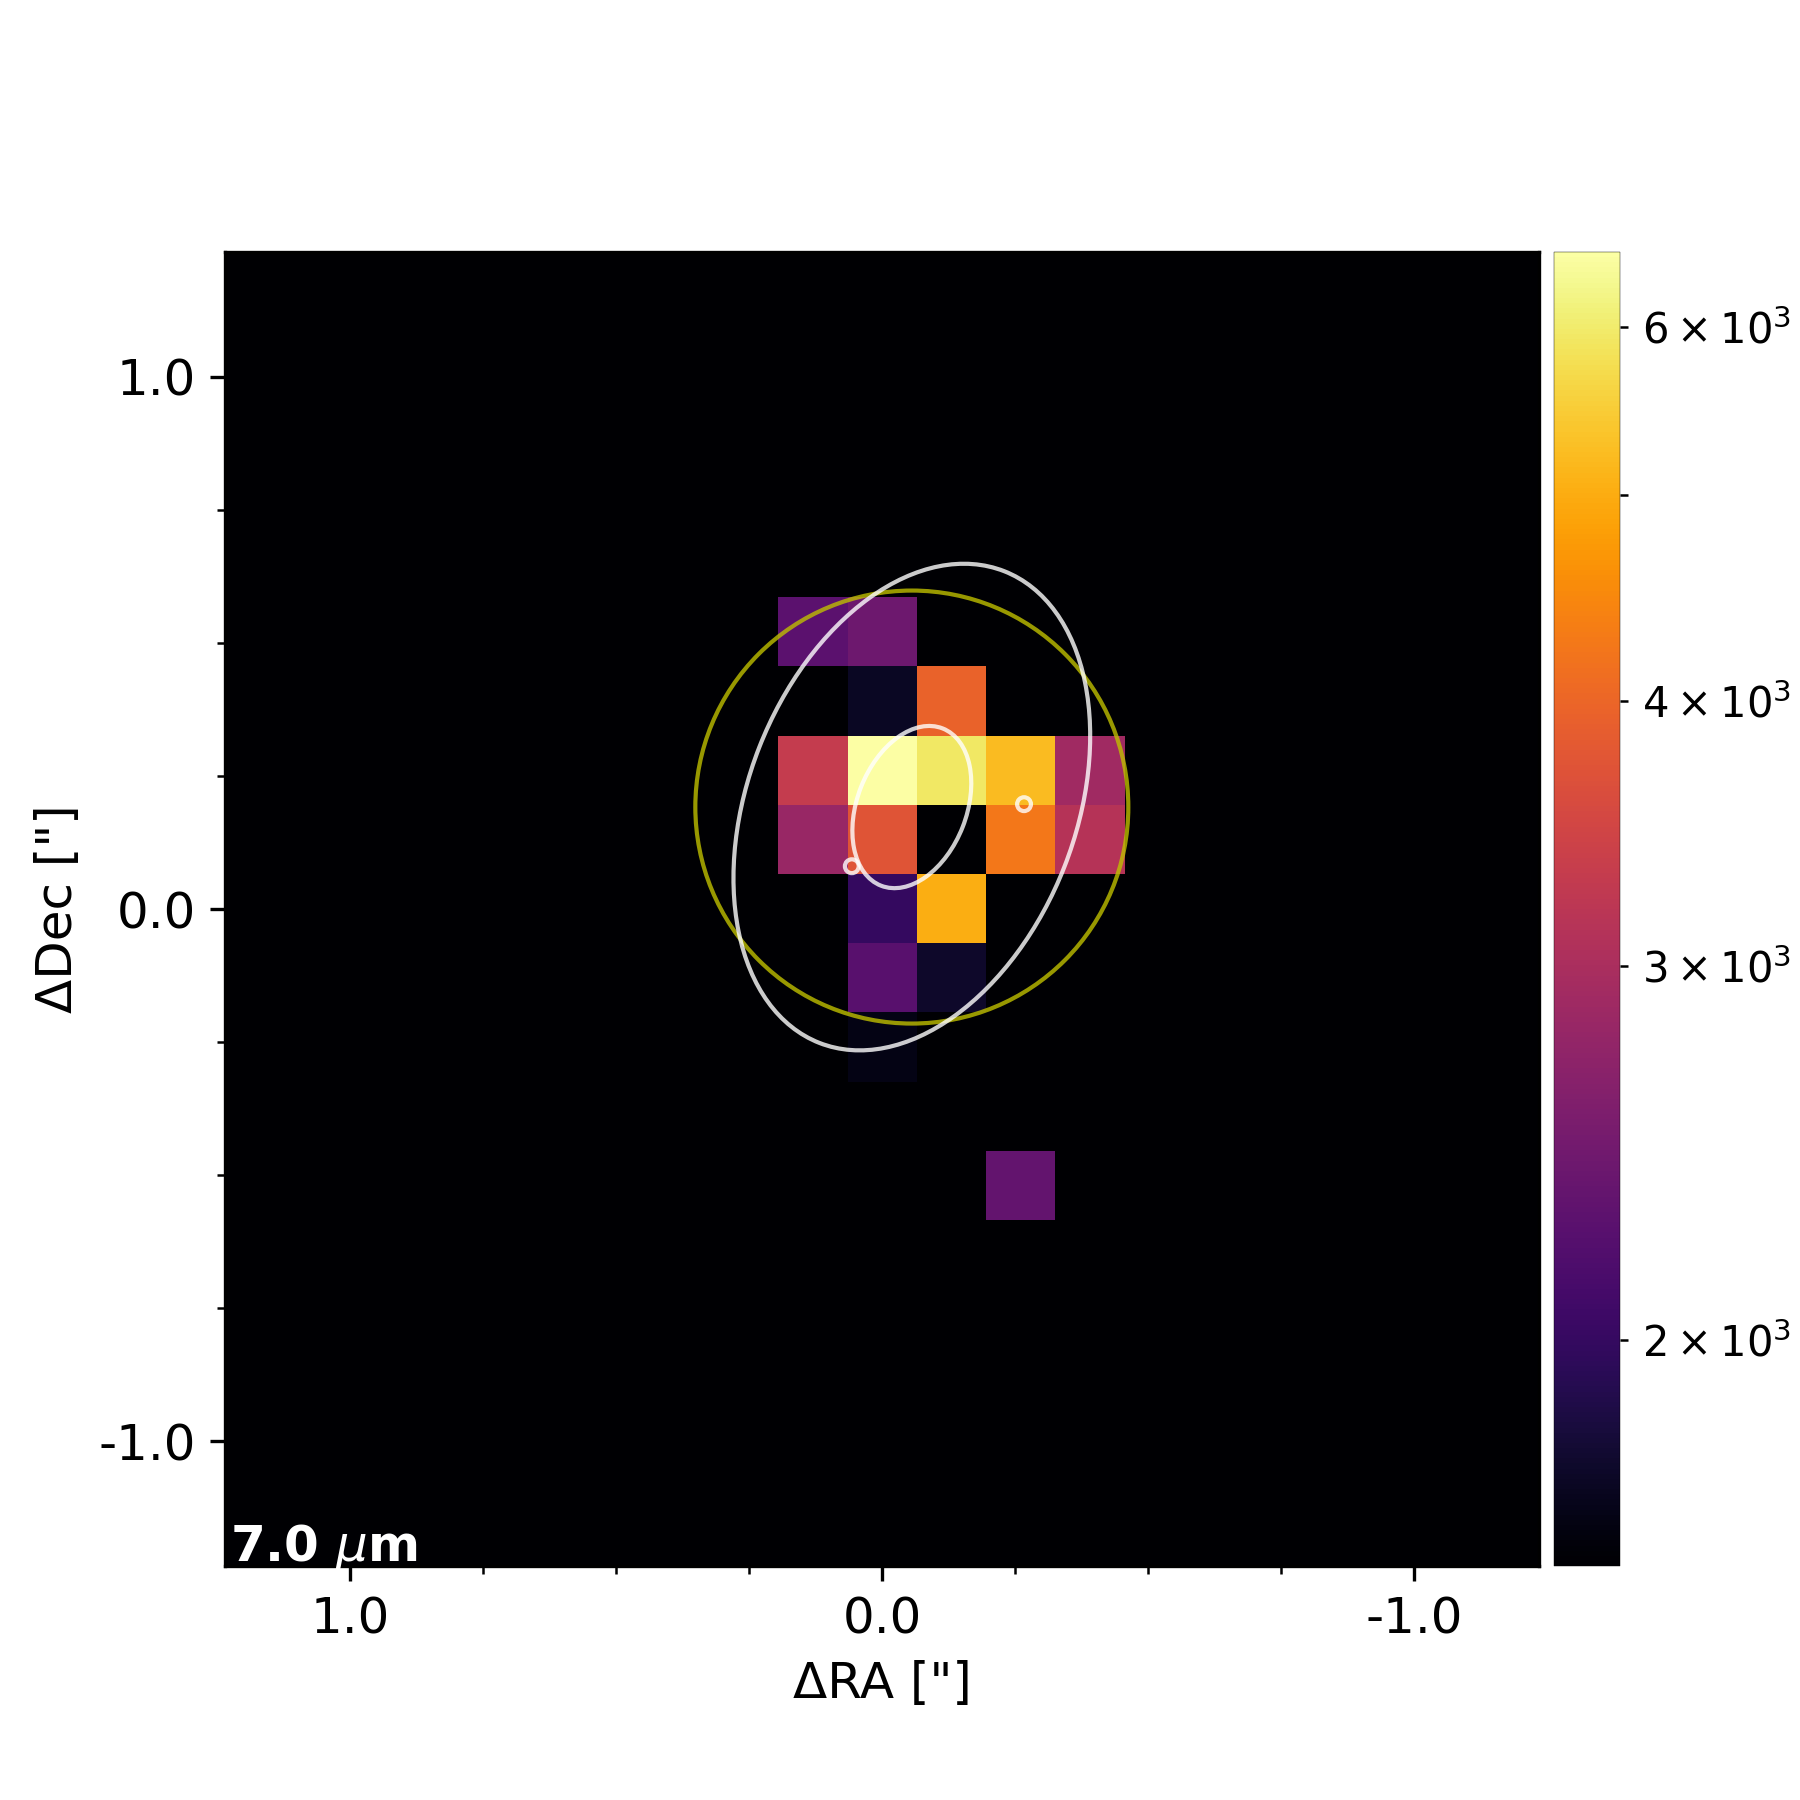

`Pixel scale set to 0.12999999523162822`


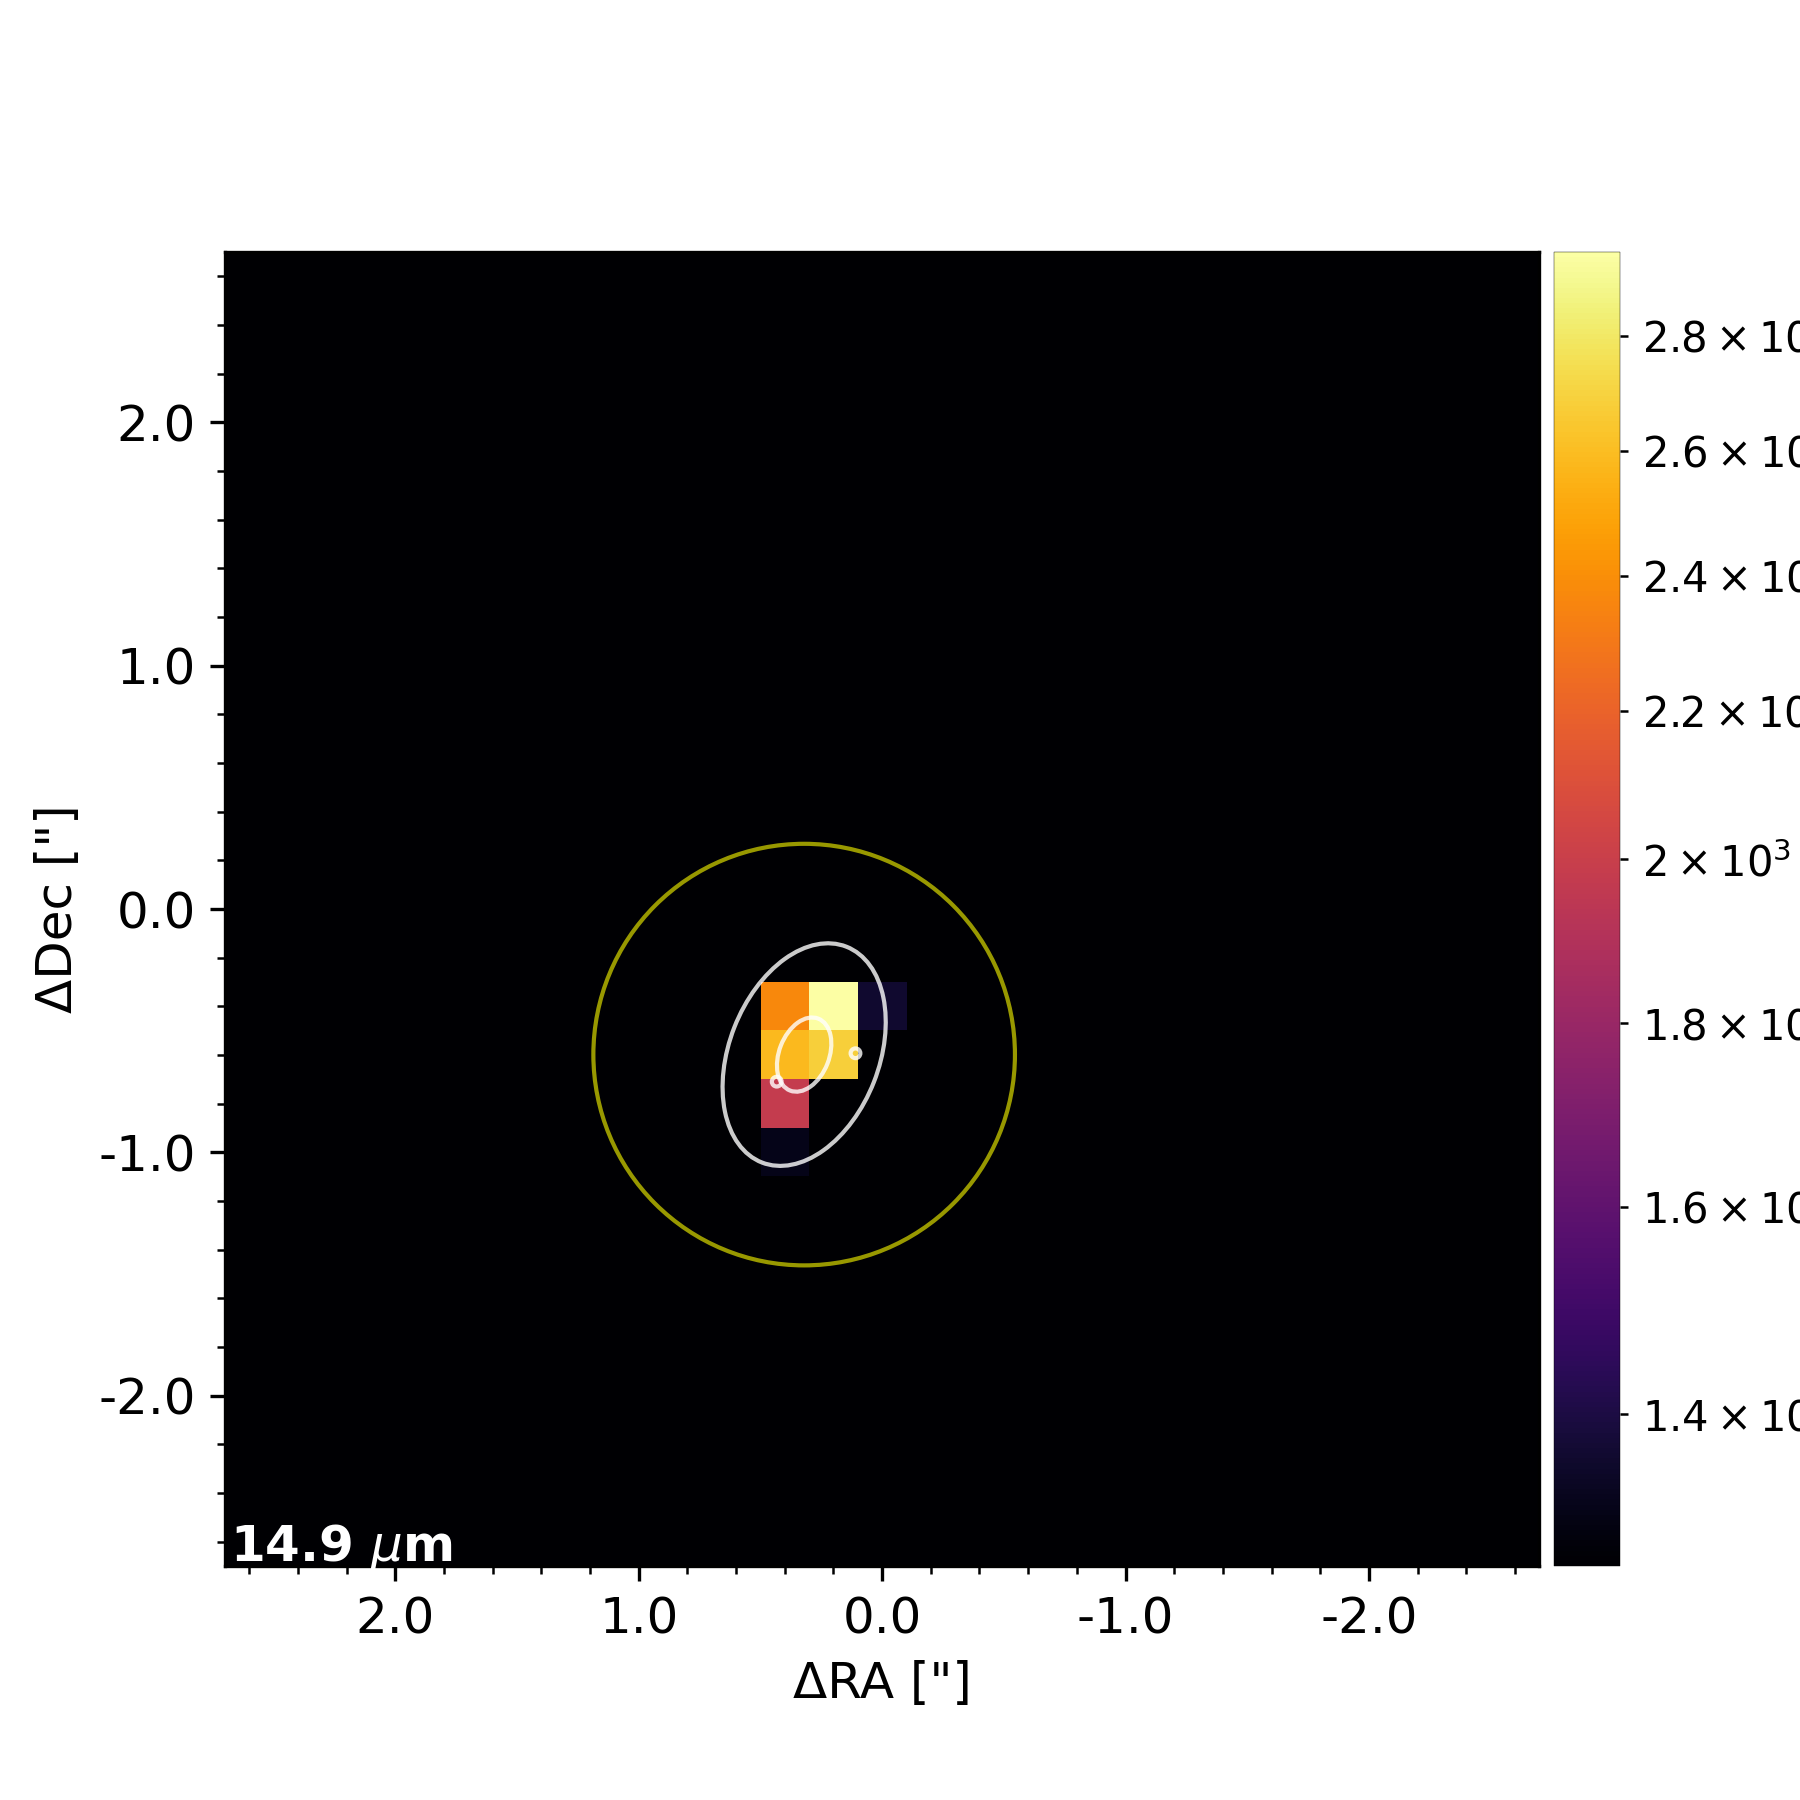

`Pixel scale set to 0.2000000029802321`


In [ ]:
if make_aperture_image:
    for ll, wl in enumerate(img_wls):
        vmin = abs(float(np.nanpercentile(good_frames[ll],0.01)))
        ticksep = 1./good_plscs[ll]
        fwhm = wl/good_plscs[ll]*0.31/8
        ap_rad = float(apsize*fwhm)
        # planet positions in frame
        b_xy = (circles[ll][0]+b_dxy_as[0]/good_plscs[ll], circles[ll][1]+b_dxy_as[1]/good_plscs[ll])
        c_xy = (circles[ll][0]+c_dxy_as[0]/good_plscs[ll], circles[ll][1]+c_dxy_as[1]/good_plscs[ll])
        sbc_circ = (circles[ll], b_xy, c_xy)
        circ_rads = (ap_rad, 0.1, 0.1)
        circle_colors = ('y', 'w', 'w')
        # ellipses in frame
        in_a = (din_au/dist)/good_plscs[ll]
        out_a = (dout_au/dist)/good_plscs[ll]
        ells = (circles[ll],circles[ll])
        ells_a = (in_a, out_a)
        ells_b = (in_a*np.cos(np.deg2rad(incl)), out_a*np.cos(np.deg2rad(incl)))
        ells_angs = (PA_a, PA_a)
        if show_plots:
            plot_frames(good_frames[ll], label=labels[ll], dpi=300, colorbar=True, cmap='inferno', 
                        circle=sbc_circ, circle_radius=circ_rads, circle_color=circle_colors, # circles
                        ellipse=ells, ellipse_a=ells_a, ellipse_b=ells_b, ellipse_angle=ells_angs, ellipse_label_color='g', # ellipses
                        vmin=vmin, log=True, ang_scale=True, label_color='w',
                        ang_ticksep=ticksep, pxscale=good_plscs[ll], colorbar_label='MJy/sr')
        # same but to save figure
        plot_frames(good_frames[ll], label=labels[ll], dpi=300, colorbar=True, cmap='inferno', 
                    circle=sbc_circ, circle_radius=circ_rads, circle_color=circle_colors, # circles
                    ellipse=ells, ellipse_a=ells_a, ellipse_b=ells_b, ellipse_angle=ells_angs, ellipse_label_color='g', # ellipses
                    vmin=vmin, log=True, ang_scale=True, label_color='w',
                    save=join(figs_dir,'Aperture_{:.1f}mu_annotated.pdf'.format(wl)),
                    ang_ticksep=ticksep, pxscale=good_plscs[ll], colorbar_label='MJy/sr')

<hr style="border:1px solid gray"> </hr>

# <img style="float: center;" src="https://www.stsci.edu/~dlaw/stsci_logo.png" alt="stsci_logo" width="200px"/> 